In [1]:
# pip install seaborn
# pip install seaborn scipy



In [2]:
# import the packages
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Load CSV with Complex Data").getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
from pyspark.sql.functions import min, max, col, isnan, floor

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, isnan, when, count, countDistinct, desc, skewness, mean, stddev, lag, log, lit, create_map
from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp
from pyspark.sql.window import Window
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, sum, desc, asc ,collect_list,avg, expr
from pyspark.sql.types import DoubleType, IntegerType, StringType, NumericType
from pyspark.ml.feature import Imputer, StandardScaler, VectorAssembler, OneHotEncoder, StringIndexer, PolynomialExpansion
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml import Transformer, Estimator, Pipeline
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.feature import RobustScaler

from scipy.stats import skew, stats, probplot 
from IPython.display import Image, display



your 131072x1 screen size is bogus. expect trouble
24/12/14 23:24:05 WARN Utils: Your hostname, Xiaohonggg resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/14 23:24:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/14 23:24:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



## **Table of Contents** <a id="top"></a>

#### [1. Problem Statement Formulation](#1)
- [**1.1** Load, Explore, and Understand the Data](#1-1)
#### [2. Exploratory Data Analysis and Data Cleaning](#2)
- [**2.1** Exploratory Data Analysis](#2-1)  
- [**2.2** Data Cleansing](#2-2)  
#### [3. Data Wrangling and Transformation](#3)
- [**3.1** Outlier Trimming](#3-1) 
- [**3.2** TF-IDF](#3-2a)   
- [**3.3** Train-Test Split](#3-2)  
- [**3.4** Missing Value Imputation](#3-3)  
- [**3.5** Categorical Data Encoding](#3-4)  
- [**3.6** Numerical Data Transformation](#3-5)  
- [**3.7** Variable Discretization](#3-6)  
- [**3.8** Correlation Analysis](#3-7)  
- [**3.9** Feature Scaling](#3-8)  
- [**3.10** Polynomial Expansion](#3-9)  

#### [4. Machine Learning Modelling](#4)
#### [5. Model Evaluation and Selection](#5)
#### [6. Report](#6)
#### [7. References](#7)


--------------------

## **1. Problem Statement Formulation** 

### **1.1 Load, Explore, and Understand the Data** <a id="1-1"></a>  
[Back to Top](#top)  


In [3]:

path = "ASG1_vietnamese_tiki_products_mod.csv"

# Read the CSV file, ensuring proper handling of quoted fields
Viet_data = spark.read.csv(
    path,
    header=True,        
    inferSchema=True,   
    quote='"',          
    escape='"',      
    multiLine=True,      
    ignoreLeadingWhiteSpace=True, 
    ignoreTrailingWhiteSpace=True
)

# Show the data
Viet_data.show()

+---------+--------------------+--------------------+--------------+-----+----------------+------+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+
|       id|                name|         description|original_price|price|fulfillment_type| brand|review_count|rating_average|favourite_count|pay_later|      current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|
+---------+--------------------+--------------------+--------------+-----+----------------+------+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+
|179731375|Women's backpack ...|Women's thick lea...|         14250|14250|        dropship|   OEM|           0|           0.0|              0|    false|       Thien An Balo|         488|              10|           0| 

In [4]:
#view shape of the dataframe before dropping
def shape(df):
    shape = (df.count(), len(df.columns))
    print (shape)

shape(Viet_data)

(44804, 18)


In [5]:
Viet_data.show(5)
type(Viet_data)

+---------+--------------------+--------------------+--------------+-----+----------------+-----+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+
|       id|                name|         description|original_price|price|fulfillment_type|brand|review_count|rating_average|favourite_count|pay_later|      current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|
+---------+--------------------+--------------------+--------------+-----+----------------+-----+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+
|179731375|Women's backpack ...|Women's thick lea...|         14250|14250|        dropship|  OEM|           0|           0.0|              0|    false|       Thien An Balo|         488|              10|           0|    f

pyspark.sql.dataframe.DataFrame

In [6]:
Viet_data.describe()

24/12/14 23:24:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+--------------------+--------------------+-----------------+------------------+----------------+----------+------------------+------------------+---------------+------------------+-----------------+------------------+------------------+-------------------+------------------+
|summary|                 id|                name|         description|   original_price|             price|fulfillment_type|     brand|      review_count|    rating_average|favourite_count|    current_seller|     date_created|  number_of_images|      vnd_cashback|       product_type|     quantity_sold|
+-------+-------------------+--------------------+--------------------+-----------------+------------------+----------------+----------+------------------+------------------+---------------+------------------+-----------------+------------------+------------------+-------------------+------------------+
|  count|              44804|               44804|               44804|            44804|             44804|           44804|     44804|             44804|             44794|          44804|             44804|            44804|             44804|             44804|              44804|             44804|
|   mean|1.465811535376752E8|                -4.0|                 1.0|311425.1171323989|278184.82198018034|            NULL|      NULL|2.8865503080082138|  1.35333526811626|            0.0|1991.4666666666667|706.3446120882064| 6.008659941076689|1498.8311757878762|               NULL| 16.36418623337202|
| stddev|6.331925070228175E7|                NULL|                 0.0|843016.2261013715| 744534.8771118637|            NULL|      NULL|17.194542958484906|2.0930257916476154|            0.0|0.5163977794943521|6045.971448106199|3.3958813154725056|6673.7396494920995|               NULL|155.35100512693003|
|    min|             159901|  Radio shawl, sp...|                B...|                0|                 0|        dropship|     \tOEM|                 0|               0.0|              0|       101 Ulzzang|                0|                 1|                 0|backpacks_suitcases|                 0|
|    max|          263302619|~ So hot ~ Unicor...|~~ Product Introd...|         19800000|          19800000|   tiki_delivery|Đồ Da Phúc|               969|               5.0|              0|            zigzag|           738076|                70|            167720|        women_shoes|             24847|
+-------+-------------------+--------------------+--------------------+-----------------+------------------+----------------+----------+------------------+------------------+---------------+------------------+-----------------+------------------+------------------+-------------------+------------------+

In [7]:
Viet_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- original_price: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- fulfillment_type: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- favourite_count: integer (nullable = true)
 |-- pay_later: boolean (nullable = true)
 |-- current_seller: string (nullable = true)
 |-- date_created: integer (nullable = true)
 |-- number_of_images: integer (nullable = true)
 |-- vnd_cashback: integer (nullable = true)
 |-- has_video: boolean (nullable = true)
 |-- product_type: string (nullable = true)
 |-- quantity_sold: integer (nullable = true)



In [8]:
#Check unique values for each column
for column in Viet_data.columns:
    Viet_data.select(column).distinct().show(10)  

+---------+
|       id|
+---------+
|138623793|
| 76247079|
|192126552|
|253073845|
|178101968|
|136795388|
|208681131|
| 91847507|
|199103404|
| 73519210|
+---------+
only showing top 10 rows

+--------------------+
|                name|
+--------------------+
|Multi -function c...|
|Brocade withdrawa...|
|Waterproof cosmet...|
|Green cosmetic ba...|
|Robocar poli flee...|
|Green KTP14 fashi...|
|Men's sports trav...|
|Laptop Backpack 1...|
|Free Fire Fire La...|
|Mikkor Laptop Bac...|
+--------------------+
only showing top 10 rows

+--------------------+
|         description|
+--------------------+
|                 ...|
|Handbags are an i...|
|Unisex Korean fas...|
|7-dish travel min...|
|Troy FB drawstrin...|
|Wide storage comp...|
| Hello !!! The pr...|
|Black drawstring ...|
|Fashion Backpack ...|
|Travel fashion ba...|
+--------------------+
only showing top 10 rows

+--------------+
|original_price|
+--------------+
|          4900|
|          9900|
|        135000|
|       

#### About the data:
Columns Available:
* Product information: `id`, `name`, `description`, `brand`, `product_type`
* Sales metrics: `quantity_sold`, `original_price`, `vnd_cashback`
* User interaction: `review_count`, `rating_average`, `favourite_count`
* Metadata: `date_created`, `number_of_images`, `has_video`

#### Problem Statement 
To build a predictive model to forcast the sales demand to optimize inventory management for online retail sellers. 

Objective: To forcast the sales demand (`quantity_sold`) of a product, using available information current products, sales metrics, and user interaction. The goal is to identify current  trendy products, helping sellers to efficiently manage inventory, prioritize popular products, and design targeted marketing strategies to boost sales.

## **2.Exploratory Data Analysis and Data Cleaning** <a id="2"></a>  
[Back to Top](#top)  

### **2.1 Exploratory Data Analysis** <a id="2-1"></a>  

In [9]:
#Finding out the null values within each  column
def missing_data(df):
    missing_counts = df.select(
        [sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]
    )

    # Convert the result to a Python dictionary
    missing_values_dict = missing_counts.collect()[0].asDict()

    # Print each column and its missing count
    for column, count in missing_values_dict.items():
        print(f"{column} : {count}")


missing_data(Viet_data)

id : 0
name : 0
description : 0
original_price : 0
price : 0
fulfillment_type : 0
brand : 0
review_count : 0
rating_average : 10
favourite_count : 0
pay_later : 0
current_seller : 0
date_created : 0
number_of_images : 0
vnd_cashback : 0
has_video : 0
product_type : 0
quantity_sold : 0


* Null values are only present in `rating_average`

In [10]:
#finding out the duplicated information within the dataset
row_counts = Viet_data.groupBy(Viet_data.columns).count()

duplicate_rows = row_counts.filter(col('count') > 1)
duplicate_rows_count = duplicate_rows.count()
print("Number of Duplicate Rows:", duplicate_rows_count)
duplicate_rows.select('id', col('count').alias('duplicate_count'))

Number of Duplicate Rows: 7659


+---------+---------------+
|       id|duplicate_count|
+---------+---------------+
| 54550045|              2|
|138623793|              2|
|253076373|              2|
|205272885|              2|
|173798774|              2|
| 89428567|              2|
|176509783|              2|
| 99848904|              2|
|208269609|              2|
| 46680310|              2|
|171045878|              2|
|208743810|              2|
|133948875|              2|
| 81453965|              2|
|125595066|              2|
| 83938737|              2|
|101395036|              2|
|193720533|              2|
|171776243|              2|
|125777824|              2|
+---------+---------------+
only showing top 20 rows

* Duplicated rows should be removed

In [11]:
Viet_data.columns

['id',
 'name',
 'description',
 'original_price',
 'price',
 'fulfillment_type',
 'brand',
 'review_count',
 'rating_average',
 'favourite_count',
 'pay_later',
 'current_seller',
 'date_created',
 'number_of_images',
 'vnd_cashback',
 'has_video',
 'product_type',
 'quantity_sold']

In [12]:
# Understanding the datatypes present in the data 
Viet_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- original_price: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- fulfillment_type: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- favourite_count: integer (nullable = true)
 |-- pay_later: boolean (nullable = true)
 |-- current_seller: string (nullable = true)
 |-- date_created: integer (nullable = true)
 |-- number_of_images: integer (nullable = true)
 |-- vnd_cashback: integer (nullable = true)
 |-- has_video: boolean (nullable = true)
 |-- product_type: string (nullable = true)
 |-- quantity_sold: integer (nullable = true)



In [13]:
Viet_data.show(5)

+---------+--------------------+--------------------+--------------+-----+----------------+-----+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+
|       id|                name|         description|original_price|price|fulfillment_type|brand|review_count|rating_average|favourite_count|pay_later|      current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|
+---------+--------------------+--------------------+--------------+-----+----------------+-----+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+
|179731375|Women's backpack ...|Women's thick lea...|         14250|14250|        dropship|  OEM|           0|           0.0|              0|    false|       Thien An Balo|         488|              10|           0|    f

In [14]:
# Extract the Numerical schema fields
Numerical_vars = []

schema_fields = Viet_data.schema.fields

# Loop through the schema and classify variables
for field in schema_fields:
    # Check if the field is numeric
    if field.dataType.typeName() in ["integer", "double", "float"]:
        Numerical_vars.append(field.name)

print("Numerical Variables:", Numerical_vars)


Numerical Variables: ['id', 'original_price', 'price', 'review_count', 'rating_average', 'favourite_count', 'date_created', 'number_of_images', 'vnd_cashback', 'quantity_sold']


In [15]:
# Extract the Categorical schema fields
Categorical_vars = []

# Define the schema fields manually or dynamically
schema_fields = Viet_data.schema.fields

# Loop through the schema and classify variables
for field in schema_fields:
    # Check if the field is numeric
    if field.dataType.typeName() in ["string","boolean"]:
        Categorical_vars.append(field.name)

print("Categorical Variables:", Categorical_vars)

Categorical Variables: ['name', 'description', 'fulfillment_type', 'brand', 'pay_later', 'current_seller', 'has_video', 'product_type']


In [16]:

Viet_data2 = Viet_data

In [17]:
# Finding out the number of unique values in each column
for col_name in Viet_data.columns:
    cardinality_check = Viet_data.select(col_name).distinct().count()
    print(f"{col_name}: {cardinality_check}")

id: 37129
name: 34150
description: 28214
original_price: 3119
price: 3643
fulfillment_type: 3
brand: 786
review_count: 204
rating_average: 34
favourite_count: 1
pay_later: 2
current_seller: 3689
date_created: 1731
number_of_images: 42
vnd_cashback: 2346
has_video: 2
product_type: 6
quantity_sold: 566


In [18]:
def analyse_categorical(df, cols):
    # Calculate frequency of categorical values
    frequency_df = df.groupBy(cols).count().orderBy(cols)
    frequency_data = frequency_df.collect()
    labels = [row[cols] for row in frequency_data]
    counts = [row['count'] for row in frequency_data]

    # Prepare data for the box plot (quantity_sold values for each category)
    quantity_data = df.groupBy(cols).agg(collect_list("quantity_sold").alias("quantity_sold"))
    quantity_data = quantity_data.collect()
    categories = [row[cols] for row in quantity_data]
    quantities = [row["quantity_sold"] for row in quantity_data]

    # Calculate average quantity sold for each category
    avg_quantity_data = df.groupBy(cols).avg("quantity_sold").orderBy(cols)
    avg_quantity_data = avg_quantity_data.collect()
    avg_categories = [row[cols] for row in avg_quantity_data]
    avg_quantities = [row["avg(quantity_sold)"] for row in avg_quantity_data]

    # Calculate median quantity sold for each category
    med_quantity_data = df.groupBy(cols).agg(
        expr("percentile_approx(quantity_sold, 0.5)").alias("median_quantity_sold")).orderBy(cols)
    med_quantity_data = med_quantity_data.collect()
    med_categories = [row[cols] for row in med_quantity_data]
    med_quantities = [row["median_quantity_sold"] for row in med_quantity_data]

    # Create plots
    sns.set(style="whitegrid", palette="pastel")
    fig, axes = plt.subplots(1, 3, figsize=(24, 10))
    plt.suptitle(f"Frequency Plot, Box-plot, and Comparison Plot for {cols} vs quantity_sold", fontsize=18)

    # Frequency Plot
    bars = axes[0].barh(labels, counts, color=sns.color_palette())
    axes[0].set_title(f'Frequency of {cols}', fontsize=16)
    axes[0].set_ylabel(cols, fontsize=14)
    axes[0].set_xlabel('Frequency', fontsize=14)

    # Add data labels to the bars
    for bar, count in zip(bars, counts):
        axes[0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{count}', 
                     va='center', ha='left', fontsize=12)

    # Box Plot
    boxplot_data = []
    boxplot_categories = []
    for category, quantity in zip(categories, quantities):
        boxplot_data.append(quantity)
        boxplot_categories.append(category)

    sns.boxplot(data=boxplot_data, orient="h", ax=axes[1])
    axes[1].set_yticks(range(len(boxplot_categories)))
    axes[1].set_yticklabels(boxplot_categories, fontsize=12)
    axes[1].set_title(f'Box Plot: Quantity Distribution by {cols}', fontsize=16)
    axes[1].set_xlabel('quantity_sold', fontsize=14)
    axes[1].set_ylabel(cols, fontsize=14)

    # Comparison Plot for Average and Median Quantity Sold
    x_positions = range(len(avg_categories))
    bar_width = 0.4

    # Plot average quantities
    bars1 = axes[2].barh(
        [x - bar_width / 2 for x in x_positions],
        avg_quantities,
        height=bar_width,
        label="Average Quantity Sold",
        color="skyblue"
    )

    # Plot median quantities
    bars2 = axes[2].barh(
        [x + bar_width / 2 for x in x_positions],
        med_quantities,
        height=bar_width,
        label="Median Quantity Sold",
        color="orange"
    )

    axes[2].set_yticks(x_positions)
    axes[2].set_yticklabels(avg_categories, fontsize=12)
    axes[2].set_title(f'Comparison of Average and Median Quantity Sold by {cols}', fontsize=16)
    axes[2].set_ylabel(cols, fontsize=14)
    axes[2].set_xlabel('Quantity Sold', fontsize=14)
    axes[2].legend(fontsize=14)

    # Add data labels to each bar in the comparison plot
    for bar, value in zip(bars1, avg_quantities):
        axes[2].text(value, bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', ha='left', fontsize=12)

    for bar, value in zip(bars2, med_quantities):
        axes[2].text(value, bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', ha='left', fontsize=12)

    # Adjust layout and show the plots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show()


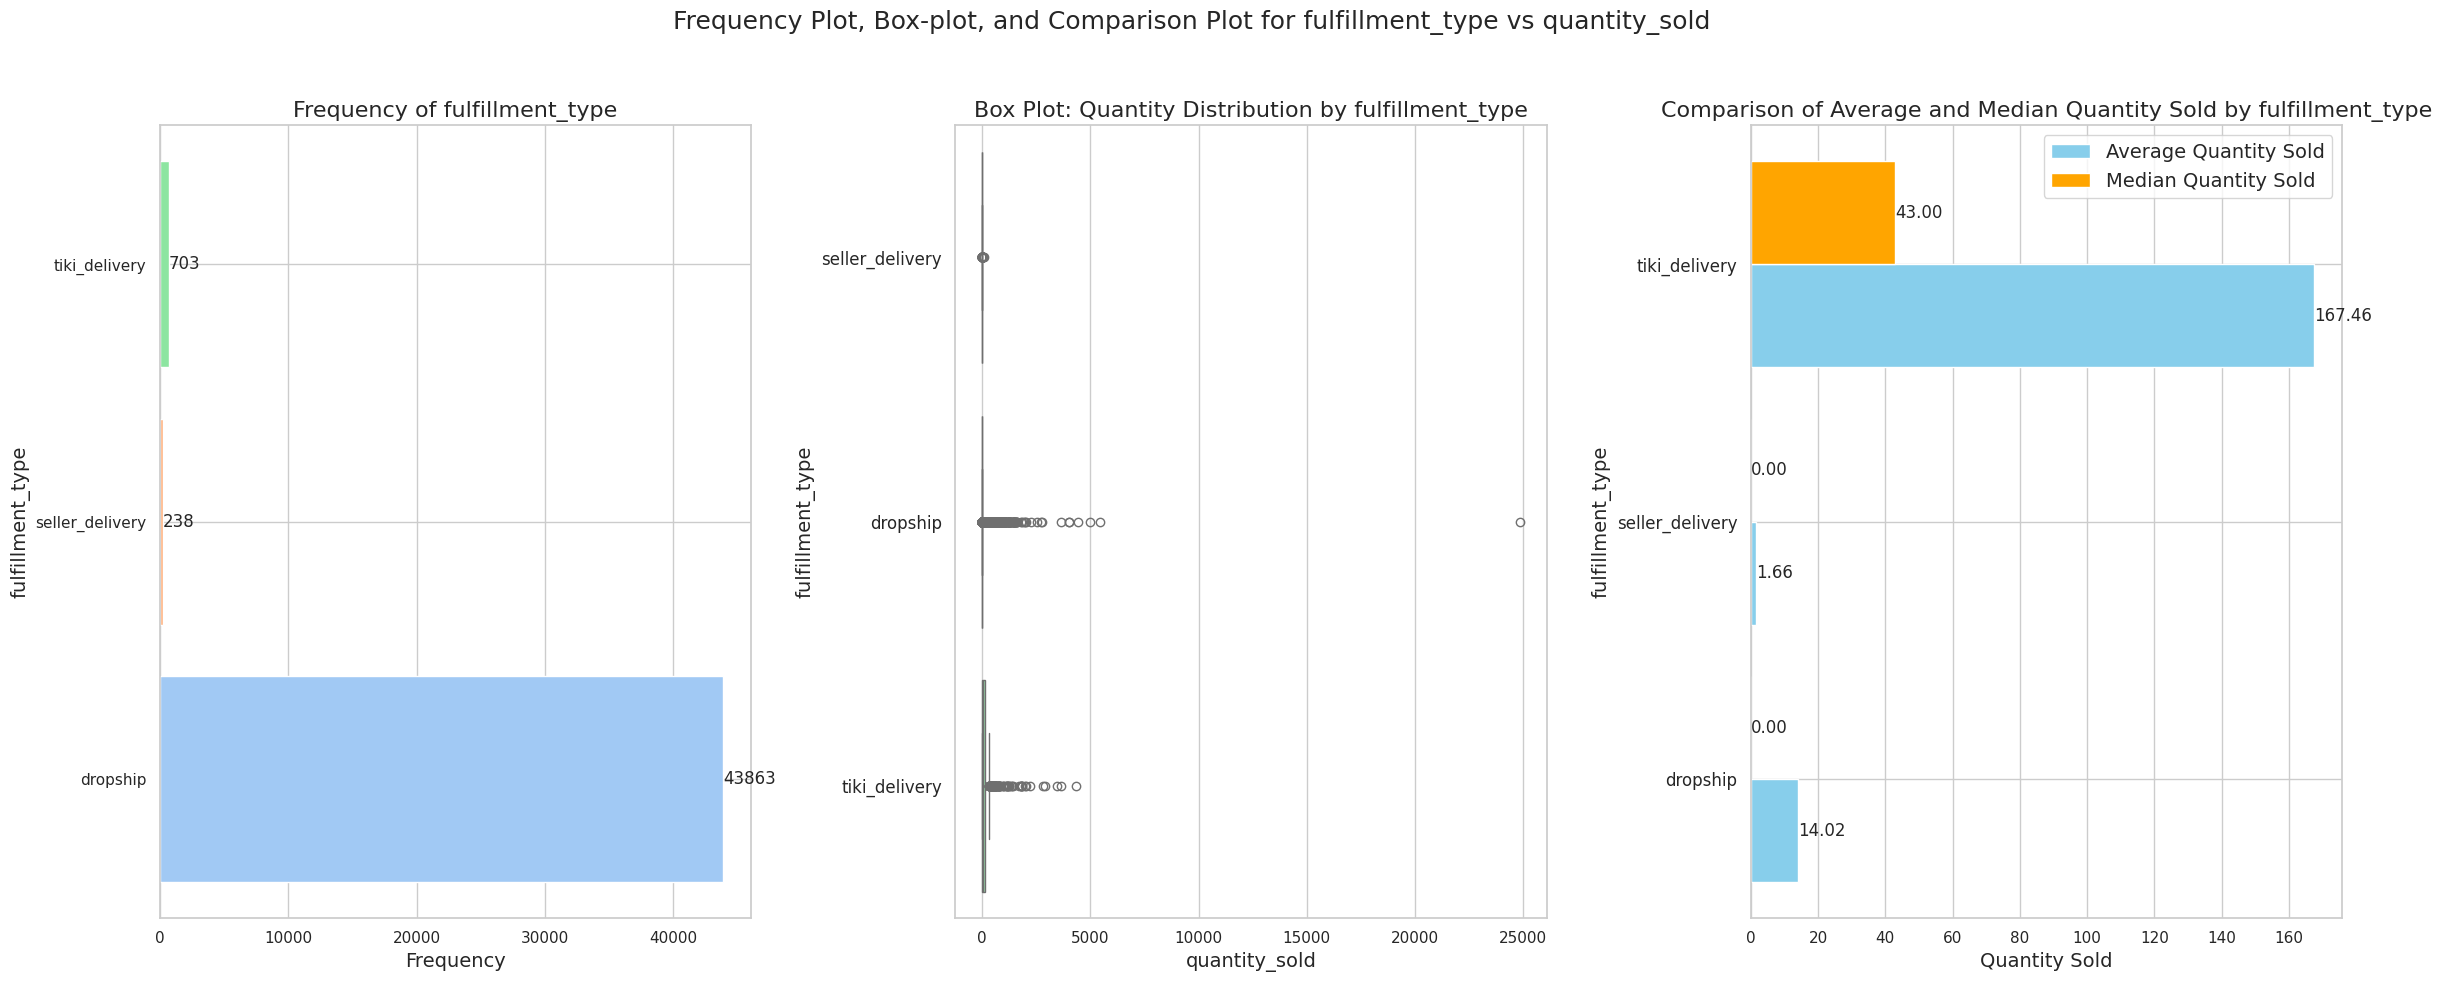

In [19]:
analyse_categorical(Viet_data,'fulfillment_type')


* most fulfillment type is through drop ship, but filfullment type through tiki delivery has a higher quantity sold

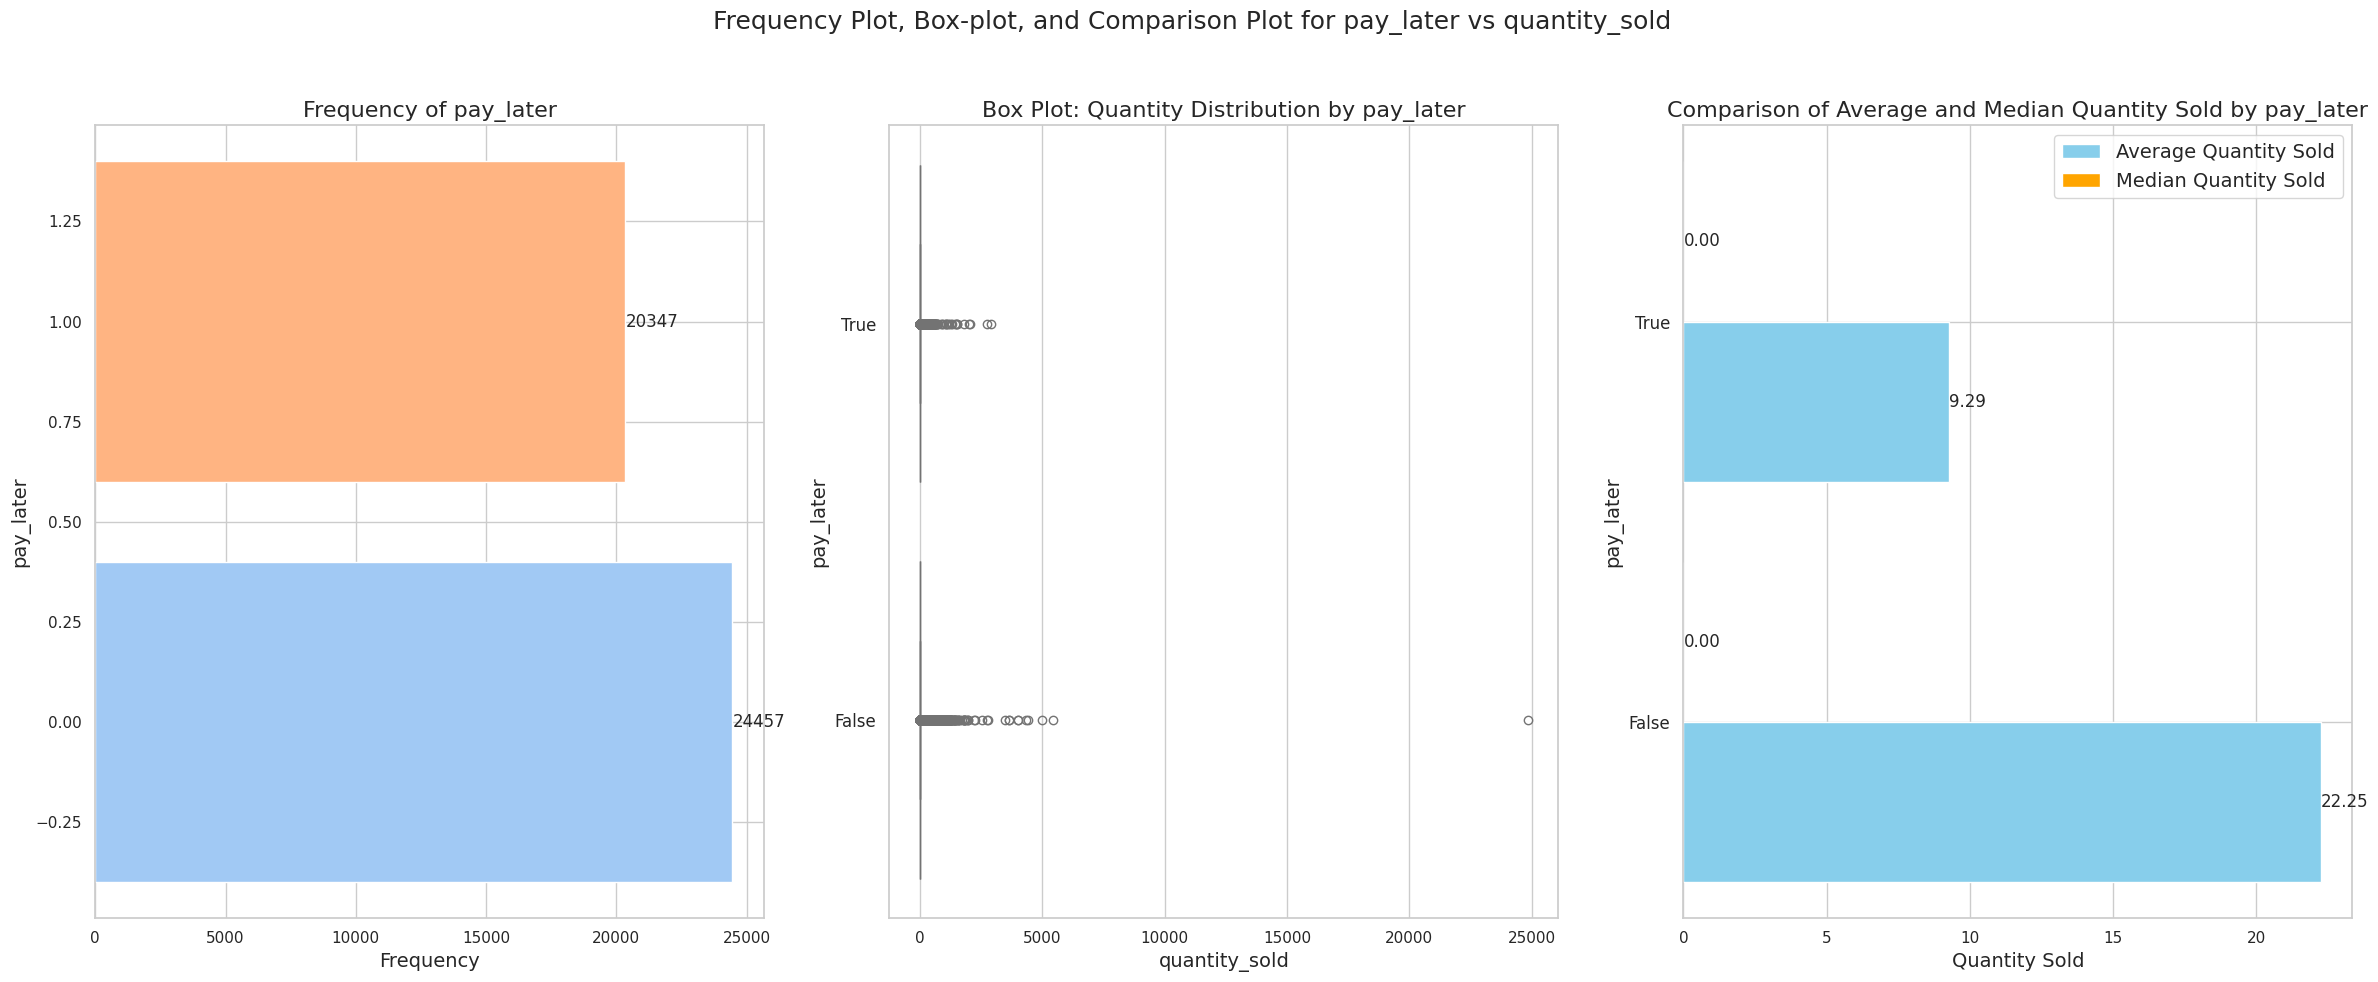

In [20]:
analyse_categorical(Viet_data,'pay_later')

* average quantity sold is higher when pay later is false

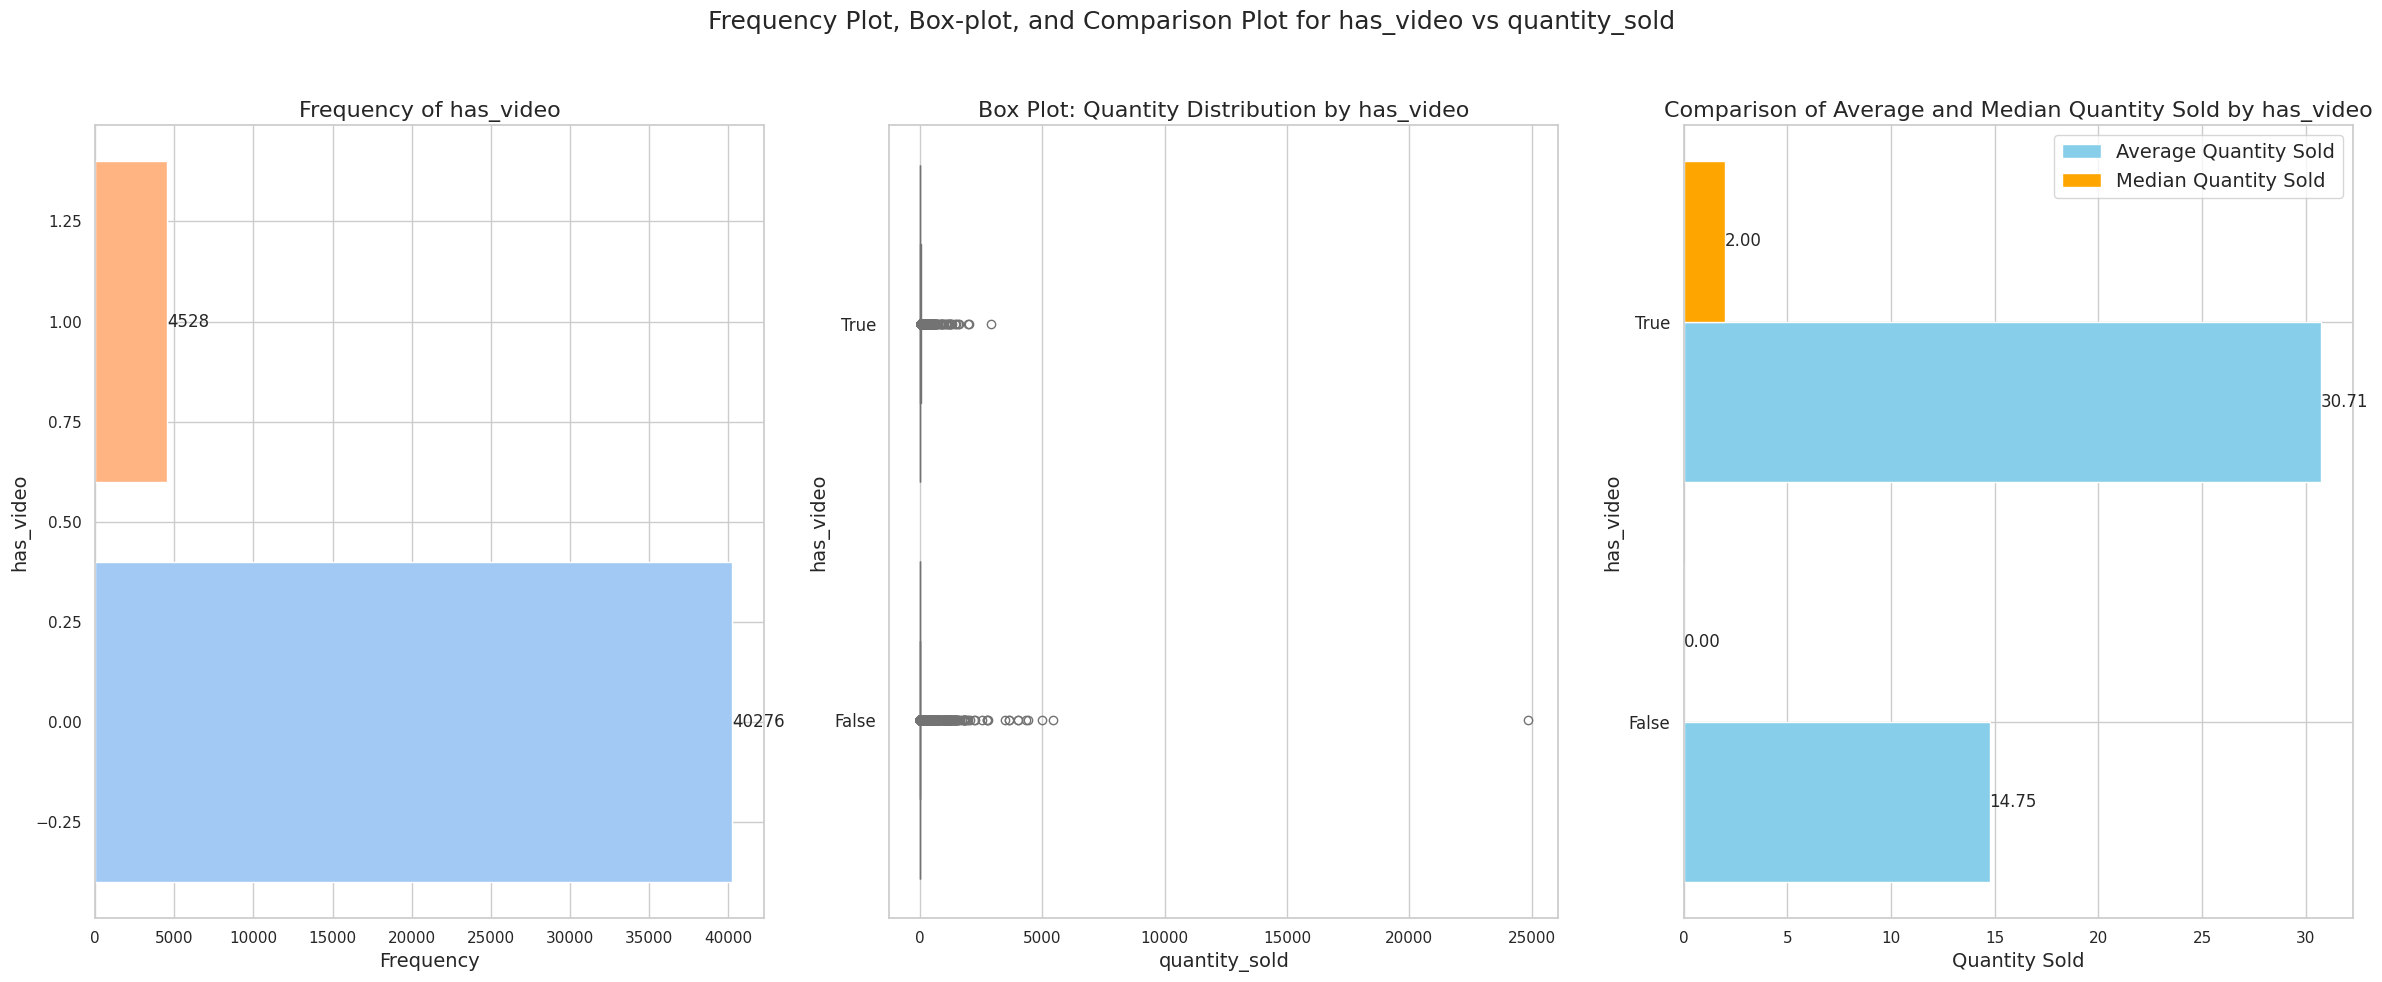

In [21]:
analyse_categorical(Viet_data,'has_video')

* Most of the products are without videos, but products with videos has higher average quantity sold. 

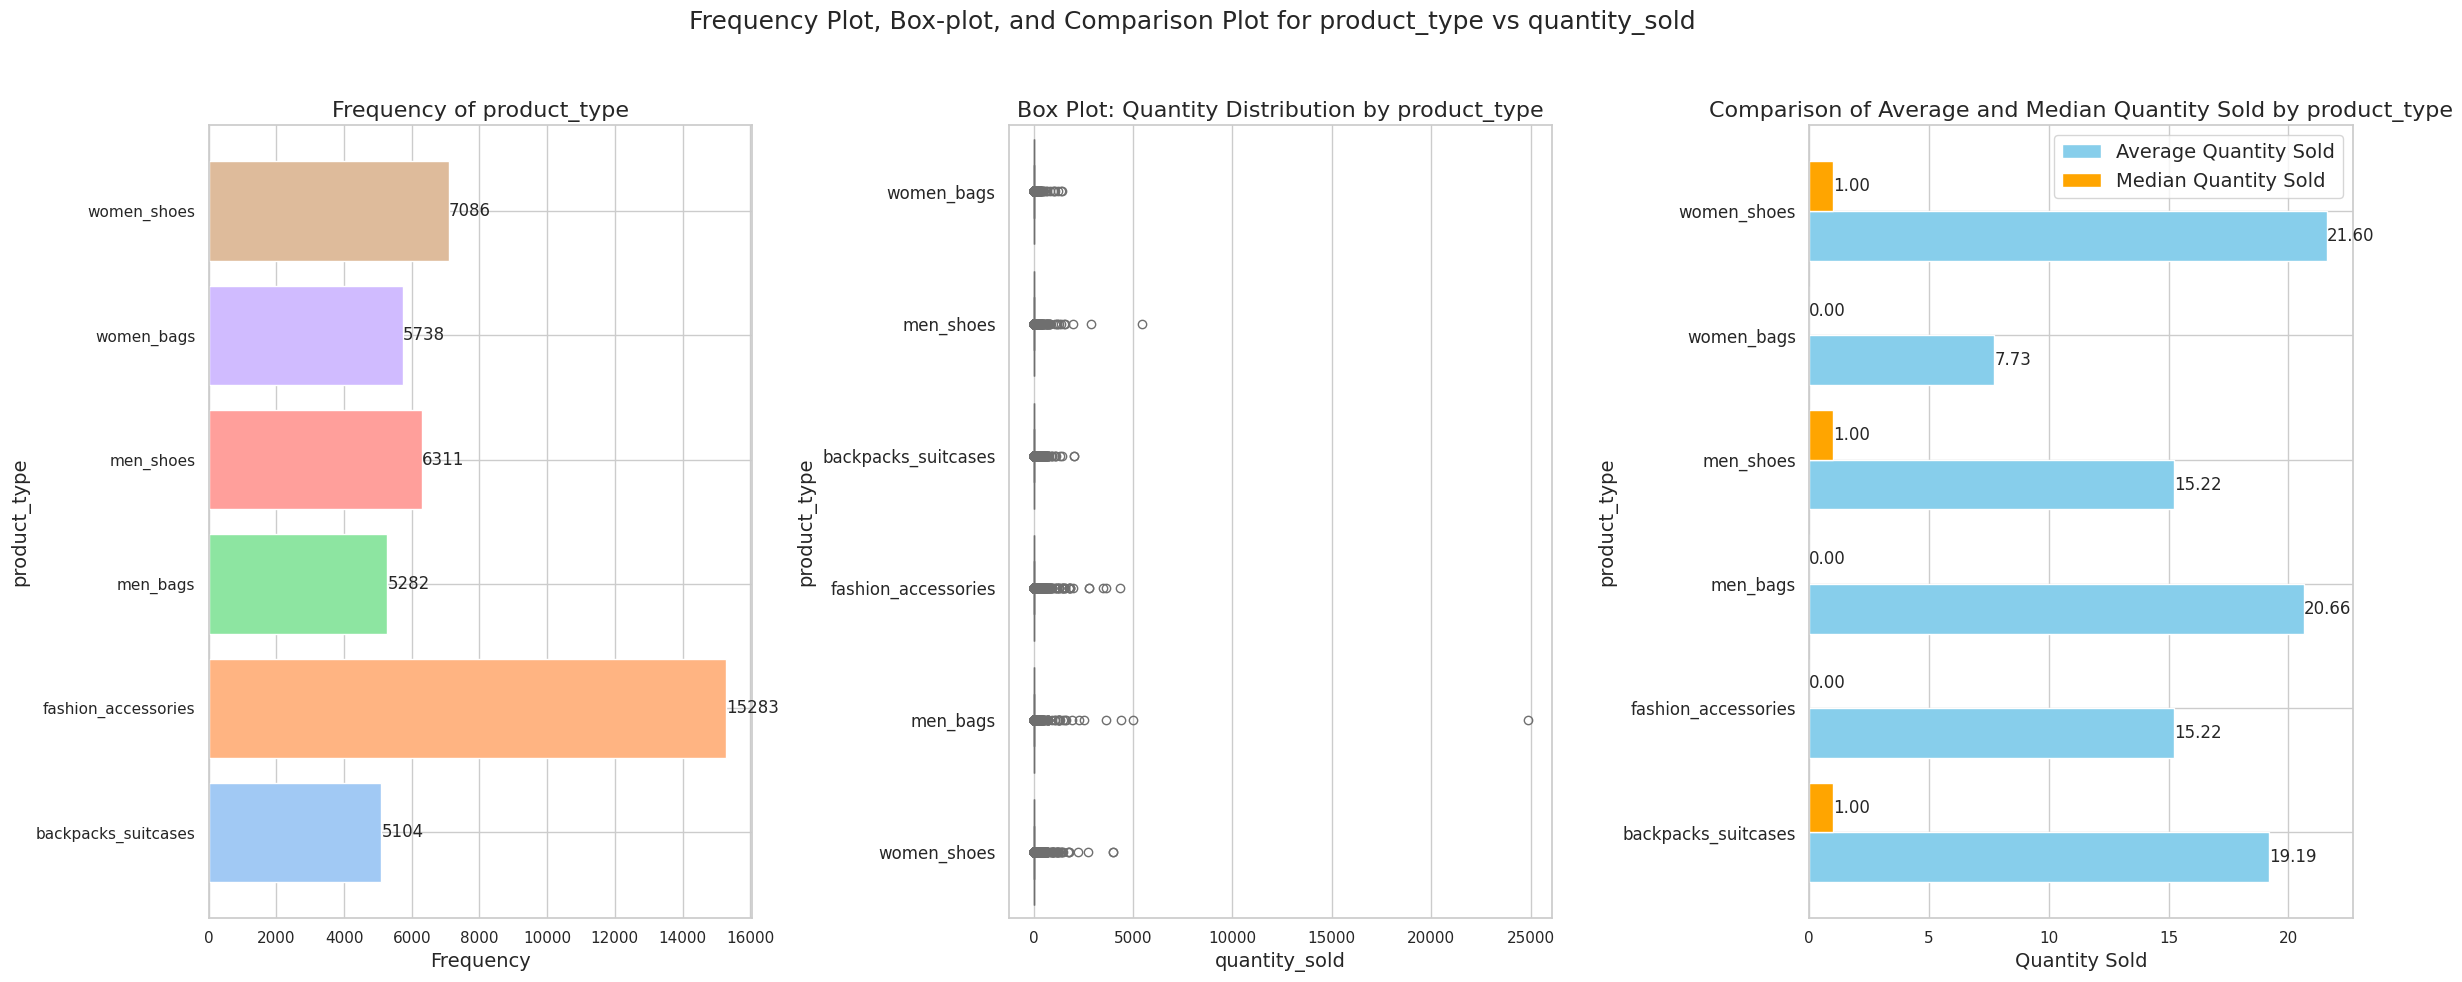

In [22]:
analyse_categorical(Viet_data,'product_type')

* most of the products are of `fashion_accesssories` but it only has a moderate quantity sold.
* one of the `mens_bags` product has a very high quantity sold, but average quanity sold is slightly higher for `women_shoes`

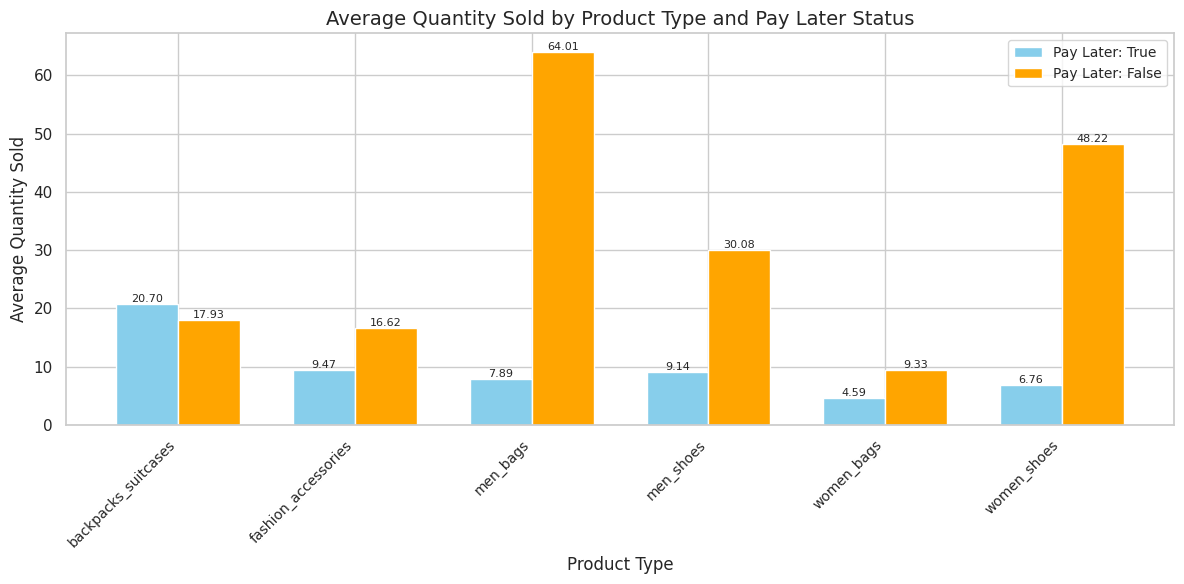

In [23]:
# pay later vs product type
#Calculate average quantity sold by product type and pay_later
avg_quantity_df = Viet_data.groupBy("product_type", "pay_later").agg(
    mean("quantity_sold").alias("avg_quantity_sold")
)
product_type_order = avg_quantity_df.select("product_type").distinct().orderBy("product_type").rdd.flatMap(lambda x: x).collect()

avg_quantity_data = avg_quantity_df.collect()

# Organize the data by product type and pay_later
data_dict = {product_type: {"True": 0, "False": 0} for product_type in product_type_order}

for row in avg_quantity_data:
    product_type = row["product_type"]
    pay_later_status = str(row["pay_later"])
    avg_quantity_sold = row["avg_quantity_sold"]
    data_dict[product_type][pay_later_status] = avg_quantity_sold

#bar plot
product_types = list(data_dict.keys())
avg_quantity_true = [data_dict[ptype]["True"] for ptype in product_types]
avg_quantity_false = [data_dict[ptype]["False"] for ptype in product_types]
x = np.arange(len(product_types))  
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width / 2, avg_quantity_true, width, label="Pay Later: True", color="skyblue")
bars2 = ax.bar(x + width / 2, avg_quantity_false, width, label="Pay Later: False", color="orange")
ax.set_xlabel("Product Type", fontsize=12)
ax.set_ylabel("Average Quantity Sold", fontsize=12)
ax.set_title("Average Quantity Sold by Product Type and Pay Later Status", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(product_types, rotation=45, ha="right", fontsize=10)
ax.legend(fontsize=10)

# Add data labels on top of the bars
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha="center", va="bottom", fontsize=8)

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha="center", va="bottom", fontsize=8)


plt.tight_layout()
plt.show()

* Overall quantity sold is higher for products with `pay_later` = false, except for `backpacks_suitcases`

In [24]:
# Extract the Numerical schema fields
numerical_vars  = []

# Define the schema fields manually or dynamically
schema_fields = Viet_data2.schema.fields

# Loop through the schema and classify variables
for field in schema_fields:
    if field.dataType.typeName() == "integer":
        numerical_vars.append(field.name)

print("Numerical Variables:", numerical_vars)

Numerical Variables: ['id', 'original_price', 'price', 'review_count', 'favourite_count', 'date_created', 'number_of_images', 'vnd_cashback', 'quantity_sold']


In [25]:

def analyse_numerical(df, num_var, target):

    # Step 1: Collect Data
    # Histogram and Box Plot Data
    numerical_data = df.select(num_var).filter(col(num_var).isNotNull()).rdd.flatMap(lambda x: x).collect()

    # Calculate skewness
    if len(numerical_data) > 1:
        skewness_value = skew(numerical_data)
    else:
        skewness_value = 0  # Default for single value

    # Scatter Plot Data
    scatter_data = df.select(num_var, target).filter(
        col(num_var).isNotNull() & col(target).isNotNull()
    ).collect()
    scatter_y = [row[num_var] for row in scatter_data]
    scatter_x = [row[target] for row in scatter_data]
    # Calculate correlation
    correlation = df.corr(num_var, target)

    # Step 2: Create Plots
    sns.set(style="whitegrid", palette="muted")
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle(f"Histogram, Box-plot, and Scatter plot for {num_var}", fontsize=16)


    # Plot 1: Histogram
    sns.histplot(numerical_data, kde=True, bins=30, ax=axes[0], color="skyblue")
    axes[0].set_title(f'Histogram of {num_var} (Skewness: {skewness_value:.2f})')
    axes[0].set_xlabel(num_var)
    axes[0].set_ylabel('Frequency')

    # Plot 2: Box Plot
    sns.boxplot(x=numerical_data, ax=axes[1], color="salmon")
    axes[1].set_title(f'Box Plot of {num_var} (Skewness: {skewness_value:.2f})')
    axes[1].set_xlabel(num_var)

    # Plot 3: Scatter Plot
    sns.scatterplot(x=scatter_x, y=scatter_y, ax=axes[2], color="lime", alpha=0.7)
    axes[2].set_title(f'Scatter Plot: {num_var} vs {target} (Corr: {correlation:.2f})')
    axes[2].set_xlabel(target)
    axes[2].set_ylabel(num_var)

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

In [26]:
Viet_data2[numerical_vars].show(4)

+---------+--------------+-----+------------+---------------+------------+----------------+------------+-------------+
|       id|original_price|price|review_count|favourite_count|date_created|number_of_images|vnd_cashback|quantity_sold|
+---------+--------------+-----+------------+---------------+------------+----------------+------------+-------------+
|179731375|         14250|14250|           0|              0|         488|              10|           0|            0|
|249221065|         10260|10260|           0|              0|         166|               2|           0|            0|
|102862196|         19999|19999|           0|              0|         831|               5|           0|            0|
|115740385|         30000|30000|           0|              0|         775|               4|           0|            0|
+---------+--------------+-----+------------+---------------+------------+----------------+------------+-------------+
only showing top 4 rows



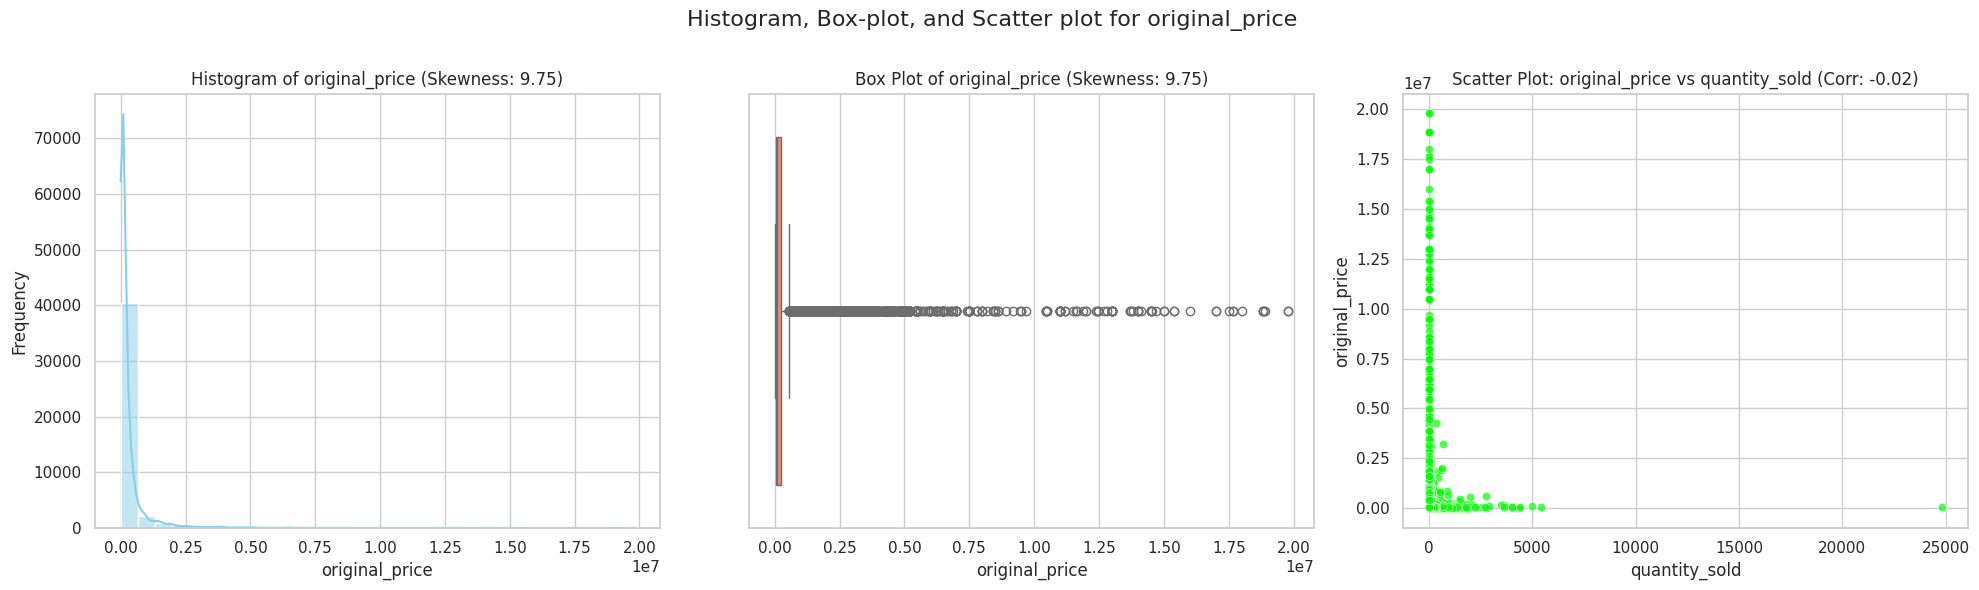

In [27]:
analyse_numerical(Viet_data2, 'original_price','quantity_sold')


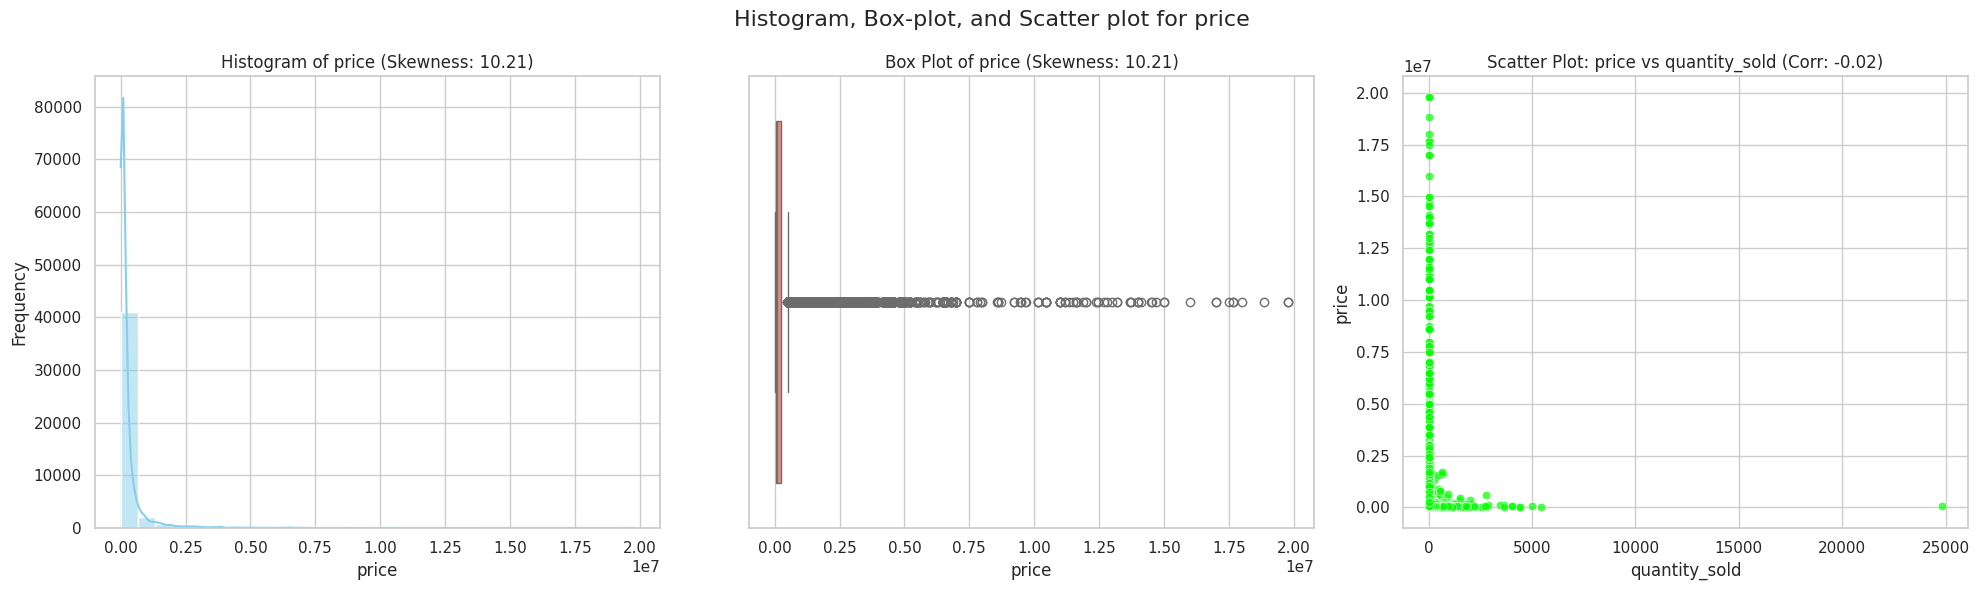

In [28]:
analyse_numerical(Viet_data2, 'price','quantity_sold')

* Higher quanity is generally observed when the price is low

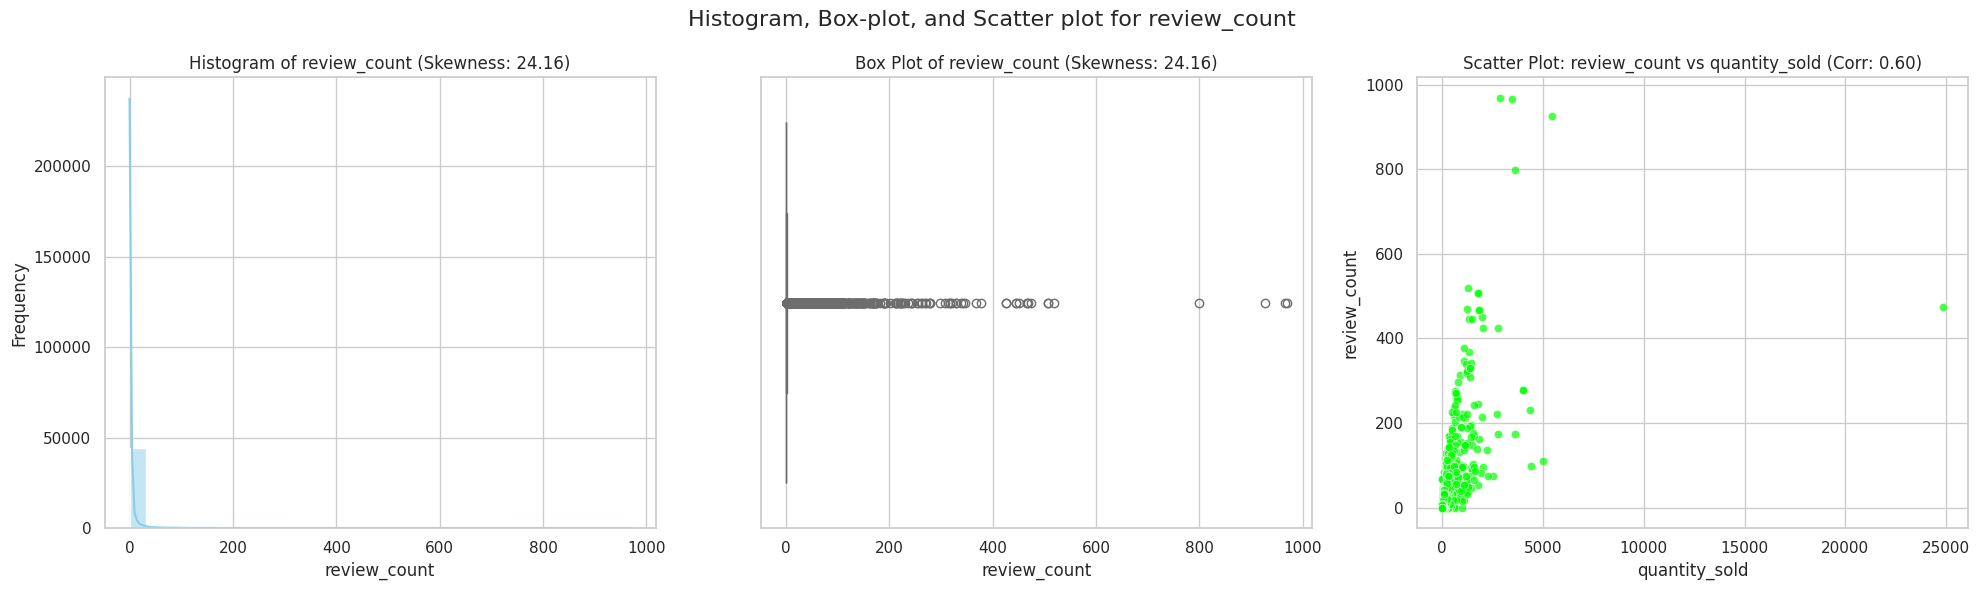

In [29]:
analyse_numerical(Viet_data2, 'review_count','quantity_sold')

* quanity increases as number of reviews increase

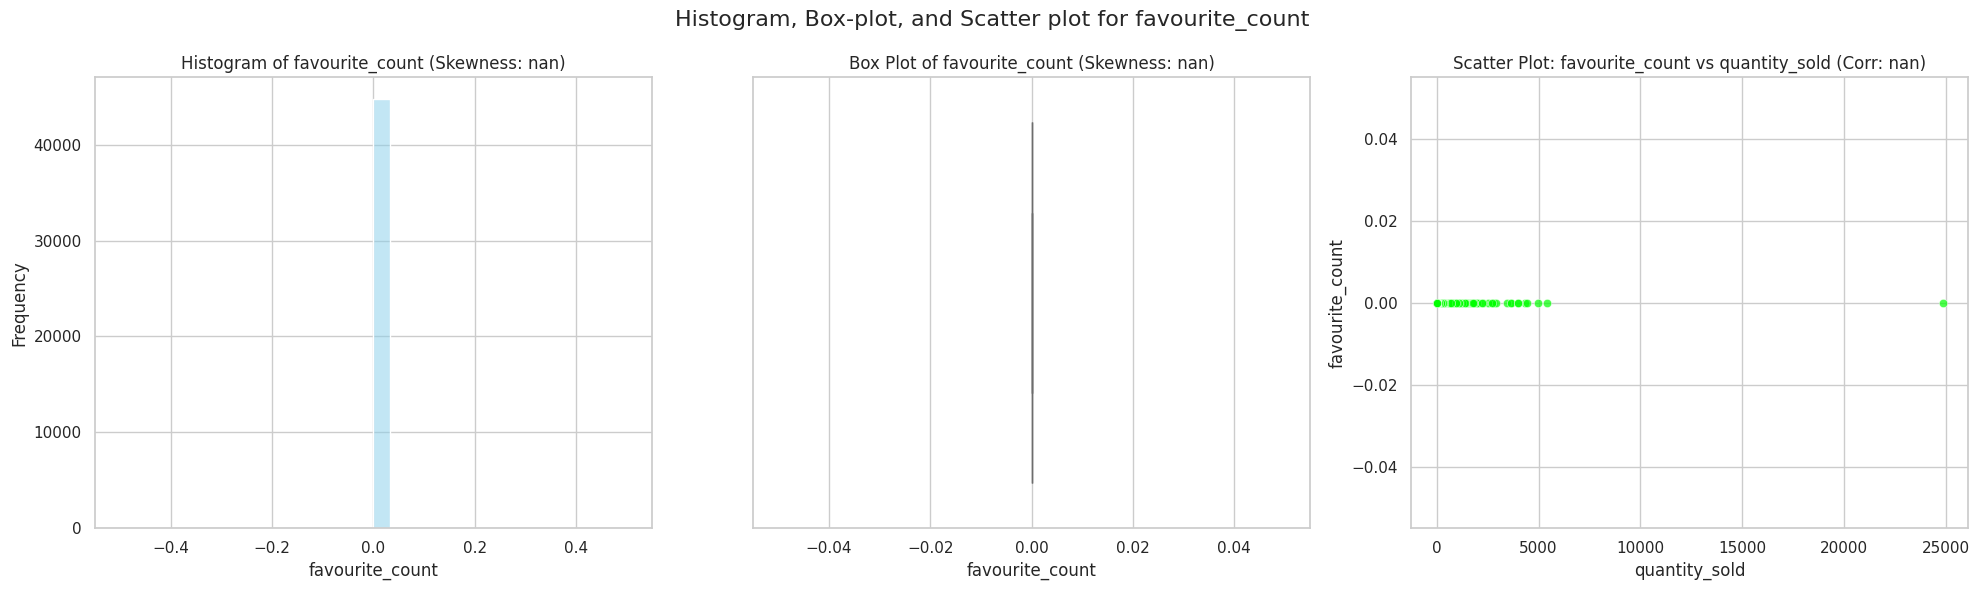

In [30]:
analyse_numerical(Viet_data2, 'favourite_count','quantity_sold')

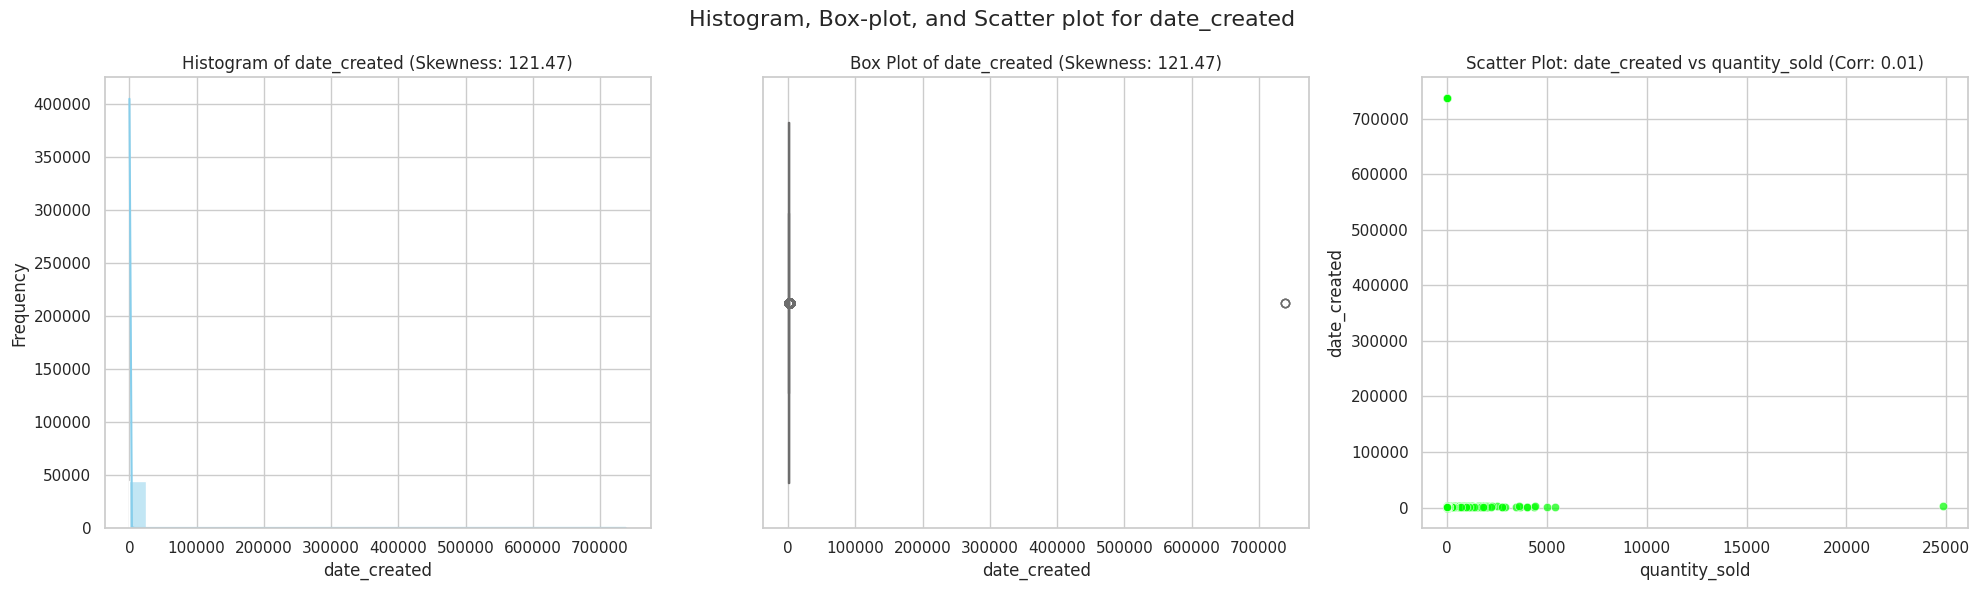

In [31]:
analyse_numerical(Viet_data2, 'date_created','quantity_sold')

* Date created is mostly 0, but have one extreme outlier within date created. 

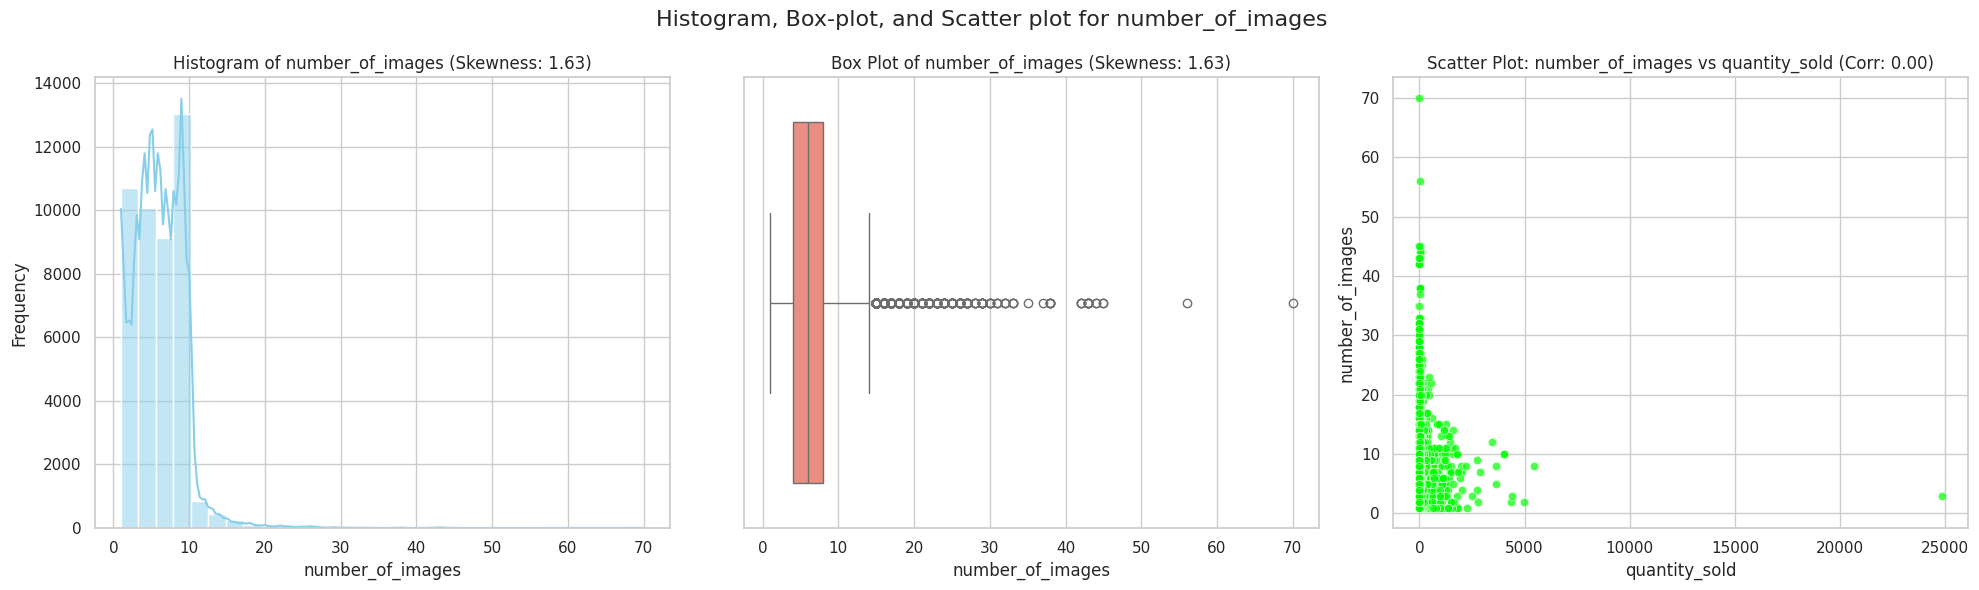

In [32]:
analyse_numerical(Viet_data2, 'number_of_images','quantity_sold')

* Number of images does not affect the quantity

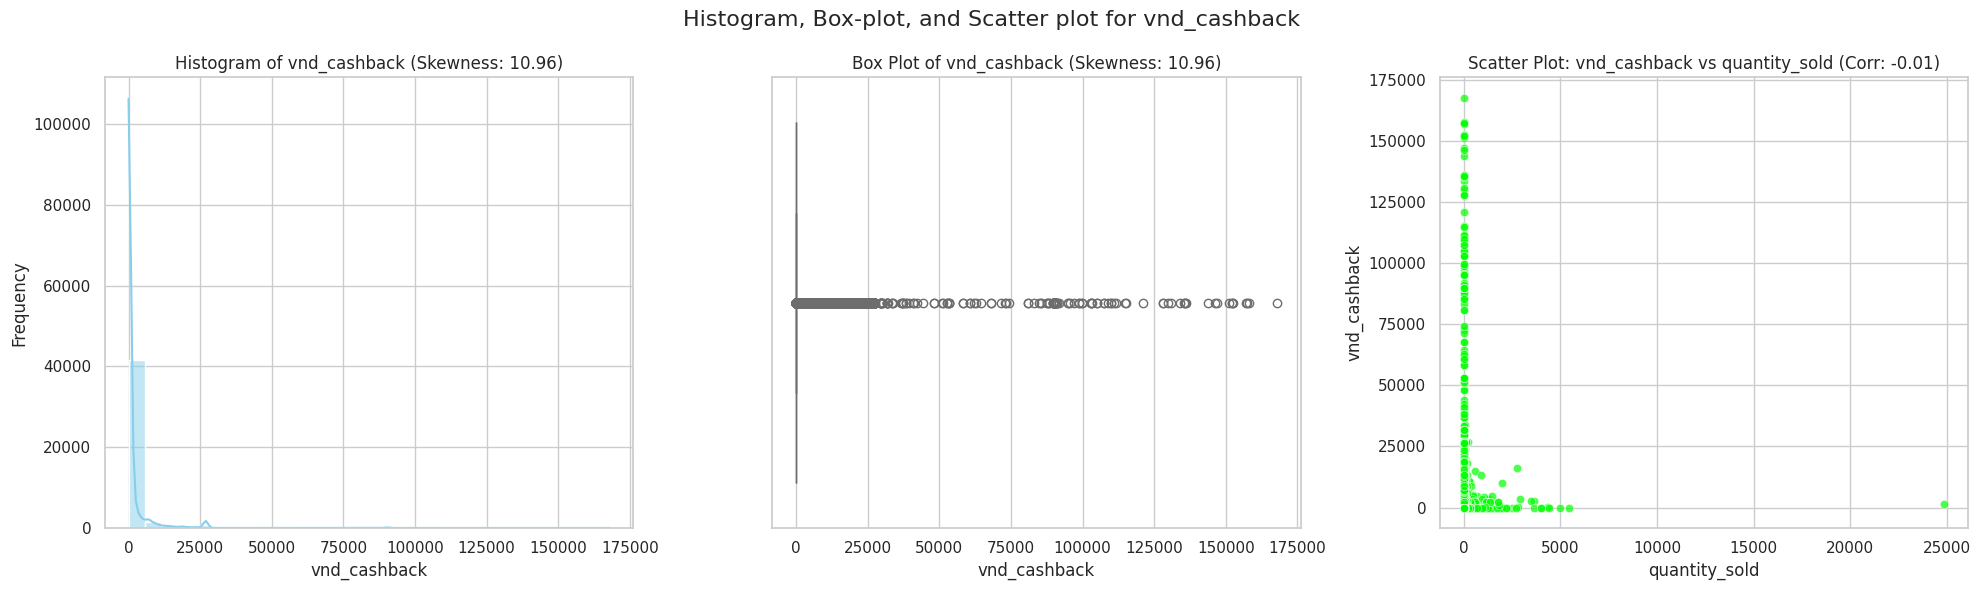

In [33]:
analyse_numerical(Viet_data2, 'vnd_cashback','quantity_sold')

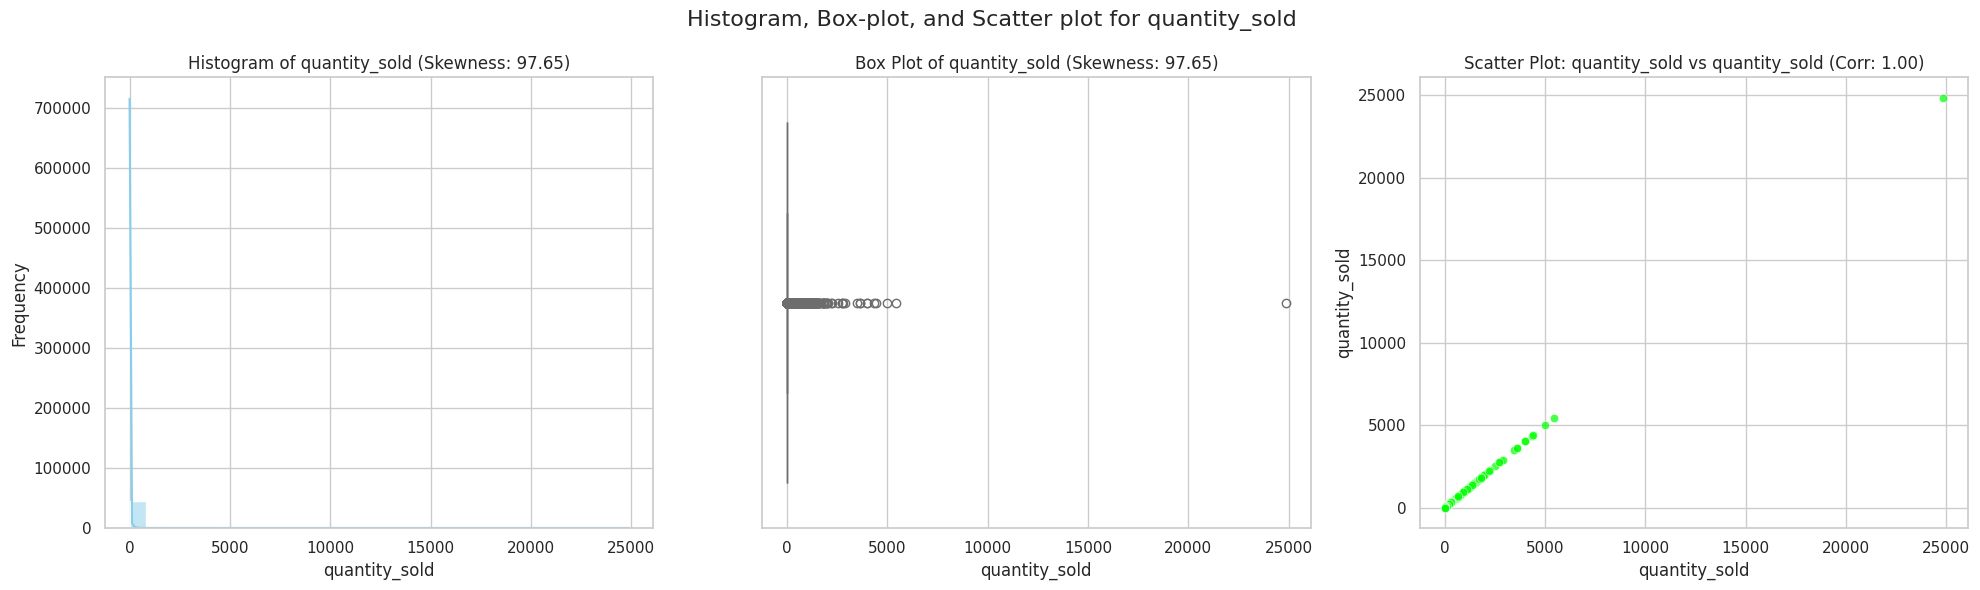

In [34]:
analyse_numerical(Viet_data2, 'quantity_sold','quantity_sold')

In [35]:
# we can create a new column to find out the difference between the original price and the selling price to know if the difference in the pricing will affect the quantity sold

# Create a new column for price difference
Viet_data3 = Viet_data2.withColumn("price_difference", col("original_price") - col("price"))

# Show the updated DataFrame
Viet_data3.show()

+---------+--------------------+--------------------+--------------+-----+----------------+------+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+----------------+
|       id|                name|         description|original_price|price|fulfillment_type| brand|review_count|rating_average|favourite_count|pay_later|      current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|price_difference|
+---------+--------------------+--------------------+--------------+-----+----------------+------+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+----------------+
|179731375|Women's backpack ...|Women's thick lea...|         14250|14250|        dropship|   OEM|           0|           0.0|              0|    false|       Thien A

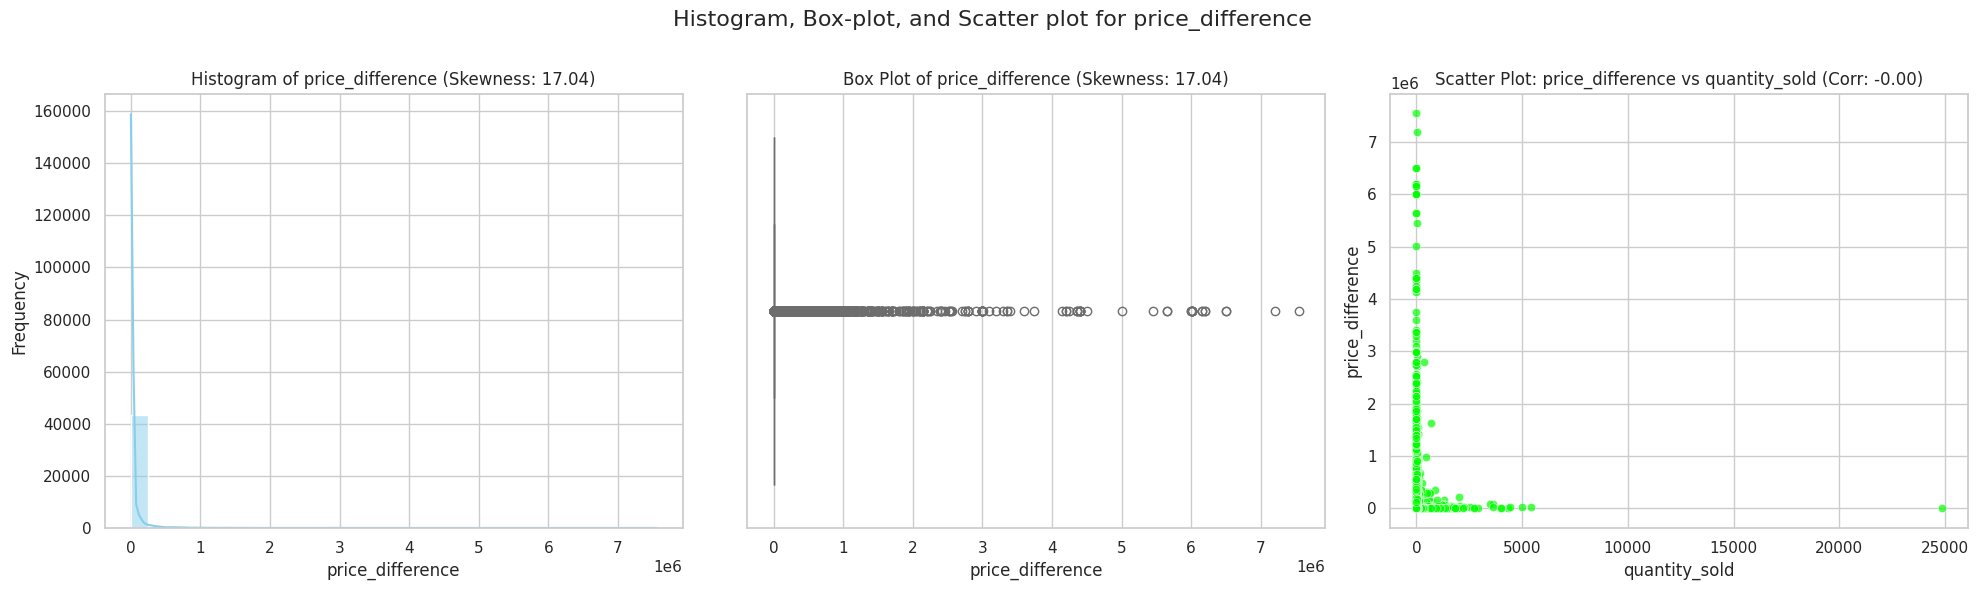

In [36]:
analyse_numerical(Viet_data3, 'price_difference','quantity_sold')

* there is no relationship between the difference in prices and quantity sold

In [37]:
## Exmaining the outliers in date_created

# Sort the DataFrame by 'date_created' in descending order
sorted_viet_date = Viet_data3.orderBy(desc("date_created"))

# Show the sorted DataFrame
sorted_viet_date.show()

# find out the importance of this var in determining the quantity (low importance -> drop the var)
# conduct outlier trimming for this var


+------+--------------------+--------------------+--------------+------+----------------+-------------+------------+--------------+---------------+---------+-------------------+------------+----------------+------------+---------+-------------------+-------------+----------------+
|    id|                name|         description|original_price| price|fulfillment_type|        brand|review_count|rating_average|favourite_count|pay_later|     current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|price_difference|
+------+--------------------+--------------------+--------------+------+----------------+-------------+------------+--------------+---------------+---------+-------------------+------------+----------------+------------+---------+-------------------+-------------+----------------+
|497990|Backpack Mikkor P...|Backpack Mikkor P...|        349300|349300|        dropship|       Mikkor|           4|           4.3|              0|     tr

* Based on the data dictionary, `date_created` is the number of days from last update date and created date. 
* It is not realistic to have a `date_created` that is 738076 days, this is equivalent to 2022 years... Hence it should be considered as a data entry error and outlier trimming has to be done.

In [38]:
# Extract the Numerical schema fields
numerical_vars  = []

# Define the schema fields manually or dynamically
schema_fields = Viet_data3.schema.fields

# Loop through the schema and classify variables
for field in schema_fields:
    if field.dataType.typeName() == "integer":
        numerical_vars.append(field.name)

print("Numerical Variables:", numerical_vars)

Numerical Variables: ['id', 'original_price', 'price', 'review_count', 'favourite_count', 'date_created', 'number_of_images', 'vnd_cashback', 'quantity_sold', 'price_difference']


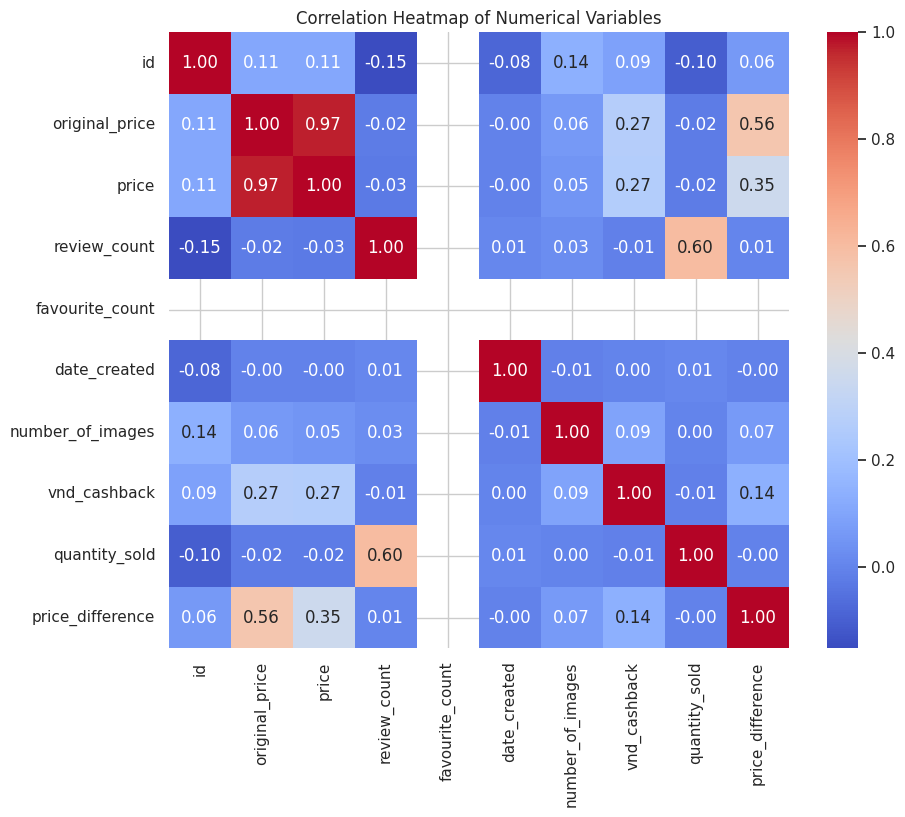

In [39]:
def heatmap(df, numerical_vars):

    # Compute correlation matrix
    corr_matrix = []
    for col1 in numerical_vars:
        row = []
        for col2 in numerical_vars:
            corr_value = df.stat.corr(col1, col2)  # Compute correlation between col1 and col2
            row.append(corr_value)
        corr_matrix.append(row)

    # Convert to numpy array for visualization
    corr_matrix = np.array(corr_matrix)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", xticklabels=numerical_vars, yticklabels=numerical_vars, cmap="coolwarm")
    plt.title("Correlation Heatmap of Numerical Variables")
    plt.tight_layout



heatmap(Viet_data3, numerical_vars)

In [40]:
# Sort the DataFrame by 'quantity_sold' in descending order
sorted_viet = Viet_data3.orderBy(desc("quantity_sold"))

# Show the sorted DataFrame
sorted_viet.show()

+---------+--------------------+--------------------+--------------+------+----------------+---------+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+----------------+
|       id|                name|         description|original_price| price|fulfillment_type|    brand|review_count|rating_average|favourite_count|pay_later|      current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|price_difference|
+---------+--------------------+--------------------+--------------+------+----------------+---------+------------+--------------+---------------+---------+--------------------+------------+----------------+------------+---------+-------------------+-------------+----------------+
|   626827|Unisex Laza TXTK3...|Unisex Laza TXTK3...|         60000| 60000|        dropship|     LAZA|         474|           4.1|              0|    fals

In [41]:
# finding out the top selling brand

# Group by 'brand' and calculate the total quantity sold
aggregated_brand_df = Viet_data3.groupBy("brand").agg(sum("quantity_sold").alias("total_quantity_sold"))

top_brand_df = aggregated_brand_df.orderBy(desc("total_quantity_sold"))
bottom_brand_df = aggregated_brand_df.orderBy(asc("total_quantity_sold"))

# Show the top brand
top_brand_df.show(5)

+------+-------------------+
| brand|total_quantity_sold|
+------+-------------------+
|   OEM|             353840|
| HARAS|              32055|
|  LAZA|              24854|
|Laceva|              17118|
|buybox|              16116|
+------+-------------------+
only showing top 5 rows



In [42]:
# Show the bottom brand
bottom_brand_df.show(5)

+------------------+-------------------+
|             brand|total_quantity_sold|
+------------------+-------------------+
|          TakyHome|                  0|
|          G&B Dell|                  0|
|            NHÀ MỊ|                  0|
|               Ito|                  0|
|GREENFIELDS COFFEE|                  0|
+------------------+-------------------+
only showing top 5 rows



In [43]:
# finding out the top selling seller 

# Group by 'brand' and calculate the total quantity sold
aggregated_seller_df = Viet_data3.groupBy("current_seller").agg(sum("quantity_sold").alias("total_quantity_sold"))

top_seller_df = aggregated_seller_df.orderBy(desc("total_quantity_sold"))
bottom_seller_df = aggregated_seller_df.orderBy(asc("total_quantity_sold"))

# Show the top brand
top_seller_df.show(5)

+--------------------+-------------------+
|      current_seller|total_quantity_sold|
+--------------------+-------------------+
|           Harasmall|              33274|
| Laza Official Store|              26993|
|            Jay_shop|              23904|
|Laceva Official S...|              17118|
|Buybox shoes acce...|              16067|
+--------------------+-------------------+
only showing top 5 rows



In [44]:
# Show the bottom brand
bottom_seller_df.show(5)

+--------------------+-------------------+
|      current_seller|total_quantity_sold|
+--------------------+-------------------+
|Shop accessories ...|                  0|
|Anh Khoa Fashion ...|                  0|
|Saigon underwear ...|                  0|
|  Gia Dung dth store|                  0|
|Hanoi underwear w...|                  0|
+--------------------+-------------------+
only showing top 5 rows



In [45]:
aggregated_seller_df.show(1)


+--------------+-------------------+
|current_seller|total_quantity_sold|
+--------------+-------------------+
|    An An Shop|                 80|
+--------------+-------------------+
only showing top 1 row



24/12/14 23:26:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Cluster Centers:
Cluster 0: [-0.0962389  -0.06372854]
Cluster 1: [6.31514082 3.48338076]
Cluster 2: [15.1259508  47.03404493]


/tmp/ipykernel_250888/3946885211.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


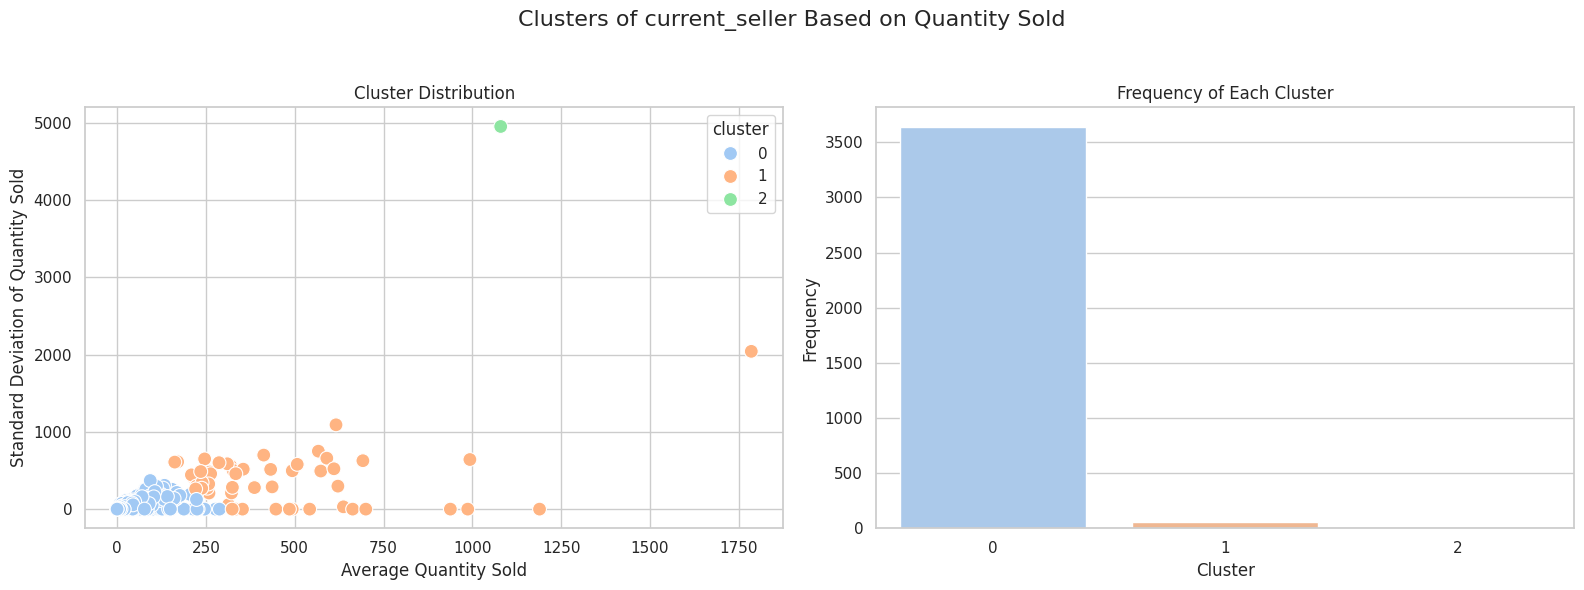

+------------------+------------------+------------------+--------------------+-----------------------+-------+
|    current_seller| avg_quantity_sold| std_quantity_sold|    quantity_metrics|scaled_quantity_metrics|cluster|
+------------------+------------------+------------------+--------------------+-----------------------+-------+
|        An An Shop| 5.714285714285714|10.350983390135314|[5.71428571428571...|   [-0.1456080082047...|      0|
|Hien Tu Stationery|1.6666666666666667|1.5275252316519468|[1.66666666666666...|   [-0.2031621268436...|      0|
+------------------+------------------+------------------+--------------------+-----------------------+-------+
only showing top 2 rows



In [ ]:

def k_means_sd(Viet_data3,var):
    # Aggregate data by mean and standard deviation
    var_summary = Viet_data3.groupBy(var).agg(
        mean("quantity_sold").alias("avg_quantity_sold"),
        stddev("quantity_sold").alias("std_quantity_sold")
    )
    
    # Replace null stddev values with 0 for groups with only one observation
    var_summary = var_summary.fillna({"std_quantity_sold": 0})

    # Normalize the data
    assembler = VectorAssembler(inputCols=["avg_quantity_sold", "std_quantity_sold"], outputCol="quantity_metrics")
    assembled_data = assembler.transform(var_summary)
    scaler = StandardScaler(inputCol="quantity_metrics", outputCol="scaled_quantity_metrics", withStd=True, withMean=True)
    scaler_model = scaler.fit(assembled_data)
    scaled_data = scaler_model.transform(assembled_data)

    # Apply K-means clustering
    kmeans = KMeans(featuresCol="scaled_quantity_metrics", predictionCol="cluster", k=3, seed=42)
    model = kmeans.fit(scaled_data)
    clustered_data = model.transform(scaled_data)

    # Collect the data for visualization
    clustered_data_pd = clustered_data.select(var, "avg_quantity_sold", "std_quantity_sold", "cluster").toPandas()

    # Display cluster centers
    print("Cluster Centers:")
    for idx, center in enumerate(model.clusterCenters()):
        print(f"Cluster {idx}: {center}")

    # Visualize the clusters
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plt.suptitle(f"Clusters of {var} Based on Quantity Sold", fontsize=16)

    # Scatter plot: Clusters of data points
    sns.scatterplot(
        data=clustered_data_pd,
        x="avg_quantity_sold",
        y="std_quantity_sold",
        hue="cluster",
        palette="pastel",
        s=100,
        ax=axes[0]
    )
    axes[0].set_title("Cluster Distribution")
    axes[0].set_xlabel("Average Quantity Sold")
    axes[0].set_ylabel("Standard Deviation of Quantity Sold")

    # Bar plot: Frequency of each cluster
    cluster_counts = clustered_data_pd["cluster"].value_counts().sort_index()
    sns.barplot(
        x=cluster_counts.index,
        y=cluster_counts.values,
        palette="pastel",
        ax=axes[1]
    )
    axes[1].set_title("Frequency of Each Cluster")
    axes[1].set_xlabel("Cluster")
    axes[1].set_ylabel("Frequency")

    # Adjust layout and show the plots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show()

    # Save cluster assignments back to the Spark DataFrame
    clustered_data.show(2)

    # Return the model and clustered data for further use
    return model, clustered_data


kmeans_brand_model, clustered_sellers = k_means_sd(Viet_data3,'current_seller')



In [47]:
#there is only one observation in cluster 2 
cluster_2_data = clustered_sellers.filter(clustered_sellers["cluster"] == 2)

# Show the rows with cluster value 2
cluster_2_data.show()

+-------------------+-----------------+-----------------+--------------------+-----------------------+-------+
|     current_seller|avg_quantity_sold|std_quantity_sold|    quantity_metrics|scaled_quantity_metrics|cluster|
+-------------------+-----------------+-----------------+--------------------+-----------------------+-------+
|Laza Official Store|          1079.72| 4953.87053659392|[1079.72,4953.870...|   [15.1259507950527...|      2|
+-------------------+-----------------+-----------------+--------------------+-----------------------+-------+



In [48]:
# function to show the quantity sold by variables

def quantity_sold(Viet_data3, var):
    # Aggregate `quantity_sold` by var and sort by total_quantity_sold in descending order
    aggregated_data = Viet_data3.groupBy(var) \
        .agg(avg("quantity_sold").alias("total_quantity_sold")) \
        .orderBy(col("total_quantity_sold").desc())

    # Collect data to Python lists
    aggregated_data_list = aggregated_data.collect()
    variable = [row[var] for row in aggregated_data_list]
    total_quantity_sold = [row['total_quantity_sold'] for row in aggregated_data_list]

    # Plot using Seaborn
    plt.figure(figsize=(12, 6))
    sns.barplot(x=variable, y=total_quantity_sold, color='blue',edgecolor='blue')  # Seaborn bar plot
    plt.title(f"Quantity Sold by {var} (Descending Order)", fontsize=16)
    plt.xlabel(f"{var}", fontsize=12)
    plt.ylabel("Total Quantity Sold", fontsize=12)
    plt.xticks([])  # Hide x-axis tick labels
    plt.tight_layout()
    plt.show()

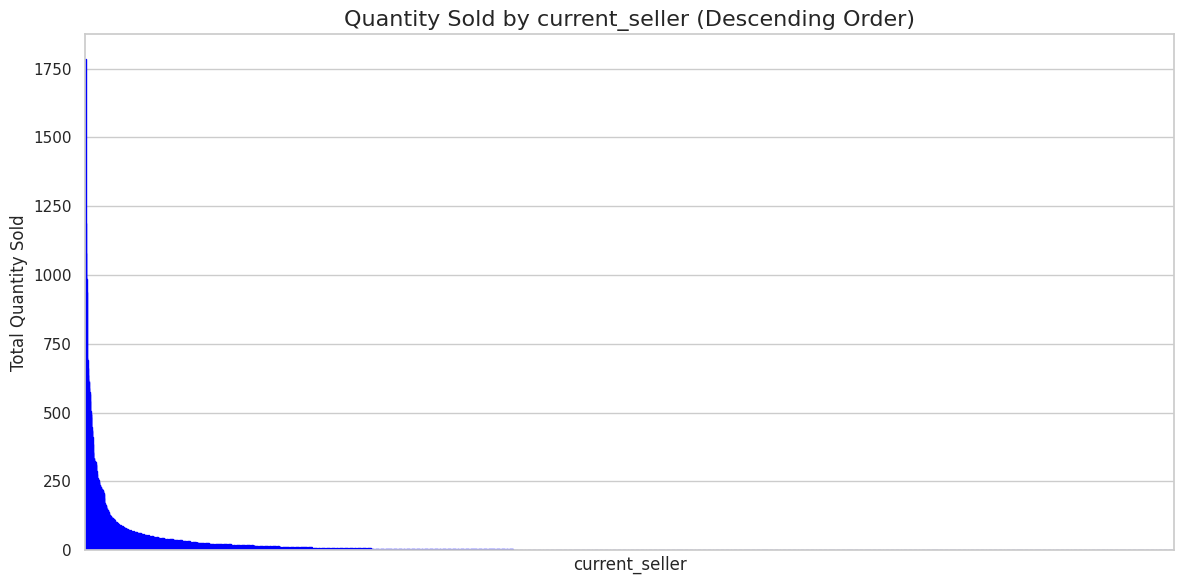

In [49]:
quantity_sold(Viet_data3,'current_seller')

In [50]:
# there are sellers with extremely high quantity sold while there are a lot more sellers with quantity sold that is low in comparison. 
# set 100 to be the threshold for lower-performing seller, and group sellers with total quantity sold that is less than this to be 'Others'

# Aggregate sales by seller
sellers_data = Viet_data3.groupBy("current_seller") \
    .agg(sum("quantity_sold").alias("total_quantity_sold"))

# Mark sellers with less than 100 sales as "Others"
sellers_data = sellers_data.withColumn(
    "updated_seller",
    when(col("total_quantity_sold") < 100, "Others").otherwise(col("current_seller"))
)

# Join the updated seller column back to the original dataset
Viet_data3_updated = Viet_data3.join(
    sellers_data.select("current_seller", "updated_seller"),
    on="current_seller",
    how="left"
)

Viet_data3_updated.show(5)

+--------------------+---------+--------------------+--------------------+--------------+-----+----------------+-----+------------+--------------+---------------+---------+------------+----------------+------------+---------+-------------------+-------------+----------------+--------------+
|      current_seller|       id|                name|         description|original_price|price|fulfillment_type|brand|review_count|rating_average|favourite_count|pay_later|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|price_difference|updated_seller|
+--------------------+---------+--------------------+--------------------+--------------+-----+----------------+-----+------------+--------------+---------------+---------+------------+----------------+------------+---------+-------------------+-------------+----------------+--------------+
|       Thien An Balo|179731375|Women's backpack ...|Women's thick lea...|         14250|14250|        dropship|  OEM|      

In [51]:
#view shape of the dataframe before dropping
shape(Viet_data3_updated)

(44804, 20)


Cluster Centers:
Cluster 0: [-0.03852074 -0.03369315]
Cluster 1: [19.14466594  0.2658106 ]
Cluster 2: [11.05559761 26.14962105]


/tmp/ipykernel_250888/3946885211.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


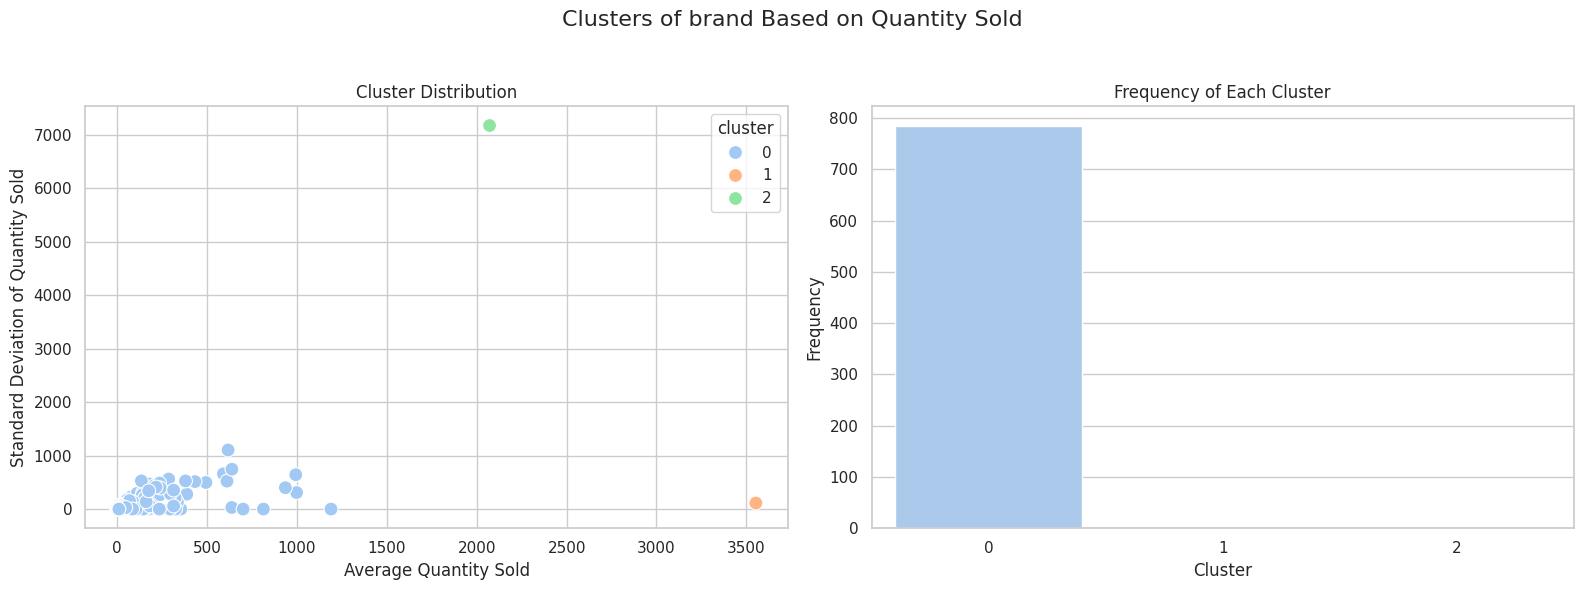

+----------+-----------------+-----------------+----------------+-----------------------+-------+
|     brand|avg_quantity_sold|std_quantity_sold|quantity_metrics|scaled_quantity_metrics|cluster|
+----------+-----------------+-----------------+----------------+-----------------------+-------+
|       TNP|              0.0|              0.0|       (2,[],[])|   [-0.2505380425376...|      0|
|Sportslink|              2.0|              0.0|       [2.0,0.0]|   [-0.2396203932397...|      0|
+----------+-----------------+-----------------+----------------+-----------------------+-------+
only showing top 2 rows



In [52]:
kmeans_model, clustered_brand = k_means_sd(Viet_data3_updated,'brand')

Since most of the brand and sellers have low standard deviation in their quantity sold across products, we can conduct target-mean encoding to encode `brand` and `current_seller` later, as there might be a direct relationship with quantity sold due to popularity. 
* only conduct using the training data to find the mean

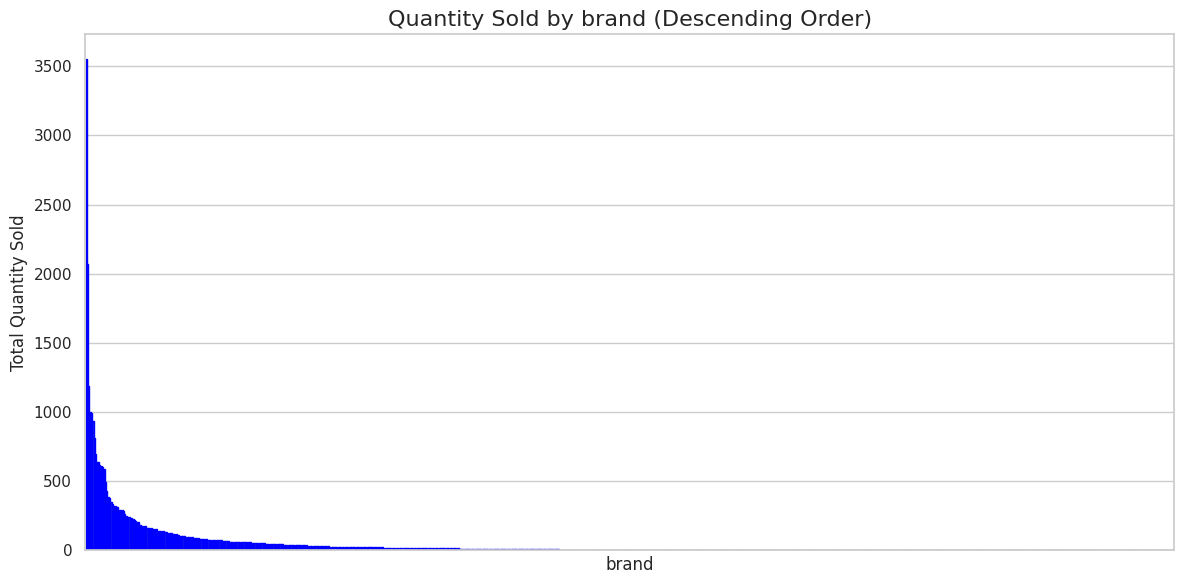

In [53]:
quantity_sold(Viet_data3_updated,'brand')

In [54]:
# set the 100 to be the threshold for lower-performing brands, and group brands with total quantity sold that is less than this to be 'Others'

# Aggregate sales by seller
brand_data = Viet_data3.groupBy("brand") \
    .agg(sum("quantity_sold").alias("total_quantity_sold"))

# Mark sellers with less than 100 sales as "Others"
brand_data = brand_data.withColumn(
    "updated_brand",
    when(col("total_quantity_sold") < 100, "Others").otherwise(col("brand"))
)

# Join the updated seller column back to the original dataset
Viet_data3_updated = Viet_data3_updated.join(
    brand_data.select("brand", "updated_brand"),
    on="brand",
    how="left"
)

Viet_data3_updated.show(5)

+-----+--------------------+---------+--------------------+--------------------+--------------+-----+----------------+------------+--------------+---------------+---------+------------+----------------+------------+---------+-------------------+-------------+----------------+--------------+-------------+
|brand|      current_seller|       id|                name|         description|original_price|price|fulfillment_type|review_count|rating_average|favourite_count|pay_later|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|price_difference|updated_seller|updated_brand|
+-----+--------------------+---------+--------------------+--------------------+--------------+-----+----------------+------------+--------------+---------------+---------+------------+----------------+------------+---------+-------------------+-------------+----------------+--------------+-------------+
|  OEM|       Thien An Balo|179731375|Women's backpack ...|Women's thick lea...|  

In [55]:
Viet_data3_updated.write.mode('overwrite').csv('viewdata.csv', header=True)


### **2.2 Data Cleansing** <a id="2-2"></a>  
[Back to Top](#top)

Errors within data
* `favourite_count` only contains one category of values, hence this feature should be removed
* Null values are only present in `rating_average` (10 Null values)
* Duplicated variable rows of data in `id`


In [56]:
# dropping the price_difference varible since it has low correlations with the target and other variables

Viet_data4 = Viet_data3.drop ("price_difference") 


In [57]:
# count the number of duplicates in the id 
grouped_df = Viet_data4.groupBy("id").count()

# Filter for groups with more than one occurrence
duplicate_rows_df = grouped_df.filter("count > 1")

# Count duplicate rows
num_duplicates = duplicate_rows_df.count()

print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 7663


In [58]:
# Drop favourite_count since it only contains one category
Viet_clean = Viet_data4.drop("favourite_count")

In [59]:
shape(Viet_data4)

(44804, 18)


In [60]:
#Remove duplicates in the 'id' column
Viet_clean = Viet_clean.dropDuplicates(["id"])

# Show the resulting DataFrame
shape(Viet_clean)

(37129, 17)


In [61]:
Viet_clean.show(5)

+------+--------------------+--------------------+--------------+-------+----------------+------+------------+--------------+---------+--------------+------------+----------------+------------+---------+-------------------+-------------+
|    id|                name|         description|original_price|  price|fulfillment_type| brand|review_count|rating_average|pay_later|current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|
+------+--------------------+--------------------+--------------+-------+----------------+------+------------+--------------+---------+--------------+------------+----------------+------------+---------+-------------------+-------------+
|565573|Sakos suitcase Ch...|Sakos Champion 5 ...|       2189000|1858000|        dropship| Sakos|           0|           0.0|     true|    Balonation|           0|               5|           0|    false|backpacks_suitcases|            1|
|565575|Sakos suitcase Sa...|Sakos Champion 6 ..

Missing Data imputation (this step is actually moved to after train test split as possible data leakage issues might occur when imputing with mean and median) 

In [62]:
Viet_clean.show(5)

+------+--------------------+--------------------+--------------+-------+----------------+------+------------+--------------+---------+--------------+------------+----------------+------------+---------+-------------------+-------------+
|    id|                name|         description|original_price|  price|fulfillment_type| brand|review_count|rating_average|pay_later|current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|
+------+--------------------+--------------------+--------------+-------+----------------+------+------------+--------------+---------+--------------+------------+----------------+------------+---------+-------------------+-------------+
|565573|Sakos suitcase Ch...|Sakos Champion 5 ...|       2189000|1858000|        dropship| Sakos|           0|           0.0|     true|    Balonation|           0|               5|           0|    false|backpacks_suitcases|            1|
|565575|Sakos suitcase Sa...|Sakos Champion 6 ..

In [63]:
missing_data(Viet_clean)

id : 0
name : 0
description : 0
original_price : 0
price : 0
fulfillment_type : 0
brand : 0
review_count : 0
rating_average : 10
pay_later : 0
current_seller : 0
date_created : 0
number_of_images : 0
vnd_cashback : 0
has_video : 0
product_type : 0
quantity_sold : 0


In [64]:
print("Stats for `rating_average`")
mean_rating = Viet_clean.select(mean(col("rating_average"))).collect()[0][0]
print(f"mean: {mean_rating}")

median_rating = Viet_clean.approxQuantile("rating_average", [0.5], 0.001)
print(f"median: {median_rating[0]}")

sd_rating = Viet_clean.select(stddev(col("rating_average"))).collect()[0][0]
print(f"standard deviation: {sd_rating}")

mode_df = ( Viet_clean.groupBy("rating_average").agg(count("rating_average").alias("count")).orderBy(col("count").desc()))
mode_rating = mode_df.first()["rating_average"]
print(f"Mode: {mode_rating}")

Stats for `rating_average`


mean: 1.357595840405173
median: 0.0
standard deviation: 2.095433879870878
Mode: 0.0


In [65]:
#try 1 dropping the null values in rating_average
# Viet_clean2 = Viet_clean.na.drop(how="any")

# shape(Viet_clean2)

#  train RMSE: 60.6197
#  train MAE: 8.0710
#  train R2: 0.8862
#  test RMSE: 87.5673
#  test MAE: 11.2551
#  test R2: 0.5696

In [66]:
# Try 2: input by mean 

# # Fill null values in 'rating_average' with the mean
# Viet_clean2 = Viet_clean.fillna({"rating_average": mean_rating})
# shape(Viet_clean2)

# train RMSE: 62.7413
#  train MAE: 8.3811
#  train R2: 0.8819
#  test RMSE: 73.3430
#  test MAE: 10.9955
#  test R2: 0.6492

In [67]:
# Try 3: input by median 
# Fill null values in 'rating_average' with the mean
# Viet_clean2 = Viet_clean.fillna({"rating_average": median_rating[0]})
# shape(Viet_clean2)

#  train RMSE: 62.6547
#  train MAE: 8.3603
#  train R2: 0.8822
#  test RMSE: 73.3687
#  test MAE: 10.9599
#  test R2: 0.6489


## **3. Data Wrangling and Transformation** <a id="3"></a>  
[Back to Top](#top)  

### **3.1 Outlier Trimming** <a id="3-1"></a>  


In [68]:
def diagnostic_plots(spark_df, variable):
    # Extract the column as a list and drop null values
    data = spark_df.select(variable).dropna().rdd.flatMap(lambda x: x).collect()

    # Check if the column is numeric
    if not all(isinstance(x, (int, float)) for x in data):
        raise ValueError(f"The column '{variable}' must be numeric for diagnostic plots.")

    # Calculate skewness
    skewness_value = skew(data)

    # Set figure size
    plt.figure(figsize=(16, 5))

    # Adjust the vertical spacing between subplots
    plt.subplots_adjust(top=0.8)
    plt.suptitle(f"Histogram, Q-Q plot, and Boxplot for {variable}", fontsize=16)

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(data, bins=30)
    plt.title(f'Histogram (Skewness: {skewness_value:.2f})')

    # Q-Q Plot
    plt.subplot(1, 3, 2)
    probplot(data, dist="norm", plot=plt)  # Corrected probplot usage
    plt.ylabel('Theoretical Quantiles')

    # Boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=data)
    plt.title('Boxplot')

    # Show the plots
    plt.show()

In [69]:
#Create a new list for cleaned data for further wrangling
Numerical_vars_C = []

# Define the schema fields manually or dynamically
schema_fields = Viet_clean.schema.fields

# Loop through the schema and classify variables
for field in schema_fields:
    # Check if the field is numeric
    if field.dataType.typeName() in ["integer", "double", "float"]:
        Numerical_vars_C.append(field.name)

print("Numerical Variables:", Numerical_vars_C)





Numerical Variables: ['id', 'original_price', 'price', 'review_count', 'rating_average', 'date_created', 'number_of_images', 'vnd_cashback', 'quantity_sold']


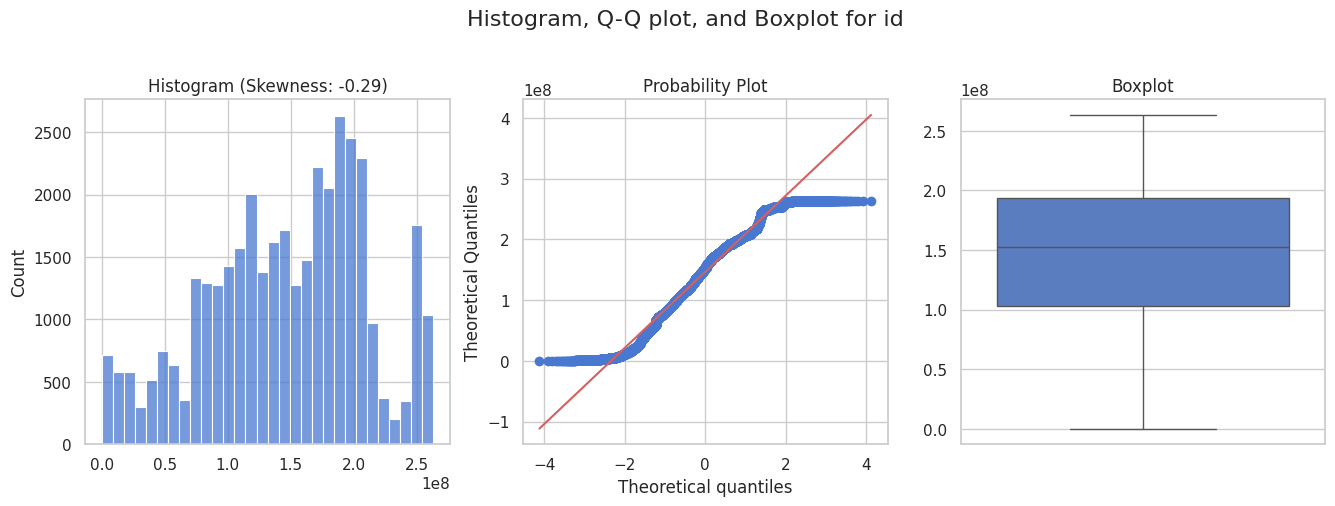

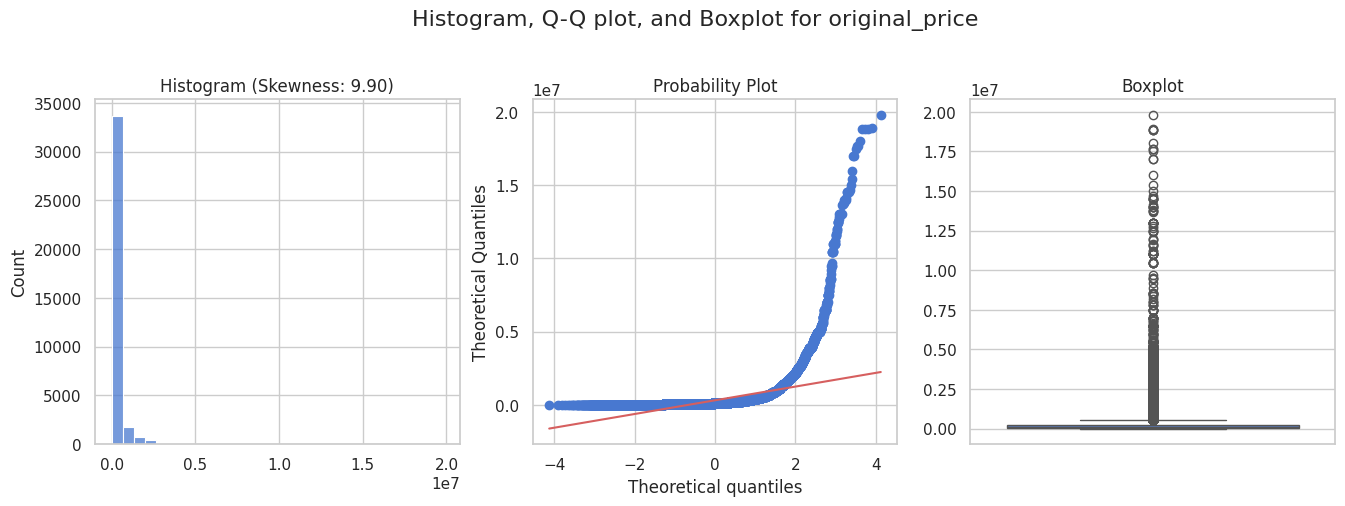

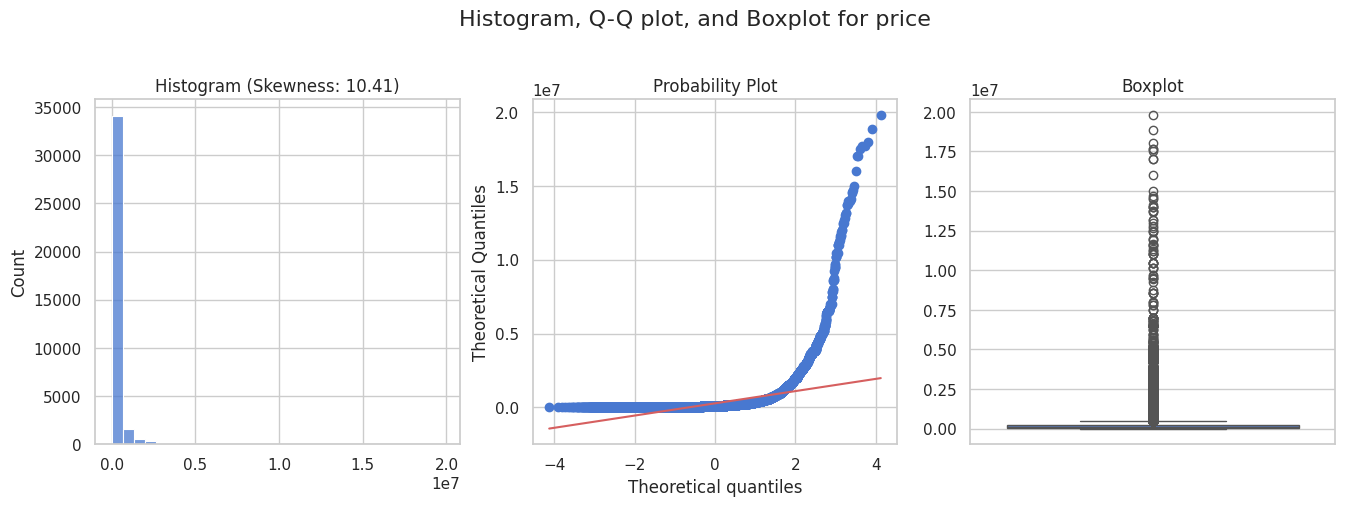

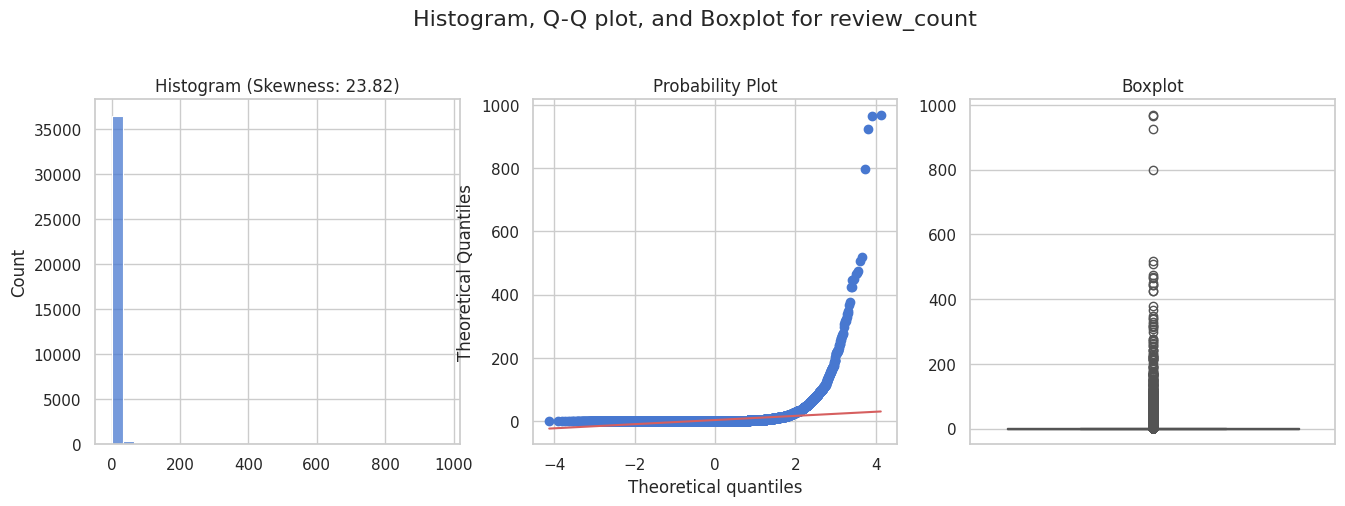

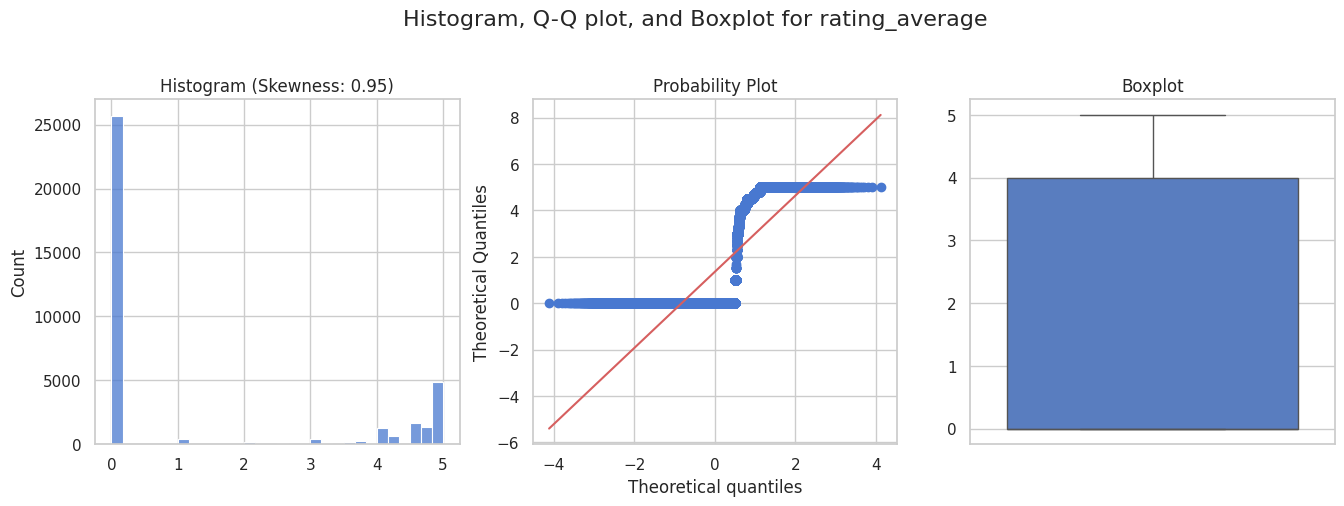

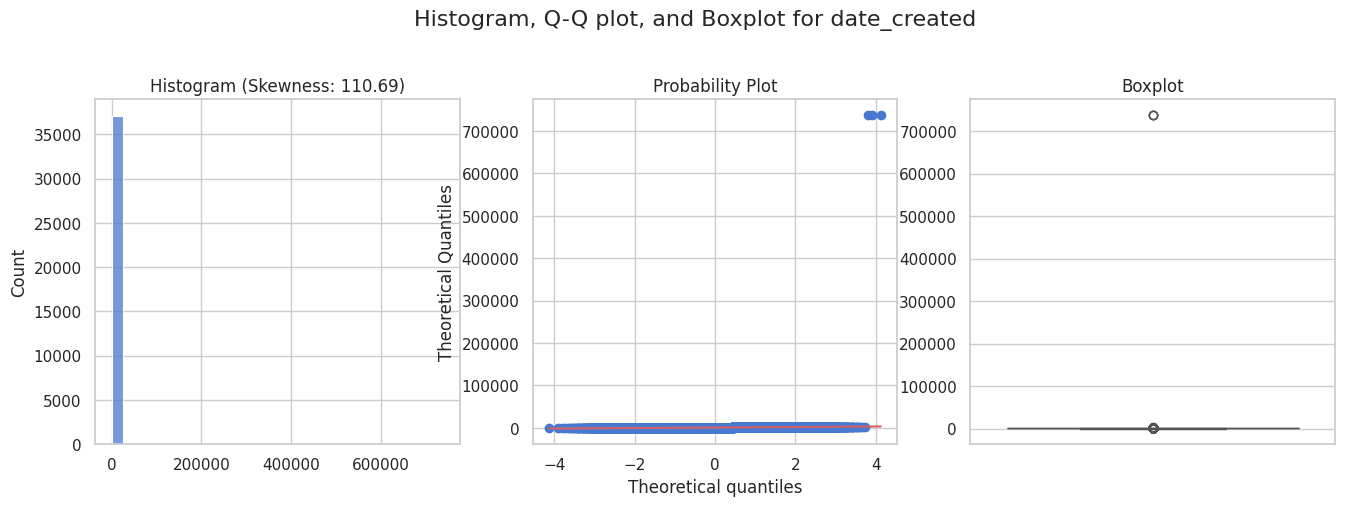

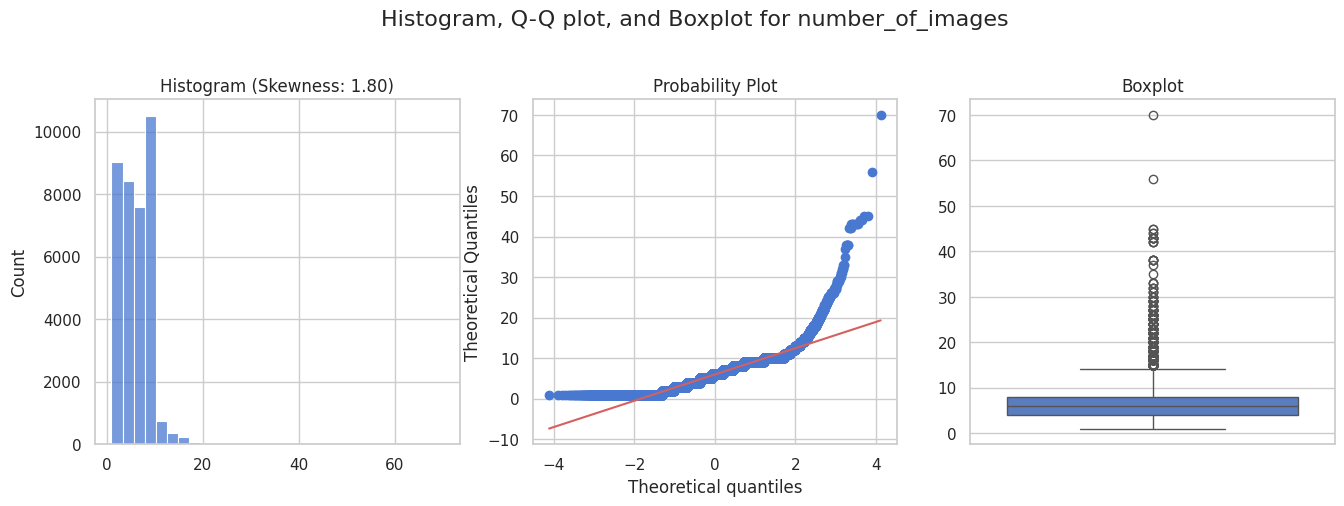

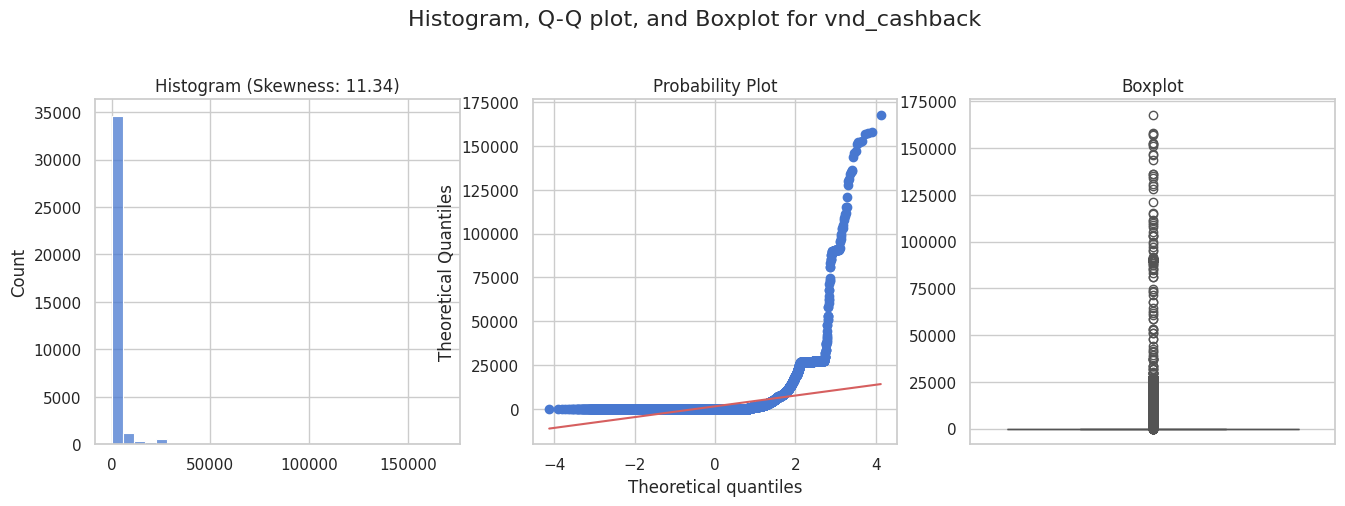

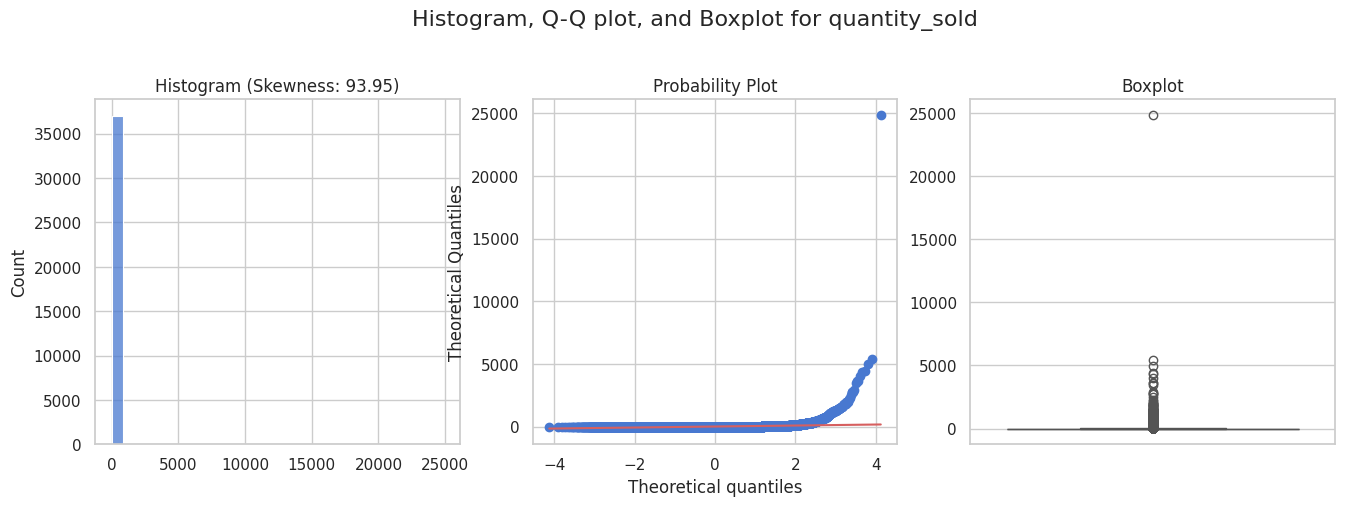

In [70]:

for num_var in Numerical_vars_C:
    diagnostic_plots(Viet_clean, num_var)

<a id="date"></a>  

* **date_created**  
(Outlier trimming is only conducted to this variable as it is proved to be a wrong entry. Outliers in other variables are not touched as they might be useful patterns in the data)

In [71]:
# conducting outlier trimming for date_created

def find_upper_boundaries(df, variable, distance):
    # Calculate the 25th and 75th quantiles
    q1, q3 = df.approxQuantile(variable, [0.25, 0.75], 0)
    IQR = q3 - q1
    upper_boundary = q3 + (IQR * distance)
    
    return upper_boundary


In [72]:
# number of reviews upper boundary
upper_limit = find_upper_boundaries(Viet_clean, 'date_created', 5)
upper_limit

3000.0

In [73]:
# Trimming the outliers within the dataset 
# Filter rows with values below the upper boundary
Viet_clean3 = Viet_clean.filter(col("date_created") <= upper_limit)

In [74]:
shape(Viet_clean3)

(37126, 17)


In [75]:
# Sort the DataFrame by 'date_created' in descending order
sorted_viet_date = Viet_clean3.orderBy(desc("date_created"))

# Show the sorted DataFrame
sorted_viet_date.show(4)

+------+--------------------+--------------------+--------------+------+----------------+--------+------------+--------------+---------+---------------+------------+----------------+------------+---------+-------------------+-------------+
|    id|                name|         description|original_price| price|fulfillment_type|   brand|review_count|rating_average|pay_later| current_seller|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|
+------+--------------------+--------------------+--------------+------+----------------+--------+------------+--------------+---------+---------------+------------+----------------+------------+---------+-------------------+-------------+
|159901|Goldcare shoe car...|Goldcare shoe car...|        206000|206000|        dropship|GoldCare|           0|           0.0|     true|       Goldcare|        2889|               2|        5480|    false|        women_shoes|            0|
|481290|Pair Wearing Edit...|Pair of Edi

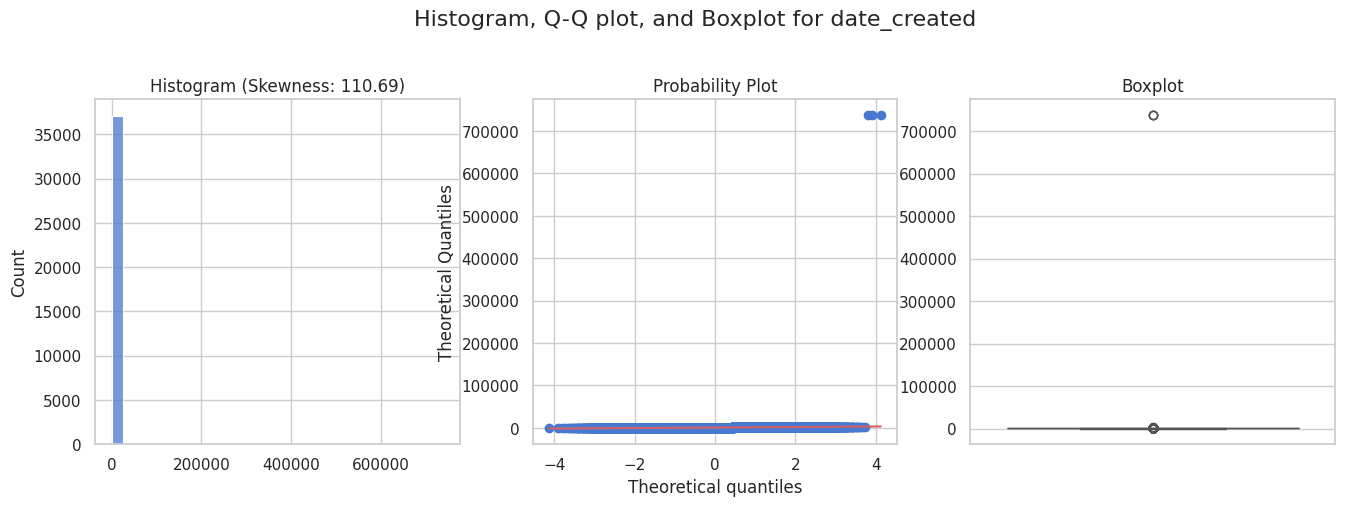

In [76]:
diagnostic_plots(Viet_clean, 'date_created')

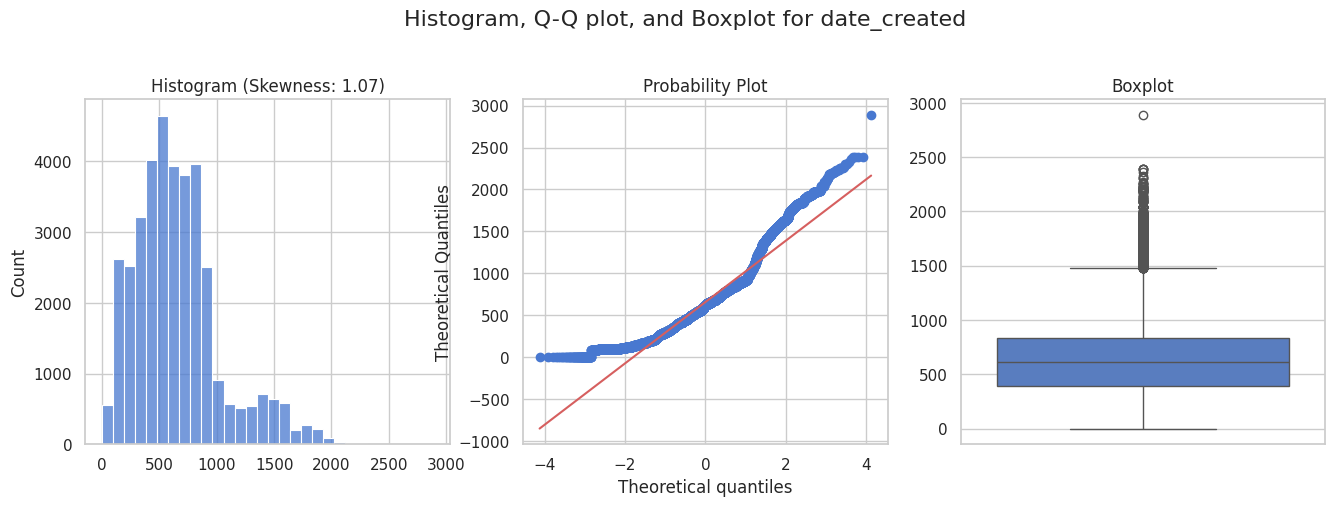

In [77]:
 diagnostic_plots(Viet_clean3, 'date_created')

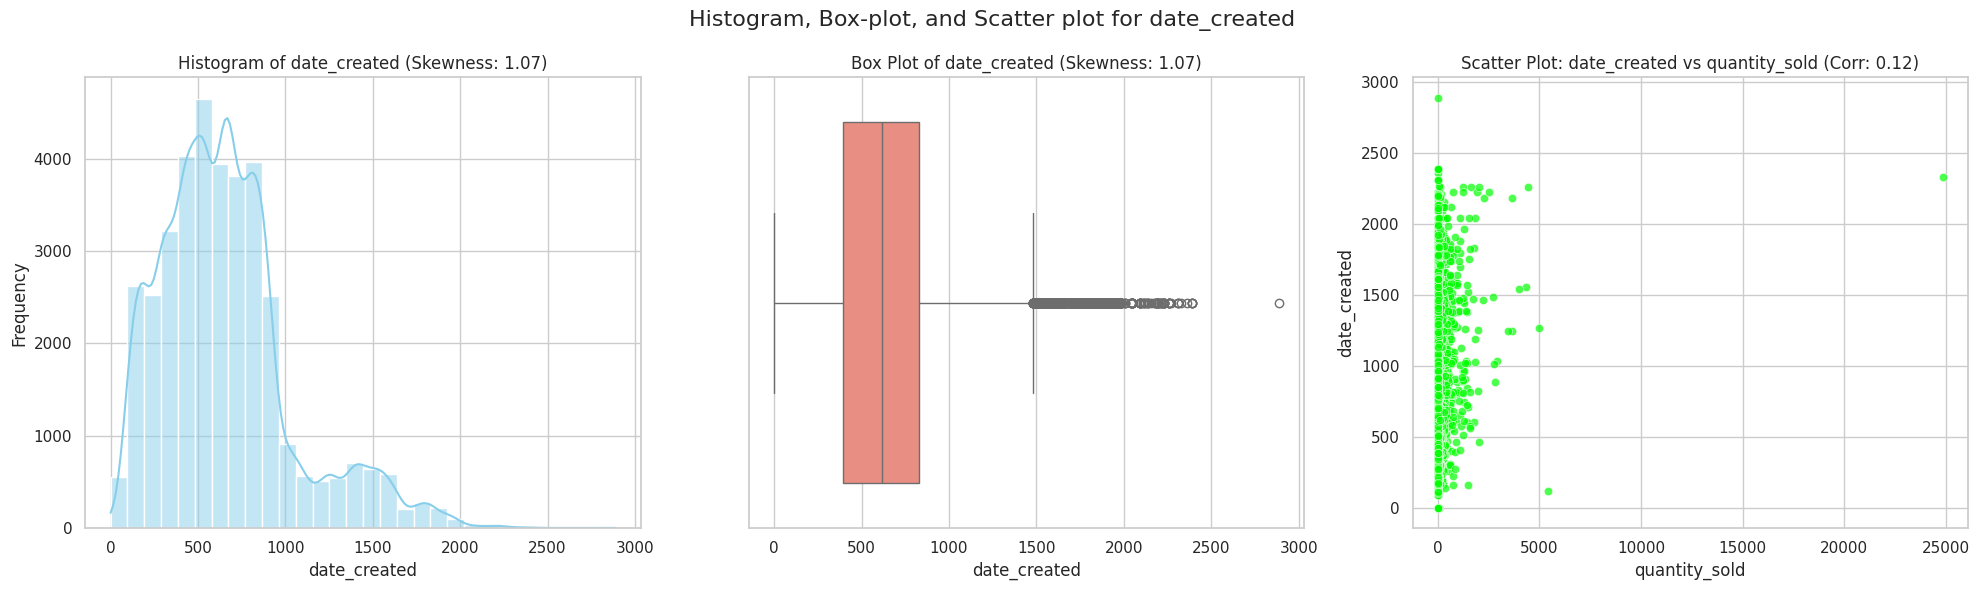

In [78]:
analyse_numerical(Viet_clean3, 'date_created','quantity_sold')

In [79]:
# # before 
#  train RMSE: 151.7493
#  train MAE: 14.4274
#  train R2: 0.3168
#  test RMSE: 81.5291
#  test MAE: 14.5519
#  test R2: 0.5406


# # After trimming extreme outliers in date created
#  train RMSE: 151.6557
#  train MAE: 15.3722
#  train R2: 0.3176
#  test RMSE: 81.3829
#  test MAE: 15.5425
#  test R2: 0.5426


### **3.2 TF_IDF** <a id="3-2a"></a>  
[Back to Top](#top)

In [80]:
# Finding out if the significance between the differnt words used in names and descriptions helps the model

# from pyspark.ml.feature import Tokenizer, HashingTF, IDF

# # Tokenize the "description" column
# description_tokenizer = Tokenizer(inputCol="description", outputCol="description_tf")
# TFIDF_df = description_tokenizer.transform(Viet_clean3)

# # Tokenize the "name" column
# name_tokenizer = Tokenizer(inputCol="name", outputCol="name_tf")
# TFIDF_df = name_tokenizer.transform(TFIDF_df)

# # Compute term frequencies for "description" using HashingTF
# description_hashing_tf = HashingTF(inputCol="description_tf", outputCol="description_raw_features", numFeatures=20)
# Viet_enc = description_hashing_tf.transform(TFIDF_df)

# # Compute term frequencies for "name" using HashingTF
# name_hashing_tf = HashingTF(inputCol="name_tf", outputCol="name_raw_features", numFeatures=20)
# Viet_enc = name_hashing_tf.transform(Viet_enc)

# # Optionally, compute IDF if needed (you can add IDF step here if required)
# # Show the result
# Viet_enc.limit(10)

# columns_to_drop = ["description_tf","name_tf"]  
# Viet_enc = Viet_enc.drop(*columns_to_drop)

# This is not conducted in the end since model did not show improvements in scores

### **3.3 Train-Test Split** <a id="3-2"></a>  
[Back to Top](#top)

In [81]:
# test with seeds such that the outlier point lies in the training set for it to generalise better with future data
# (train_data, test_data ) = Viet_enc.randomSplit([0.7, 0.3], seed=7) 
(train_data, test_data ) = Viet_clean3.randomSplit([0.7, 0.3], seed=7) 

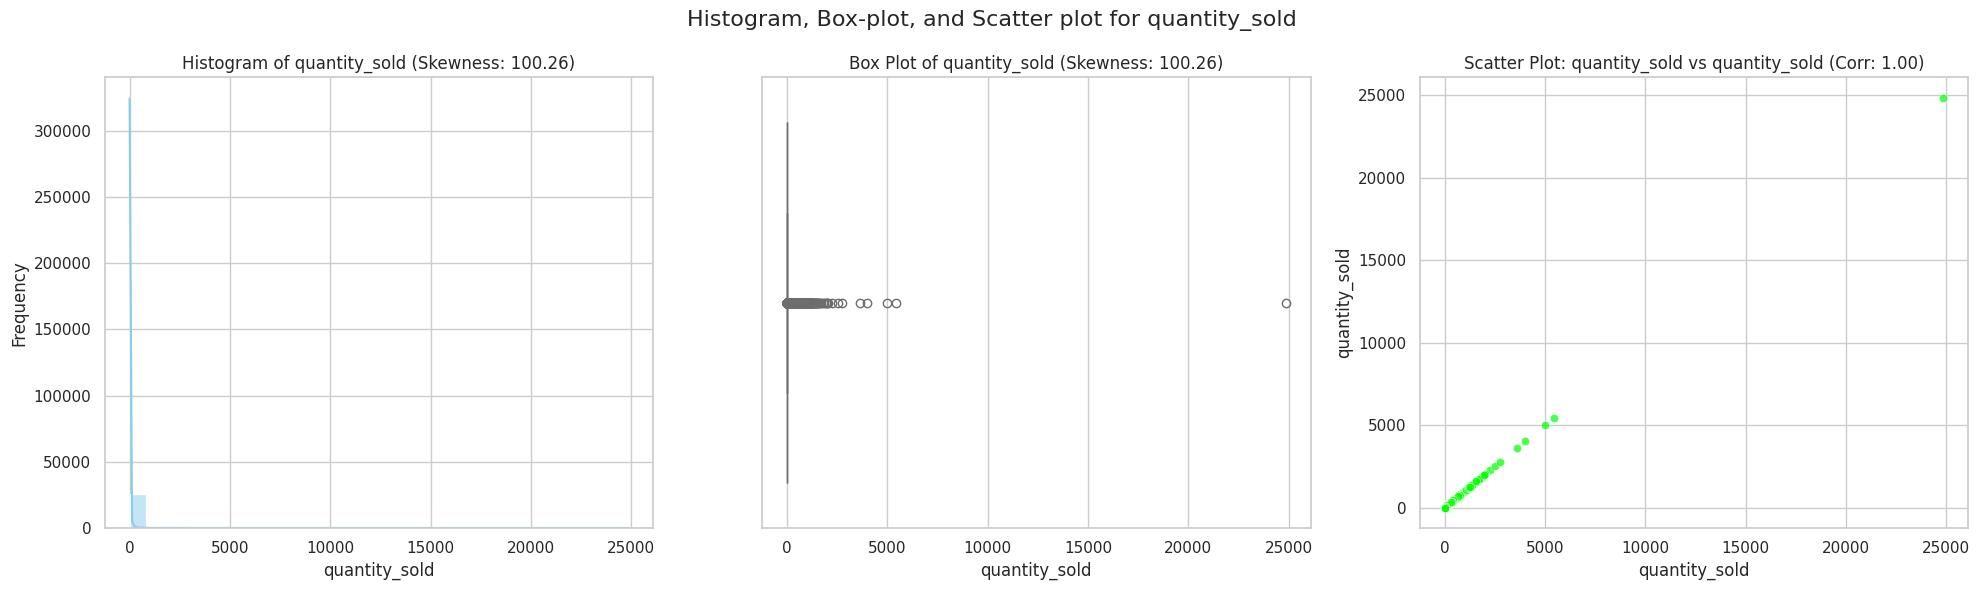

In [82]:
# show the distribution for target for both train and test to make sure that the target lies in the training set for the model to learn the patterns of possible outliers in the quantity sold
# so that it can generalise better to future unseen data
analyse_numerical(train_data, 'quantity_sold','quantity_sold')

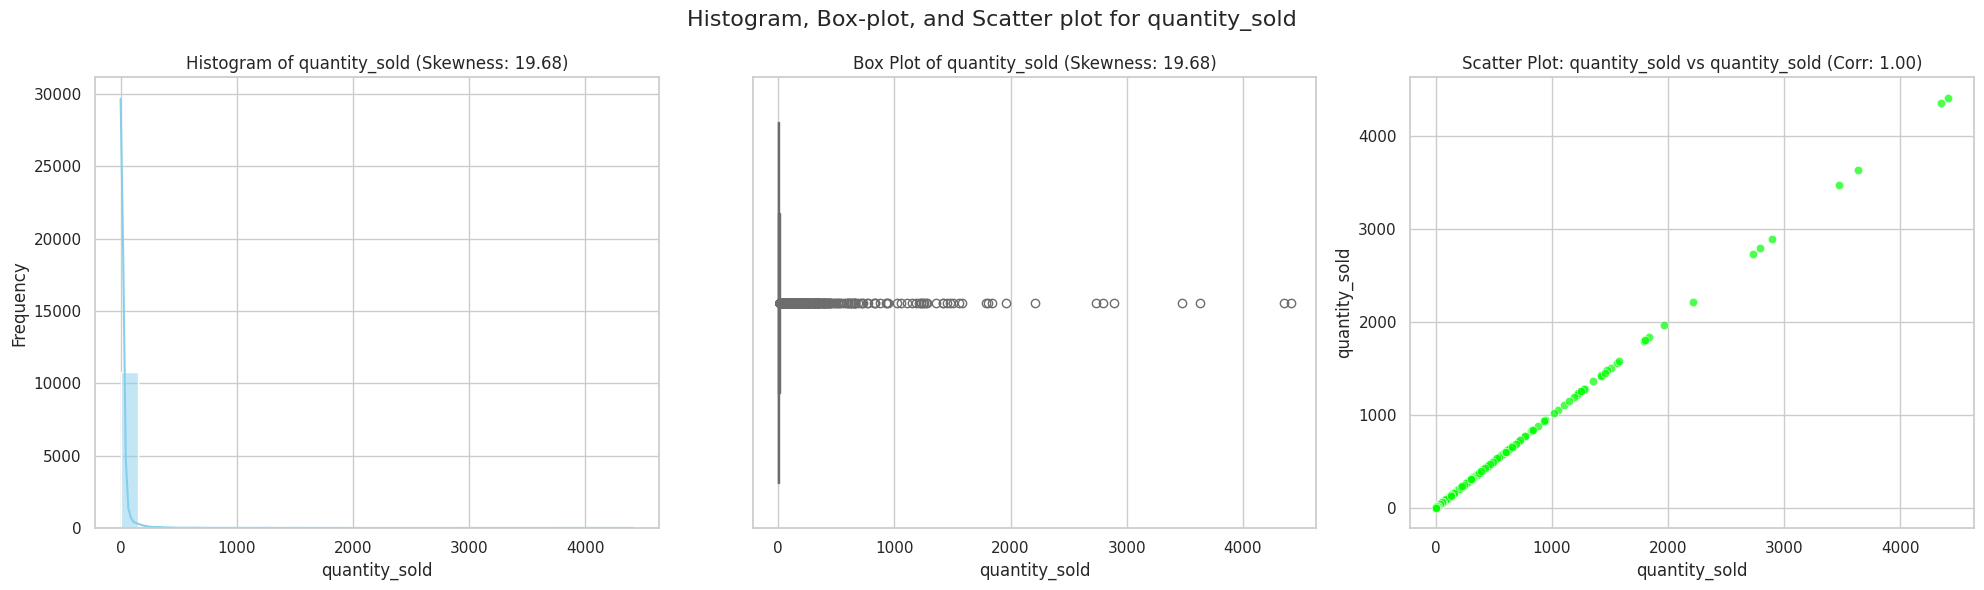

In [83]:
analyse_numerical(test_data, 'quantity_sold','quantity_sold')

### **3.4 Missing Value Imputation** <a id="3-3"></a>  
[Back to Top](#top)  

In [84]:
missing_data(train_data)

id : 0
name : 0
description : 0
original_price : 0
price : 0
fulfillment_type : 0
brand : 0
review_count : 0
rating_average : 6
pay_later : 0
current_seller : 0
date_created : 0
number_of_images : 0
vnd_cashback : 0
has_video : 0
product_type : 0
quantity_sold : 0


In [85]:
missing_data(test_data)

id : 0
name : 0
description : 0
original_price : 0
price : 0
fulfillment_type : 0
brand : 0
review_count : 0
rating_average : 4
pay_later : 0
current_seller : 0
date_created : 0
number_of_images : 0
vnd_cashback : 0
has_video : 0
product_type : 0
quantity_sold : 0


In [86]:
print("Stats for `rating_average`")
mean_rating = train_data.select(mean(col("rating_average"))).collect()[0][0]
print(f"mean: {mean_rating}")

median_rating = train_data.approxQuantile("rating_average", [0.5], 0.001)
print(f"median: {median_rating[0]}")

sd_rating = train_data.select(stddev(col("rating_average"))).collect()[0][0]
print(f"standard deviation: {sd_rating}")

mode_df = ( train_data.groupBy("rating_average").agg(count("rating_average").alias("count")).orderBy(col("count").desc()))
mode_rating = mode_df.first()["rating_average"]
print(f"Mode: {mode_rating}")

Stats for `rating_average`
mean: 1.3400721467495589
median: 0.0
standard deviation: 2.086765302006374


Mode: 0.0


In [87]:
# Fill null values in 'rating_average' with the mean
train_data = train_data.fillna({"rating_average": median_rating[0]})
shape(train_data)

test_data = test_data.fillna({"rating_average": median_rating[0]})


(26064, 17)


In [88]:
missing_data(train_data)

id : 0
name : 0
description : 0
original_price : 0
price : 0
fulfillment_type : 0
brand : 0
review_count : 0
rating_average : 0
pay_later : 0
current_seller : 0
date_created : 0
number_of_images : 0
vnd_cashback : 0
has_video : 0
product_type : 0
quantity_sold : 0


In [89]:
missing_data(test_data)

id : 0
name : 0
description : 0
original_price : 0
price : 0
fulfillment_type : 0
brand : 0
review_count : 0
rating_average : 0
pay_later : 0
current_seller : 0
date_created : 0
number_of_images : 0
vnd_cashback : 0
has_video : 0
product_type : 0
quantity_sold : 0


In [90]:
# imput by train mean 
#  train RMSE: 96.2942
#  train MAE: 8.9896
#  train R2: 0.7218
#  test RMSE: 71.5552
#  test MAE: 11.0402
#  test R2: 0.6661 (slightly better)

# imput by train median
#  train RMSE: 96.4653
#  train MAE: 8.9982
#  train R2: 0.7208
#  test RMSE: 71.6391
#  test MAE: 11.0490
#  test R2: 0.6653

### **3.5 Categorical Data Encoding** <a id="3-4"></a>  
[Back to Top](#top)  

In [91]:
train_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- original_price: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- fulfillment_type: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- rating_average: double (nullable = false)
 |-- pay_later: boolean (nullable = true)
 |-- current_seller: string (nullable = true)
 |-- date_created: integer (nullable = true)
 |-- number_of_images: integer (nullable = true)
 |-- vnd_cashback: integer (nullable = true)
 |-- has_video: boolean (nullable = true)
 |-- product_type: string (nullable = true)
 |-- quantity_sold: integer (nullable = true)



In [92]:
for cat_col in Categorical_vars:
    cardinality_check = train_data.select(cat_col).distinct().count()
    print(f"{cat_col}: {cardinality_check}")

name: 24415
description: 20492
fulfillment_type: 3
brand: 699
pay_later: 2
current_seller: 3273
has_video: 2
product_type: 6


In [93]:
train_data[Categorical_vars].show(5)

+--------------------+--------------------+----------------+------+---------+--------------+---------+-------------------+
|                name|         description|fulfillment_type| brand|pay_later|current_seller|has_video|       product_type|
+--------------------+--------------------+----------------+------+---------+--------------+---------+-------------------+
|Sakos suitcase Ch...|Sakos Champion 5 ...|        dropship| Sakos|     true|    Balonation|    false|backpacks_suitcases|
|Sakos suitcase Sa...|Sakos Champion 6 ...|        dropship| Sakos|     true|    Backpack 2|    false|backpacks_suitcases|
|Baellerry Luxury ...|The luxurious Bae...|        dropship|    GL|    false|      Vacimall|    false|           men_bags|
|Lock Master Lock ...|Master Lock 4680e...|        dropship|Master|     true|       Msoftvn|    false|backpacks_suitcases|
|Sakos Bricko I15 ...|Sakos Bricko i15 ...|        dropship| Sakos|     true|    Balo world|    false|backpacks_suitcases|
+---------------

Plan for Categorical Value imputation:  <br>
1. Name : Drop this variable <br>
2. Description : Drop this variable <br>
3. Fulfillment_type : OHE <br>
4. brand : Frequency Encoding / Target-mean encoding <br>
5. pay_later : Convert boolean to integer <br>
6. current_seller : drop / Target-mean encoding<br>
7. has_video : Convert boolean to integer <br>
8. product_type: OHE <br>


In [94]:
# Drop unnecessary columns
columns_to_drop = ["current_seller","id","Name", "description",]  
train_data = train_data.drop(*columns_to_drop)
train_data.show(5)


+--------------+-------+----------------+------+------------+--------------+---------+------------+----------------+------------+---------+-------------------+-------------+
|original_price|  price|fulfillment_type| brand|review_count|rating_average|pay_later|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|
+--------------+-------+----------------+------+------------+--------------+---------+------------+----------------+------------+---------+-------------------+-------------+
|       2189000|1858000|        dropship| Sakos|           0|           0.0|     true|           0|               5|           0|    false|backpacks_suitcases|            1|
|       2585000|2585000|        dropship| Sakos|           0|           0.0|     true|           0|               5|       26962|    false|backpacks_suitcases|            1|
|         99000|  99000|        dropship|    GL|           6|           4.5|    false|        2359|               3|           0| 

In [95]:
test_data = test_data.drop(*columns_to_drop)
test_data.show(5)

+--------------+-------+----------------+------------+------------+--------------+---------+------------+----------------+------------+---------+-------------------+-------------+
|original_price|  price|fulfillment_type|       brand|review_count|rating_average|pay_later|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|
+--------------+-------+----------------+------------+------------+--------------+---------+------------+----------------+------------+---------+-------------------+-------------+
|       2585000|2195000|        dropship|       Sakos|           2|           5.0|     true|           0|               7|           0|    false|backpacks_suitcases|            5|
|         35000|  35000|        dropship|Winwinshop88|           1|           4.0|    false|        2196|               8|         937|    false|fashion_accessories|            2|
|        200000| 129000|        dropship|       HARAS|          24|           4.5|     true|        

In [96]:
# Boolean to Integer Conversion
train_data = train_data.withColumn("pay_later", col("pay_later").cast("int"))
train_data = train_data.withColumn("has_video", col("has_video").cast("int"))
test_data = test_data.withColumn("pay_later", col("pay_later").cast("int"))
test_data = test_data.withColumn("has_video", col("has_video").cast("int"))
train_data.show(5)
test_data.show(5)

+--------------+-------+----------------+------+------------+--------------+---------+------------+----------------+------------+---------+-------------------+-------------+
|original_price|  price|fulfillment_type| brand|review_count|rating_average|pay_later|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|
+--------------+-------+----------------+------+------------+--------------+---------+------------+----------------+------------+---------+-------------------+-------------+
|       2189000|1858000|        dropship| Sakos|           0|           0.0|        1|           0|               5|           0|        0|backpacks_suitcases|            1|
|       2585000|2585000|        dropship| Sakos|           0|           0.0|        1|           0|               5|       26962|        0|backpacks_suitcases|            1|
|         99000|  99000|        dropship|    GL|           6|           4.5|        0|        2359|               3|           0| 

In [97]:
# creating a transformer for target mean encoding within a pipeline 

# class to fit a target mean encoder model on a dataset.
class TargetMeanEncoder(Estimator):
    def __init__(self, inputCol, targetCol, outputCol):
        self.inputCol = inputCol # name of cat col to encode 
        self.targetCol = targetCol # target col
        self.outputCol = outputCol # name of output col after encoding

    def _fit(self, dataset: DataFrame):
        # calculate the target mean  for input col 
        mean_df = dataset.groupBy(self.inputCol).agg(
            mean(self.targetCol).alias(self.outputCol)
        )
        # Compute the global mean for missing values
        global_mean = dataset.select(mean(self.targetCol).alias("global_mean")).first()["global_mean"]

        # Create a model that stores the computed means
        return TargetMeanEncoderModel(self.inputCol, self.outputCol, mean_df, global_mean)


#  class to apply the pre-computed target mean encoding to new dataset.
class TargetMeanEncoderModel(Transformer):
    def __init__(self, inputCol, outputCol, mean_df, global_mean):
        self.inputCol = inputCol #  name of cat col to encode 
        self.outputCol = outputCol # name of output col after encoding
        self.mean_df = mean_df   # df with pre-computed mean encodings for each category.
        self.global_mean = global_mean   #global mean of target 

    def _transform(self, dataset: DataFrame):
        # Join the dataset with the precomputed mean encoding
        dataset = dataset.join(self.mean_df, on=self.inputCol, how="left")

        # Replace missing values with the global mean
        dataset = dataset.withColumn(
            self.outputCol,
            when(col(self.outputCol).isNull(), lit(self.global_mean)).otherwise(col(self.outputCol))
        )
        return dataset

In [98]:
# Target Mean Encoding Stages
target_mean_stages = [
    TargetMeanEncoder(inputCol=col_name, targetCol="quantity_sold", outputCol=f"{col_name}_mean_encoded")
    for col_name in [ "brand"]
]


In [99]:
# StringIndexer and OneHotEncoder Stages
string_indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_string_encoded", handleInvalid="skip")
    for col in ["product_type", "fulfillment_type"]
]
one_hot_encoders = [
    OneHotEncoder(inputCol=f"{col}_string_encoded", outputCol=f"{col}_one_hot")
    for col in ["product_type", "fulfillment_type"]
]


In [100]:
pipeline_stages = target_mean_stages + string_indexers + one_hot_encoders

pipeline = Pipeline(stages=pipeline_stages)

# Fit the pipeline on training data only
pipeline_model = pipeline.fit(train_data)

# Transform both train and test data
train_transformed = pipeline_model.transform(train_data)
test_transformed = pipeline_model.transform(test_data)

In [101]:
test_transformed.show(5)

+------------+--------------+-------+----------------+------------+--------------+---------+------------+----------------+------------+---------+-------------------+-------------+------------------+---------------------------+-------------------------------+--------------------+------------------------+
|       brand|original_price|  price|fulfillment_type|review_count|rating_average|pay_later|date_created|number_of_images|vnd_cashback|has_video|       product_type|quantity_sold|brand_mean_encoded|product_type_string_encoded|fulfillment_type_string_encoded|product_type_one_hot|fulfillment_type_one_hot|
+------------+--------------+-------+----------------+------------+--------------+---------+------------+----------------+------------+---------+-------------------+-------------+------------------+---------------------------+-------------------------------+--------------------+------------------------+
|       Sakos|       2585000|2195000|        dropship|           2|           5.0|   

In [102]:
columns_to_drop = ["brand", "fulfillment_type","product_type","product_type_string_encoded","fulfillment_type_string_encoded"]  
train_trans_dropped = train_transformed.drop(*columns_to_drop)
test_trans_dropped = test_transformed.drop(*columns_to_drop)
test_trans_dropped.show(5)


+--------------+-------+------------+--------------+---------+------------+----------------+------------+---------+-------------+------------------+--------------------+------------------------+
|original_price|  price|review_count|rating_average|pay_later|date_created|number_of_images|vnd_cashback|has_video|quantity_sold|brand_mean_encoded|product_type_one_hot|fulfillment_type_one_hot|
+--------------+-------+------------+--------------+---------+------------+----------------+------------+---------+-------------+------------------+--------------------+------------------------+
|       2585000|2195000|           2|           5.0|        1|           0|               7|           0|        0|            5|17.728571428571428|           (5,[],[])|           (2,[0],[1.0])|
|         35000|  35000|           1|           4.0|        0|        2196|               8|         937|        0|            2|              49.0|       (5,[0],[1.0])|           (2,[0],[1.0])|
|        200000| 129000| 

In [103]:
# Dropping current_seller and frequency encoding for brand
# train RMSE: 62.7413
#  train MAE: 8.3811
#  train R2: 0.8819
#  test RMSE: 73.3430
#  test MAE: 10.9955
#  test R2: 0.6492


# after target mean encoding for both current_seller and brand 
#  train RMSE: 63.8961
#  train MAE: 7.7116
#  train R2: 0.8775
#  test RMSE: 73.2168
#  test MAE: 10.6809
#  test R2: 0.6504 (train decreased test increased) 


# after target mean encoding to current_seller and feq encoding to brand 
#  train RMSE: 59.3267
#  train MAE: 7.2763
#  train R2: 0.8944
#  test RMSE: 73.7438
#  test MAE: 10.5307
#  test R2: 0.6453

# mean encoding to brand and drop current_seller
#  train RMSE: 63.0199
#  train MAE: 8.4273
#  train R2: 0.8808
#  test RMSE: 72.3838
#  test MAE: 10.8159
#  test R2: 0.6583 (best)


# after grouping the less performing categories in brand and current seller
# Before: (this was after other transformations are done)
#  train RMSE: 67.5100
#  train MAE: 9.9036
#  train R2: 0.8632
#  test RMSE: 64.9749
#  test MAE: 11.9129
#  test R2: 0.7247

#after encoding both
# train RMSE: 64.0777
#  train MAE: 8.0170
#  train R2: 0.8767
#  test RMSE: 86.0691
#  test MAE: 10.8872
#  test R2: 0.5205 (overfitting occurs )

# encoding brand only and drop seller
#  train RMSE: 67.2082
#  train MAE: 9.9596
#  train R2: 0.8644
#  test RMSE: 82.5081
#  test MAE: 12.2098
#  test R2: 0.5593

In [104]:
# # Frequency Encoding for "brand" as a custom stage
# def frequency_encode(train_df, test_df, inputCol, outputCol):
#     # Compute frequencies on the training set
#     freq_df = train_df.groupBy(inputCol).agg(count(lit(1)).alias("frequency"))

#     # Apply encoding to the training set
#     train_encoded = train_df.join(freq_df, on=inputCol, how="left")

#     # Apply encoding to the test set using the training frequencies
#     test_encoded = test_df.join(freq_df, on=inputCol, how="left")
#     global_avg_freq = train_encoded.select("frequency").agg({"frequency": "avg"}).first()[0]
#     test_encoded = test_encoded.withColumn(
#         "frequency",
#         when(col("frequency").isNull(), lit(global_avg_freq)).otherwise(col("frequency"))
#     )

#     # Rename the frequency column to the output column name
#     train_encoded = train_encoded.withColumnRenamed("frequency", outputCol)
#     test_encoded = test_encoded.withColumnRenamed("frequency", outputCol)

#     return train_encoded, test_encoded




In [105]:

# train_encoded, test_encoded = frequency_encode(
#     train_transformed, test_transformed, inputCol="brand", outputCol="brand_frequency"
# )


# # Define pipeline stages for One-Hot Encoding
# string_indexers = [
#     StringIndexer(inputCol=col, outputCol=f"{col}_string_encoded", handleInvalid="skip")
#     for col in ["product_type", "fulfillment_type"]
# ]
# one_hot_encoders = [
#     OneHotEncoder(inputCol=f"{col}_string_encoded", outputCol=f"{col}_one_hot")
#     for col in ["product_type", "fulfillment_type"]
# ]

# # Create the pipeline
# pipeline = Pipeline(stages=string_indexers + one_hot_encoders)

# # Fit and transform the data
# pipeline_model = pipeline.fit(train_encoded)
# train_transformed = pipeline_model.transform(train_encoded)
# test_transformed = pipeline_model.transform(test_encoded)


In [106]:
# # Drop intermediate columns if needed
# columns_to_drop = ["fulfillment_type", "product_type","brand","current_seller","product_type_string_encoded,","fulfillment_type_string_encoded"] 
# train_trans_dropped = train_transformed.drop(*columns_to_drop)
# test_trans_dropped = test_transformed.drop(*columns_to_drop)

# # Show the final transformed dataset
# test_trans_dropped.show()


### **3.6 Numerical Data Transformation** <a id="3-5"></a>  
[Back to Top](#top)  

In [107]:
# Extract the Numerical schema fields
Numerical_vars = []

schema_fields = test_trans_dropped.schema.fields

# Loop through the schema and classify variables
for field in schema_fields:
    # Check if the field is numeric
    if field.dataType.typeName() in ["integer", "double", "float"]:
        Numerical_vars.append(field.name)

print("Numerical Variables:", Numerical_vars)

Numerical Variables: ['original_price', 'price', 'review_count', 'rating_average', 'pay_later', 'date_created', 'number_of_images', 'vnd_cashback', 'has_video', 'quantity_sold', 'brand_mean_encoded']


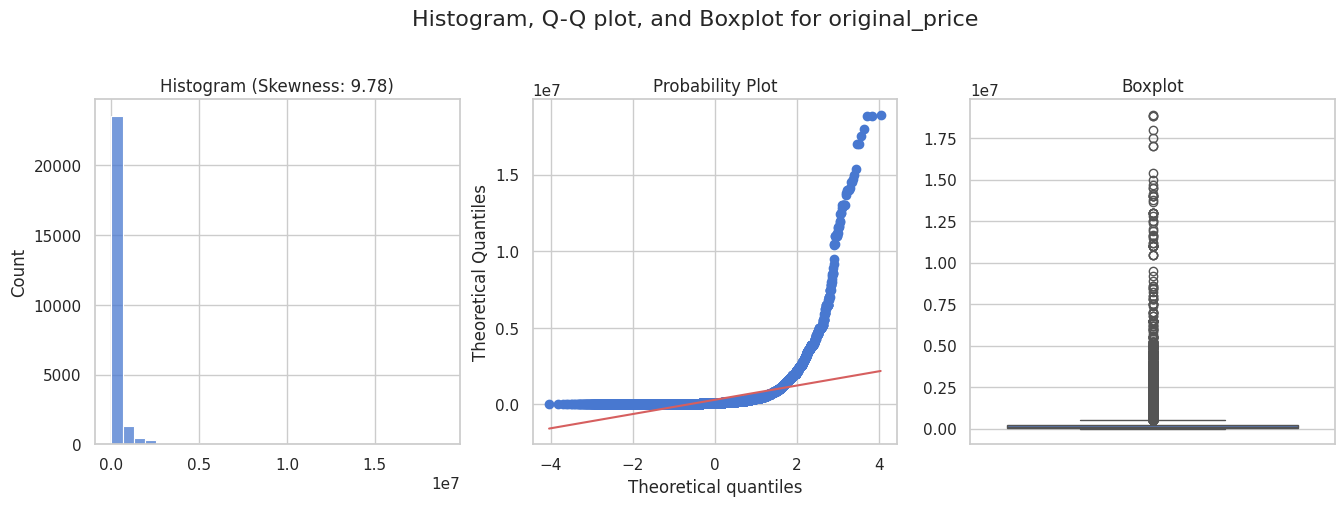

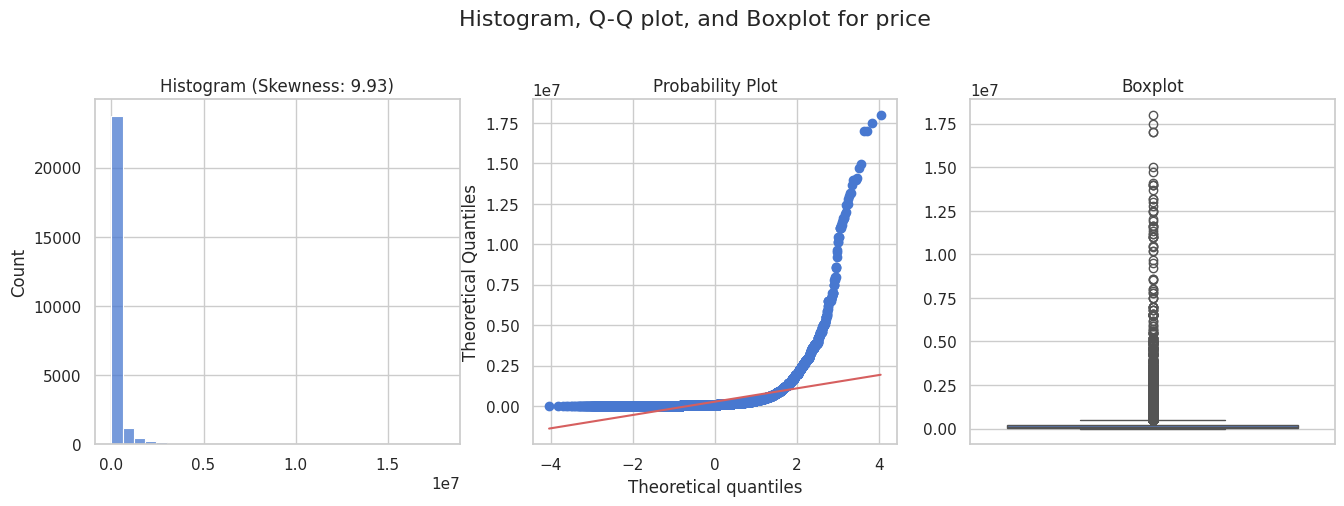

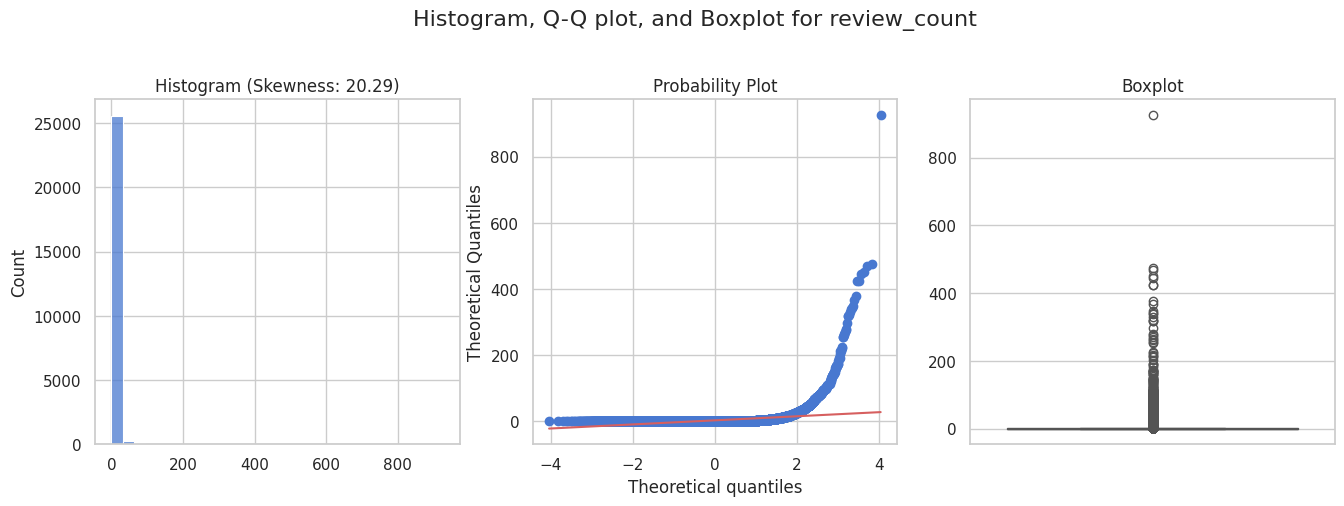

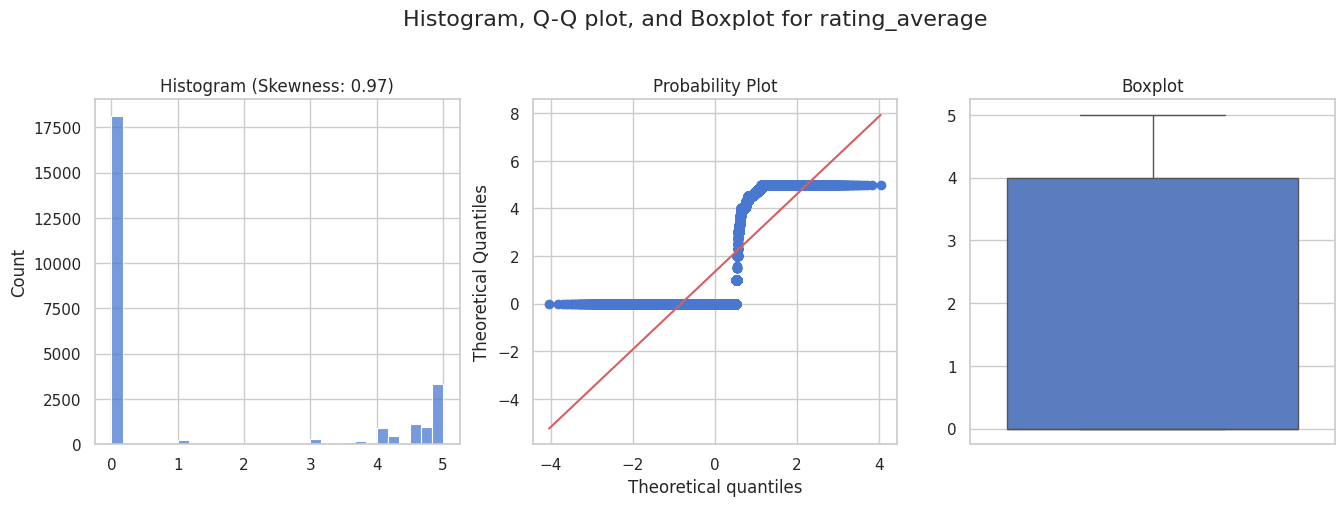

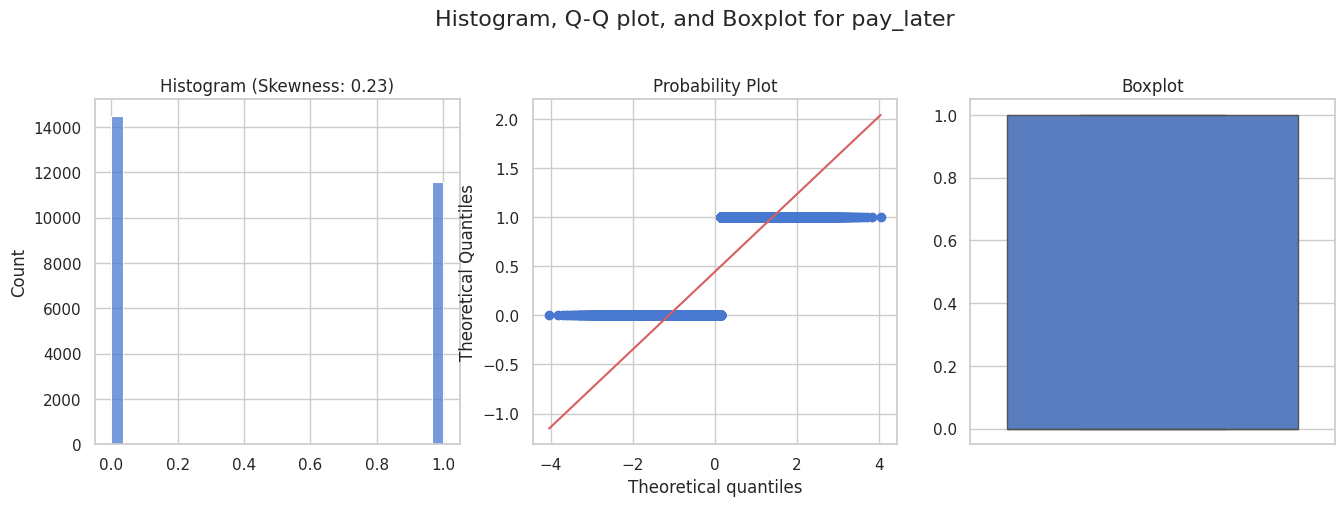

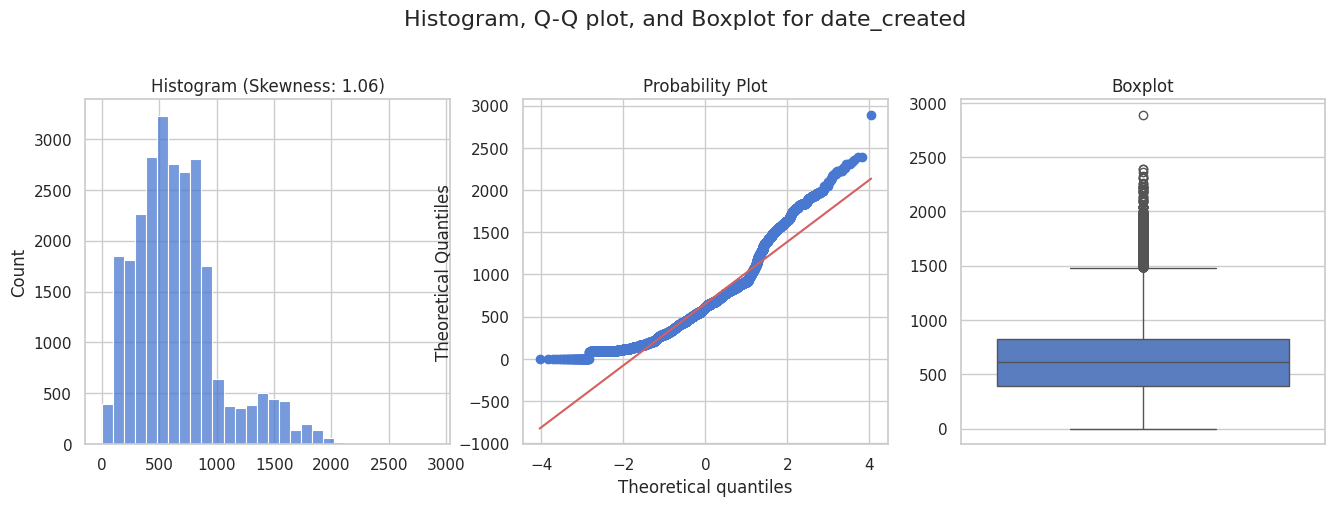

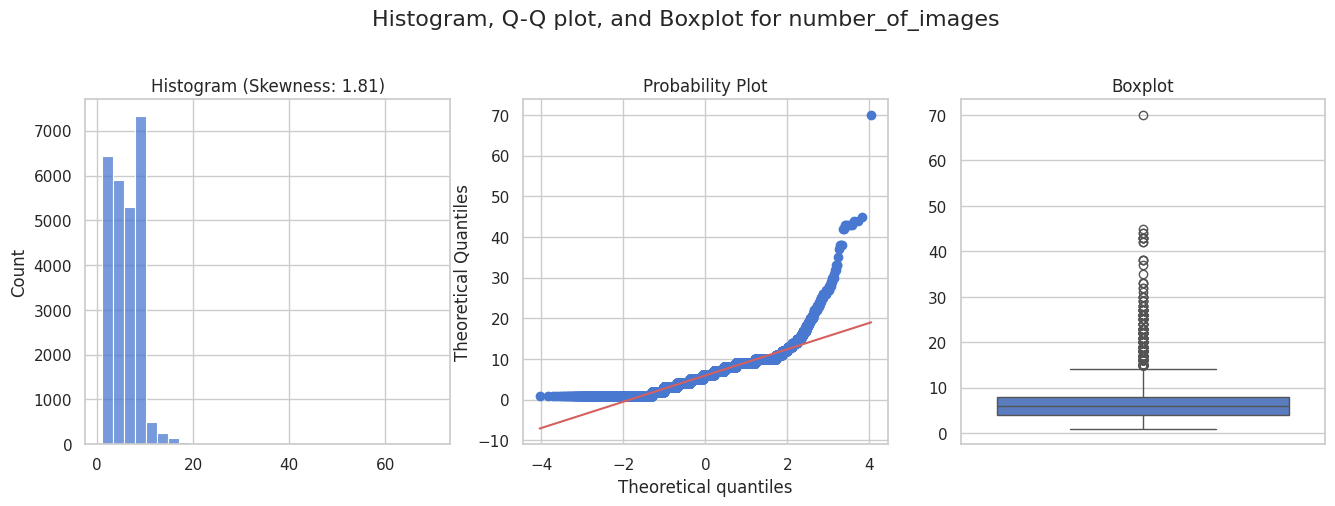

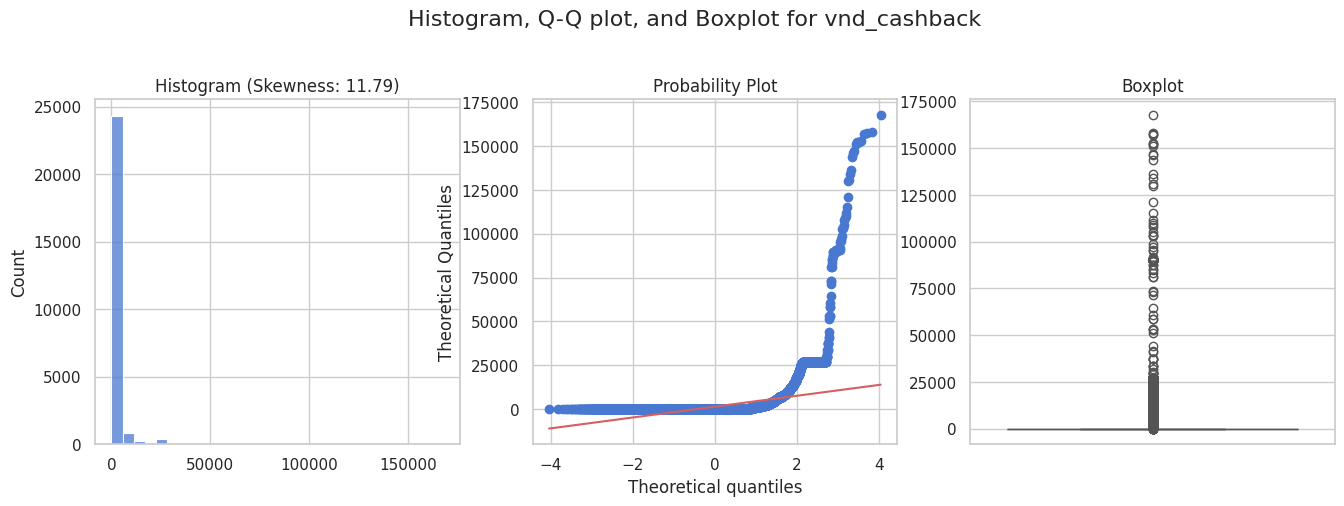

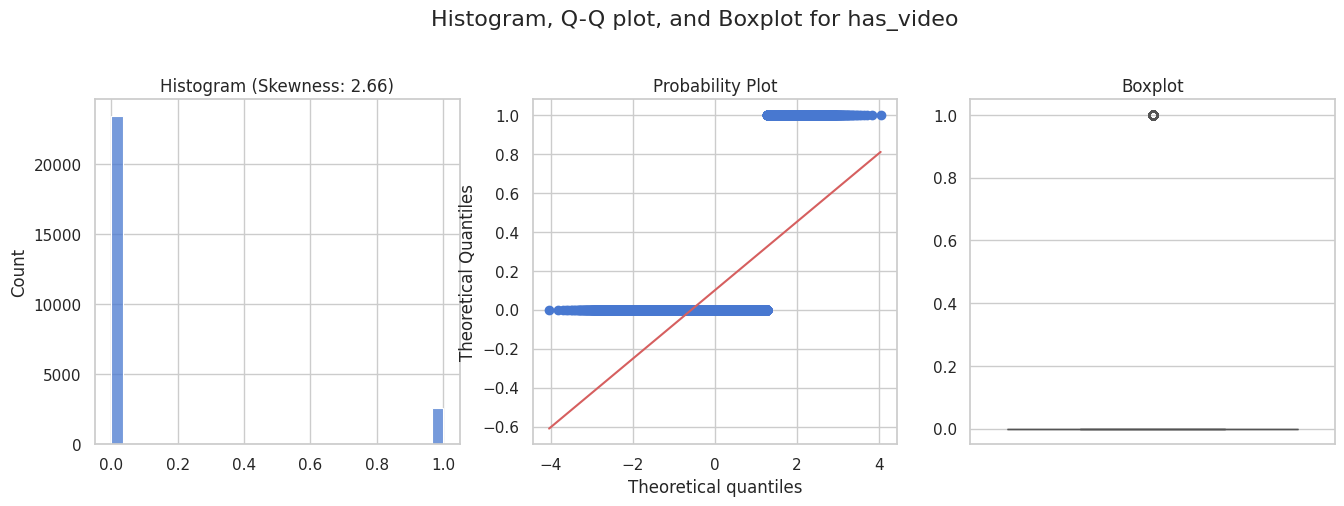

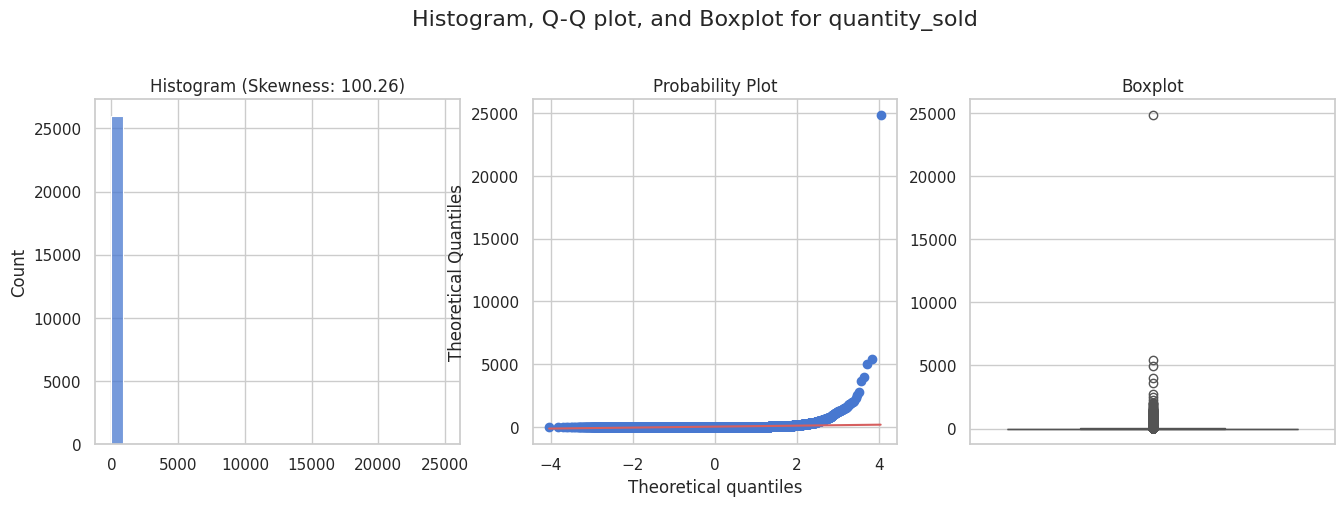

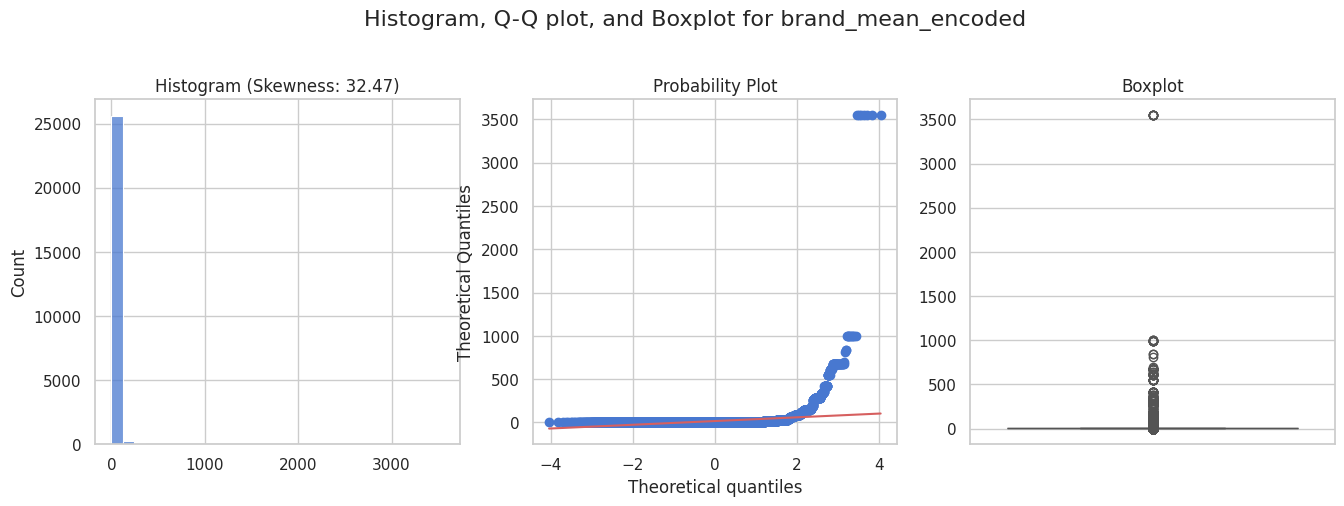

In [108]:
for num in Numerical_vars:
    diagnostic_plots(train_trans_dropped, num)

In [109]:
# create a custom class for power transformer in pipeline
class PowerTransformer(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCols=None, outputCols=None, exp=1.0):
        super(PowerTransformer, self).__init__()
        self.inputCols = inputCols 
        self.outputCols = outputCols
        self.exp = exp

    # create a new dataset after power transformation is conducted
    def _transform(self, dataset: DataFrame) -> DataFrame:
        for input_col, output_col in zip(self.inputCols, self.outputCols):
            dataset = dataset.withColumn(output_col, pow(col(input_col), self.exp))
        return dataset


In [110]:
# Define the pipeline stages
power_transformer1 = PowerTransformer(
    inputCols=["original_price", "price","vnd_cashback"],
    outputCols=["original_price", "price","vnd_cashback"],
    exp=0.3
)
power_transformer2 = PowerTransformer(
    inputCols=["review_count","brand_mean_encoded"],
    outputCols=["review_count","brand_mean_encoded"],
    exp=0.1
)

# Define the pipeline
pipeline = Pipeline(stages=[power_transformer1, power_transformer2])

# Fit and transform the data
model = pipeline.fit(train_trans_dropped)
train_pw_trans = model.transform(train_trans_dropped)
test_pw_trans = model.transform(test_trans_dropped)

# Show the result
train_pw_trans.show(5)


+------------------+------------------+------------------+--------------+---------+------------+----------------+------------------+---------+-------------+------------------+--------------------+------------------------+
|    original_price|             price|      review_count|rating_average|pay_later|date_created|number_of_images|      vnd_cashback|has_video|quantity_sold|brand_mean_encoded|product_type_one_hot|fulfillment_type_one_hot|
+------------------+------------------+------------------+--------------+---------+------------+----------------+------------------+---------+-------------+------------------+--------------------+------------------------+
| 79.81301711953233| 75.98252347046379|               0.0|           0.0|        1|           0|               5|               0.0|        0|            1|1.3331142604843058|           (5,[],[])|           (2,[0],[1.0])|
| 83.89540293487192| 83.89540293487192|               0.0|           0.0|        1|           0|               5

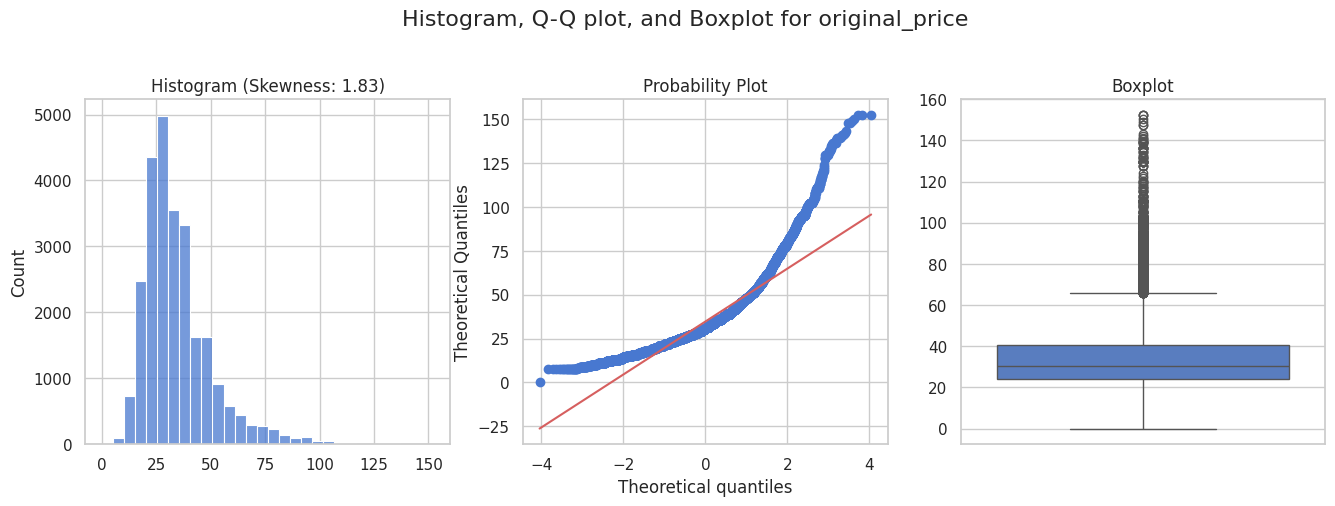

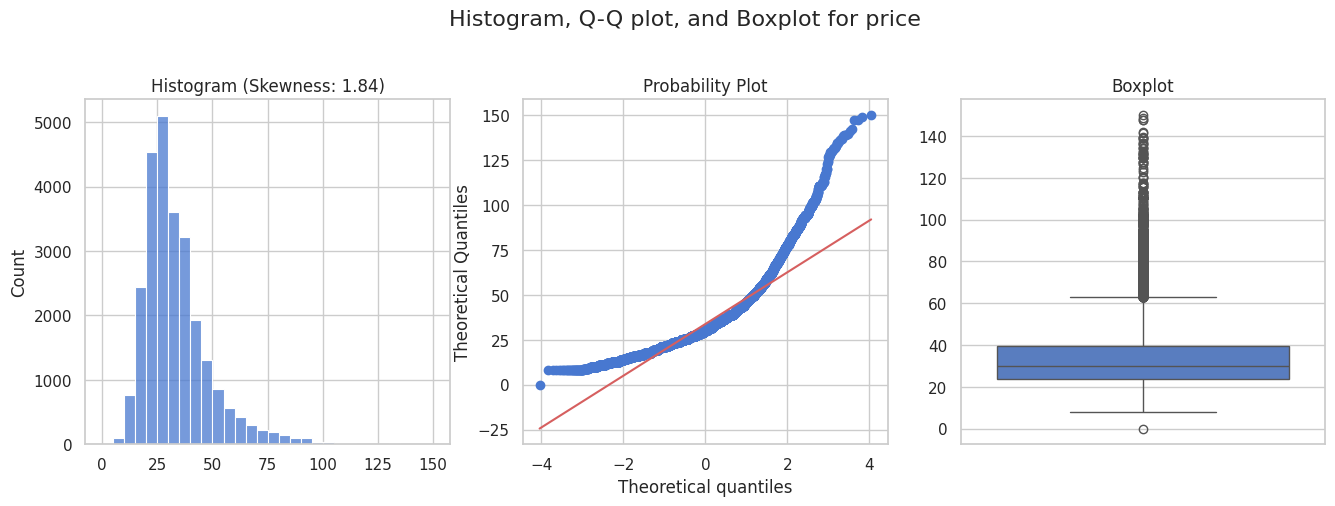

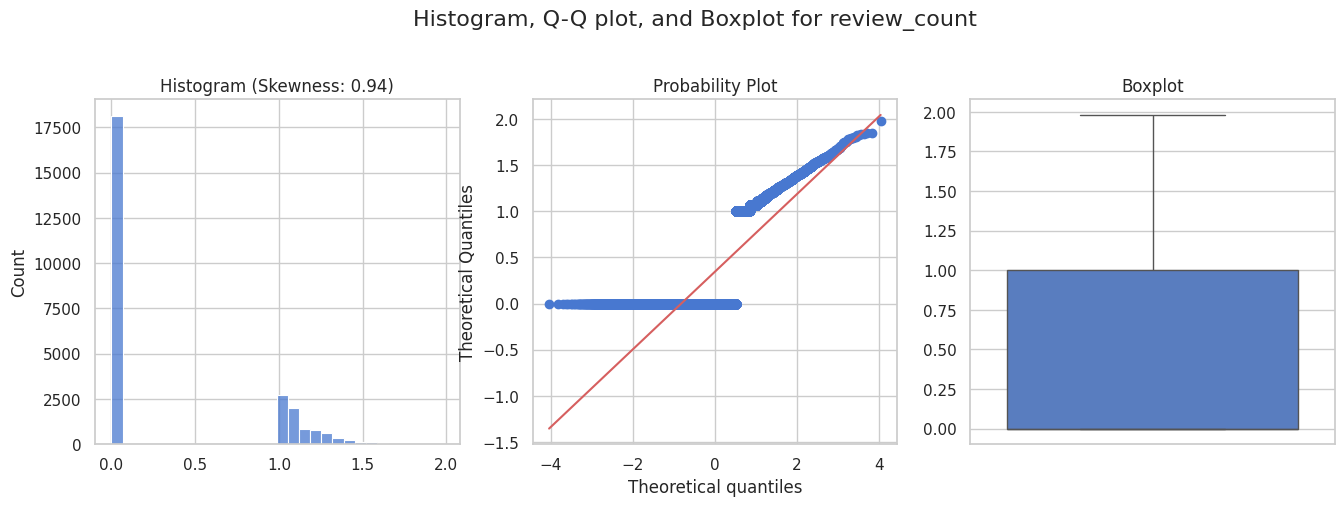

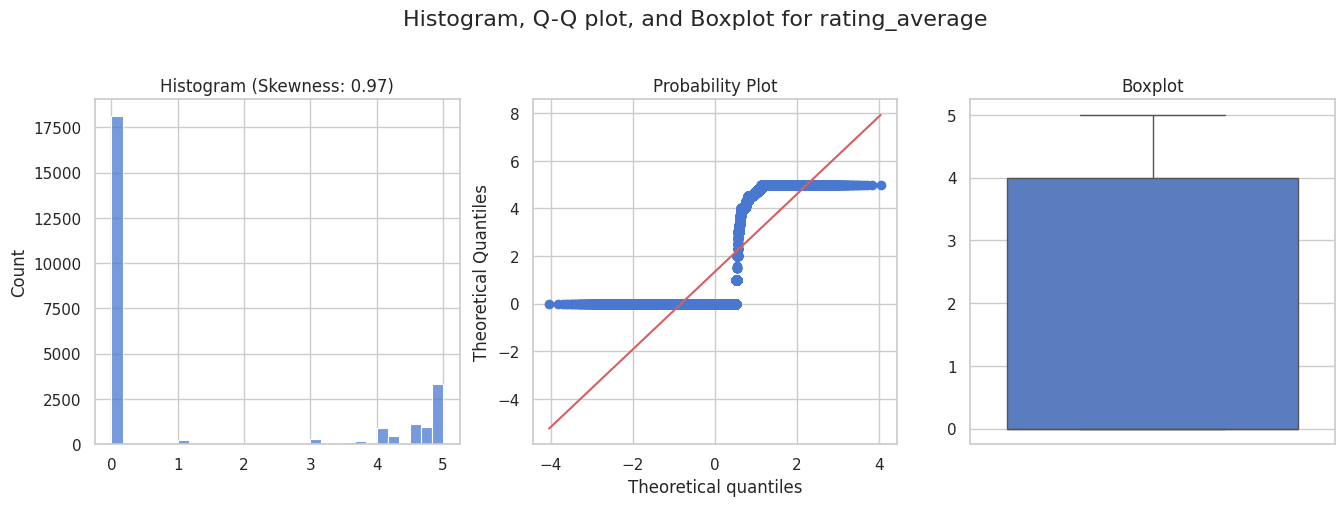

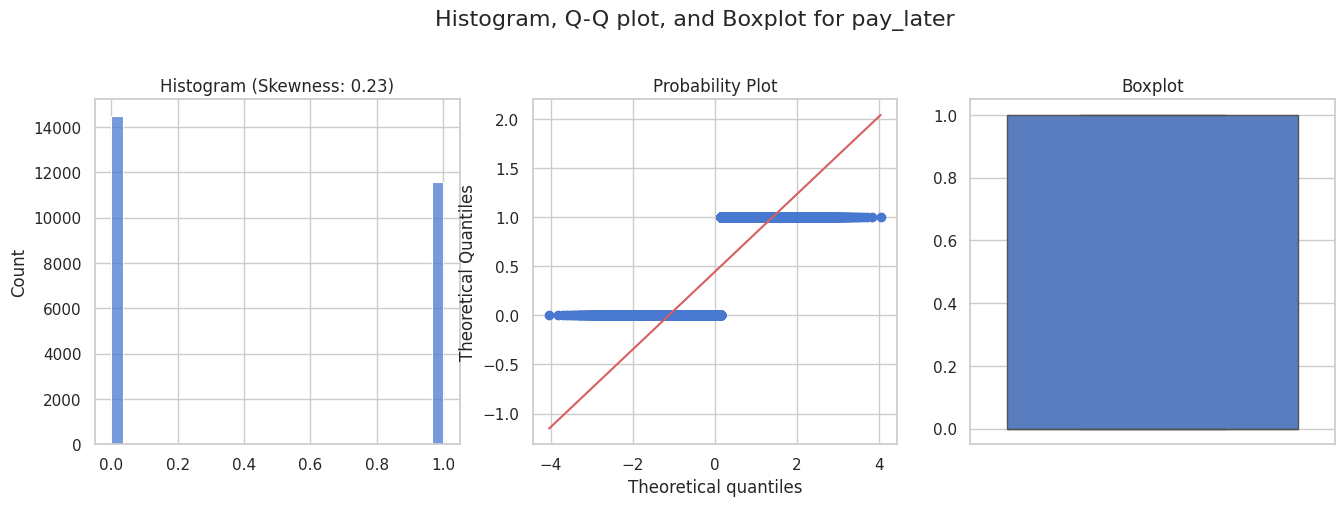

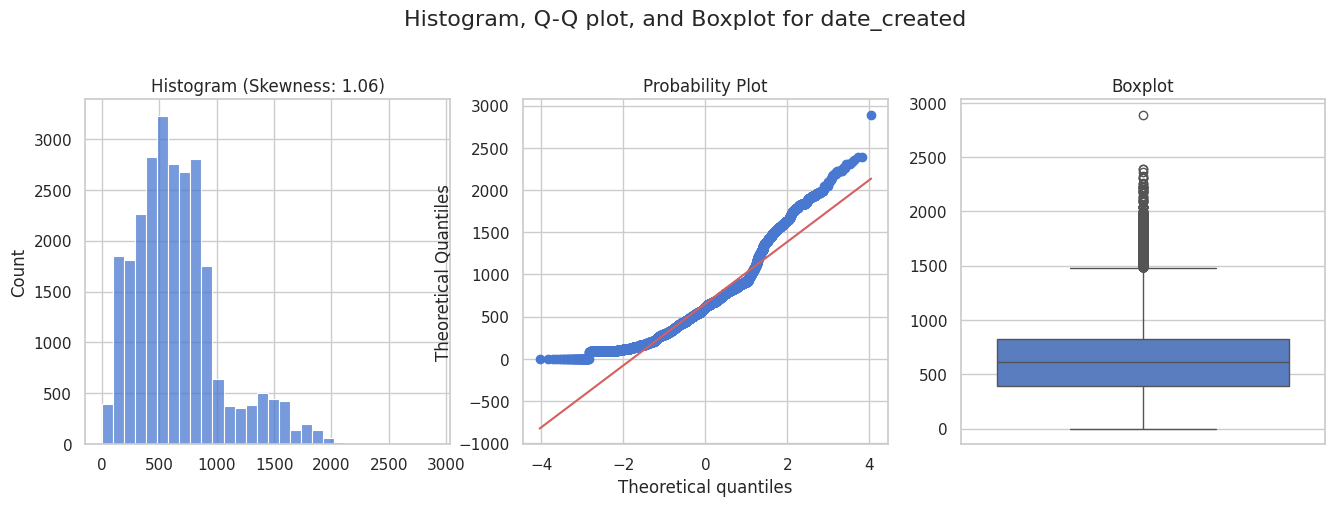

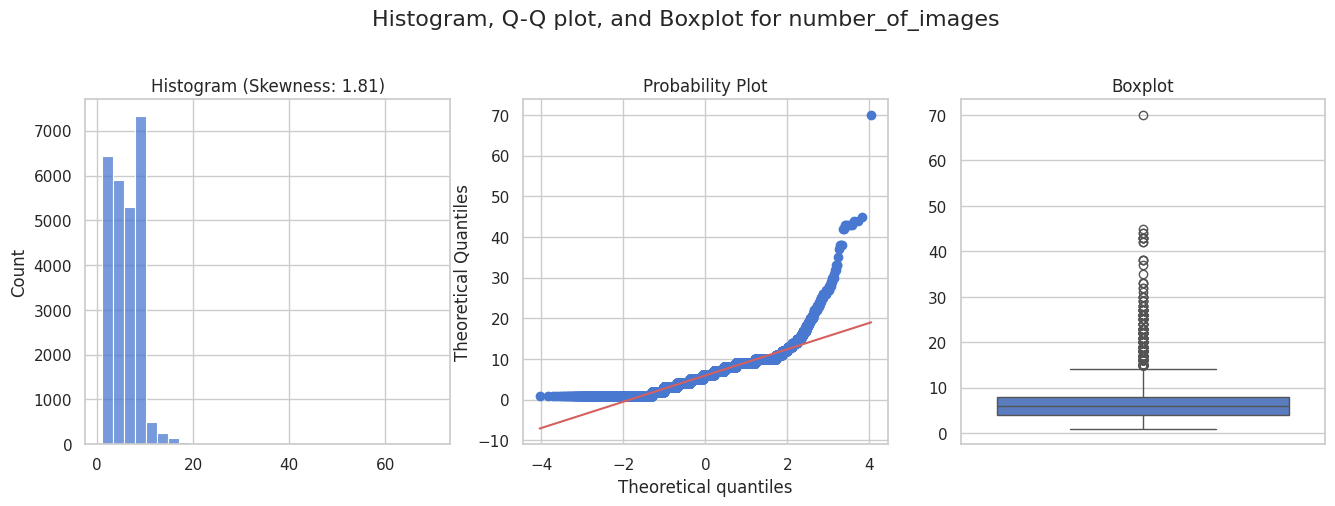

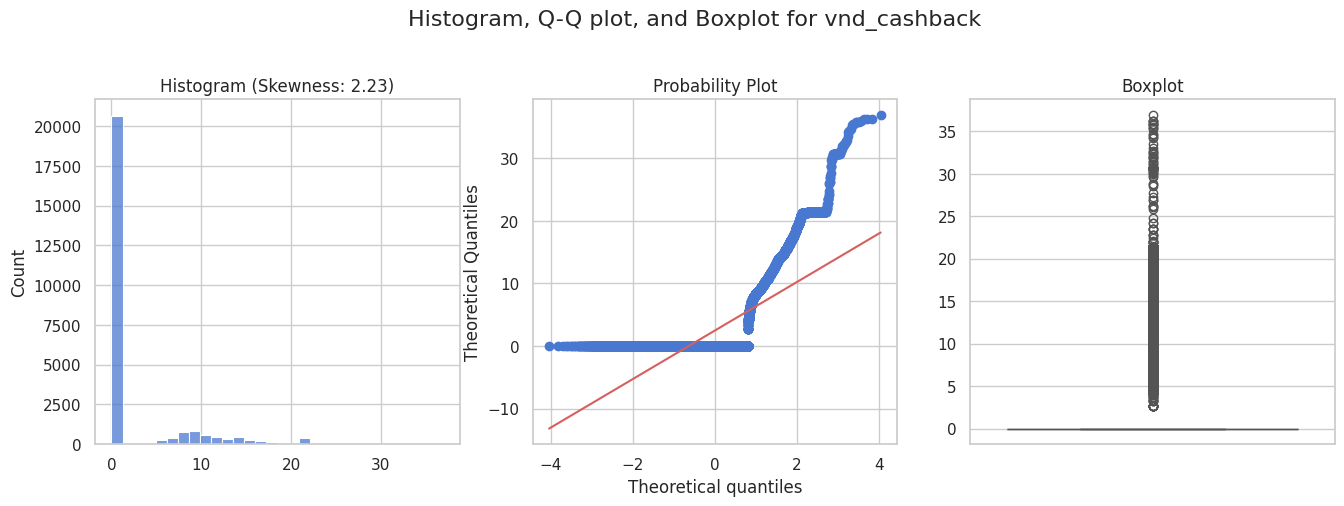

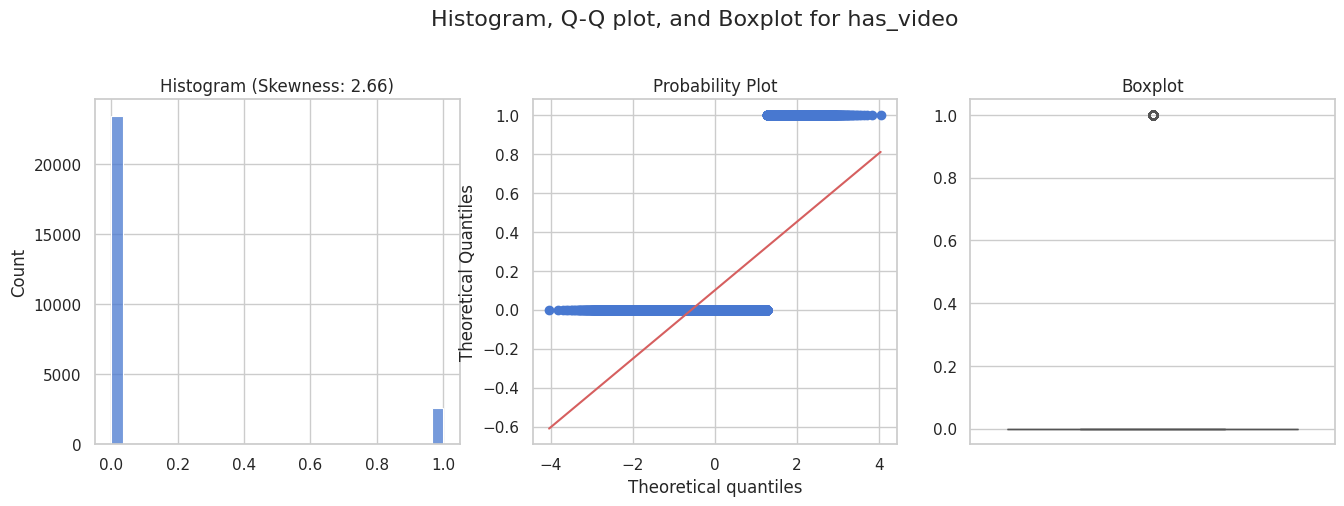

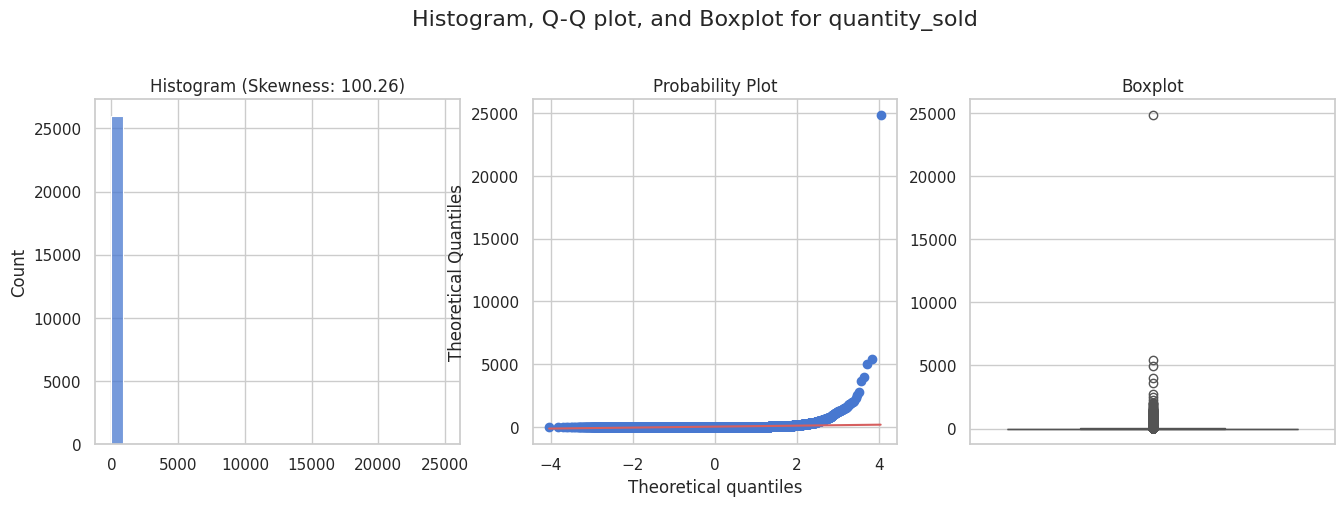

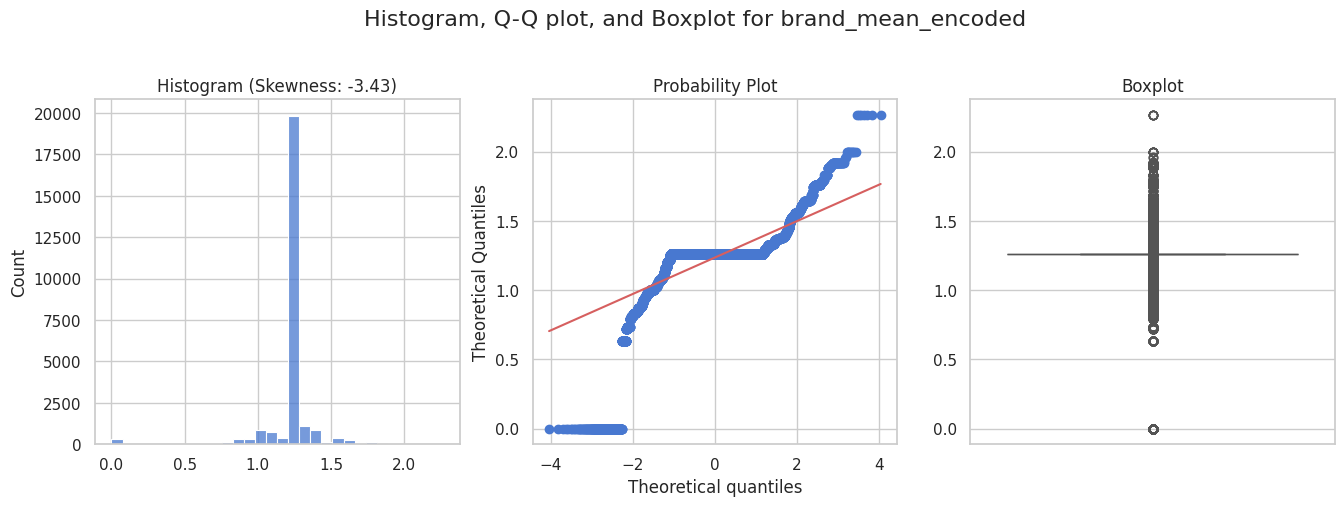

In [111]:
for num in Numerical_vars:
    diagnostic_plots(train_pw_trans, num)

In [112]:
# before:
#  train RMSE: 63.0199
#  train MAE: 8.4273
#  train R2: 0.8808
#  test RMSE: 72.3838
#  test MAE: 10.8159
#  test R2: 0.6583


# after power transformation
# train RMSE: 63.5432
#  train MAE: 8.3756
#  train R2: 0.8788
#  test RMSE: 72.2961
#  test MAE: 10.8445
#  test R2: 0.6591

### **3.7 Variable Discretization** <a id="3-6"></a>  
[Back to Top](#top)  



In [113]:
# conduct discretization on number of images and group them into equal bins 
# from pyspark.ml.feature import Bucketizer

# bin_count = 10
# min_val = train_pw_trans.agg({"number_of_images": "min"}).collect()[0][0]
# max_val = train_pw_trans.agg({"number_of_images": "max"}).collect()[0][0]
# bin_width = (max_val - min_val) / bin_count
# splits = [min_val + i * bin_width for i in range(bin_count + 1)]


# # Initialize the Bucketizer
# bucketizer = Bucketizer(
#     splits=splits,
#     inputCol="number_of_images",
#     outputCol="number_of_images_bin"
# )

# # Apply the Bucketizer
# train_bin_trans = bucketizer.transform(train_pw_trans)
# test_bin_trans = bucketizer.transform(test_pw_trans)


In [114]:
# diagnostic_plots(train_bin_trans, 'number_of_images_bin')

In [115]:
#before
# train RMSE: 63.5432
#  train MAE: 8.3756
#  train R2: 0.8788
#  test RMSE: 72.2961
#  test MAE: 10.8445
#  test R2: 0.6591

#after
#  train RMSE: 65.5229
#  train MAE: 8.7471
#  train R2: 0.8712
#  test RMSE: 74.5295
#  test MAE: 11.1371
#  test R2: 0.6377 (without binning is better)

### **3.8 Correlation Analysis** <a id="3-7"></a>  
[Back to Top](#top)  

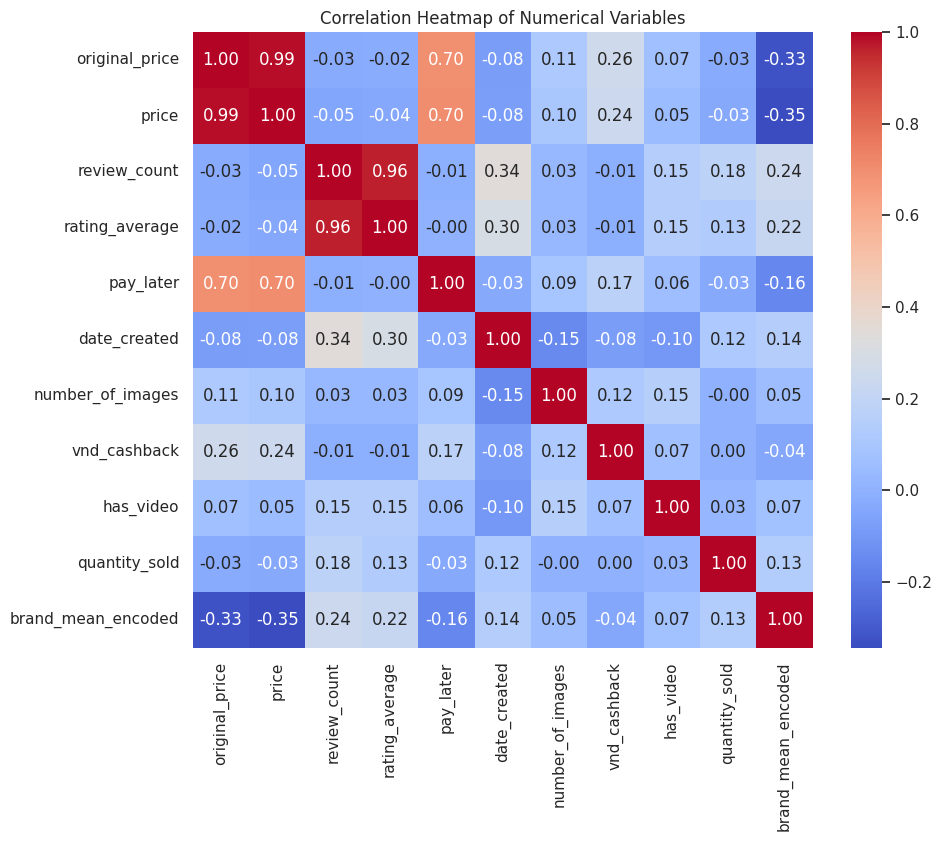

In [116]:
heatmap(train_pw_trans, Numerical_vars)

multicollinearity: 
* `original_price` & `price`
* `review_count` & `rating_average`

low correlations with the target: 
* `vnd_cashback`
* `number_of_images`


In [117]:
columns_to_drop = ["rating_average","price","has_video","brand_mean_encoded","fulfillment_type_one_hot"] 
train_trans_drop = train_pw_trans.drop(*columns_to_drop)
test_trans_drop = test_pw_trans.drop(*columns_to_drop)

# before
# train RMSE: 63.5432
#  train MAE: 8.3756
#  train R2: 0.8788
#  test RMSE: 72.2961
#  test MAE: 10.8445
#  test R2: 0.6591


#dropping vnd_cashback                                                           
#  train RMSE: 65.2815
#  train MAE: 8.4199
#  train R2: 0.8721
#  test RMSE: 77.2547
#  test MAE: 10.8496
#  test R2: 0.6108

#dropping number_of_images      
#  train RMSE: 67.0668
#  train MAE: 8.4254
#  train R2: 0.8650
#  test RMSE: 76.4569
#  test MAE: 10.8737
#  test R2: 0.6188


#dropping rating_average     
#  train RMSE: 65.2023
#  train MAE: 9.4860
#  train R2: 0.8724
#  test RMSE: 71.9005
#  test MAE: 11.8932
#  test R2: 0.6628

#dropping review_count
#  train RMSE: 96.1538
#  train MAE: 15.6855
#  train R2: 0.7226
#  test RMSE: 124.8913
#  test MAE: 19.8918
#  test R2: -0.0173

# dropping rating_average & price
#  train RMSE: 80.1271
#  train MAE: 11.1041
#  train R2: 0.8074
#  test RMSE: 69.5992
#  test MAE: 12.9602
#  test R2: 0.6841 (results are the best)

# dropping rating_average & original_price
#  train RMSE: 81.5712
#  train MAE: 11.1419
#  train R2: 0.8003
#  test RMSE: 70.7375
#  test MAE: 13.0475
#  test R2: 0.6737


In [118]:
# based on the feature importance, 
# Feature Importances:
# review_count: 0.5342421824811824
# date_created: 0.1913569122931109
# original_price: 0.12942476309577422
# vnd_cashback: 0.06860054217461677
# number_of_images: 0.05346420326886894
# pay_later: 0.015972571770648314
# product_type_one_hot: 0.0069388249157986874
# has_video: 0.0
# brand_mean_encoded: 0.0
# fulfillment_type_one_hot: 0.0

#test the model with dropping has_video,brand_mean_encoded,fulfillment_type_one_hot
# Before 
#  train RMSE: 80.1271
#  train MAE: 11.1041
#  train R2: 0.8074
#  test RMSE: 69.5992
#  test MAE: 12.9602
#  test R2: 0.6841

#after 
#  train RMSE: 67.5100
#  train MAE: 9.9036
#  train R2: 0.8632
#  test RMSE: 64.9749
#  test MAE: 11.9129
#  test R2: 0.7247


### **3.9 Feature Scaling** <a id="3-8"></a>  
[Back to Top](#top)  

In [119]:
# consider categorical and numerical variable treatment and transformations

In [120]:
shape(test_trans_dropped)

(11062, 13)


In [121]:
train_final = train_trans_drop
test_final = test_trans_drop

In [122]:
train_final.show(5)

+------------------+------------------+---------+------------+----------------+------------------+-------------+--------------------+
|    original_price|      review_count|pay_later|date_created|number_of_images|      vnd_cashback|quantity_sold|product_type_one_hot|
+------------------+------------------+---------+------------+----------------+------------------+-------------+--------------------+
| 79.81301711953233|               0.0|        1|           0|               5|               0.0|            1|           (5,[],[])|
| 83.89540293487192|               0.0|        1|           0|               5|21.341533931683493|            1|           (5,[],[])|
|31.527574338373988|1.1962311988513155|        0|        2359|               3|               0.0|           11|       (5,[4],[1.0])|
|   46.127806054218|               0.0|        1|        2308|               2|               0.0|            1|           (5,[],[])|
| 69.42099106720963|               0.0|        1|        2090|

In [123]:
train_final.printSchema()

root
 |-- original_price: double (nullable = true)
 |-- review_count: double (nullable = true)
 |-- pay_later: integer (nullable = true)
 |-- date_created: integer (nullable = true)
 |-- number_of_images: integer (nullable = true)
 |-- vnd_cashback: double (nullable = true)
 |-- quantity_sold: integer (nullable = true)
 |-- product_type_one_hot: vector (nullable = true)



In [124]:
# Select feature columns and target column
feature_columns = [col for col in train_final.columns if col not in ["quantity_sold"]] 
target_column = "quantity_sold" 

In [125]:

# Assemble feature vector
featureassembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


In [126]:
# sScaler = StandardScaler(
#     withMean=True, 
#     withStd=True, 
#     inputCol="features", 
#     outputCol="features_sscaled"
#     )
# train_sscaled = sScaler.fit(train_final).transform(train_final)
# train_sscaled.show(5)


In [127]:
# robust scaler 
rscaler = RobustScaler(
    inputCol="features",
    outputCol="features_sscaled",
    lower=0.2,  
    upper=0.8,   
    withCentering=True,
    withScaling=True
)


In [128]:
# create a pipeline for assembling the features and scaling
pipeline = Pipeline(stages=[featureassembler, rscaler])
pipeline_model = pipeline.fit(train_final)
train_sscaled = pipeline_model.transform(train_final)
test_sscaled = pipeline_model.transform(test_final)


In [129]:
train_data_scaled = train_sscaled.select("features_sscaled","quantity_sold")
train_data_scaled.show(5)

+--------------------+-------------+
|    features_sscaled|quantity_sold|
+--------------------+-------------+
|[2.31123058950427...|            1|
|[2.50310651715655...|            1|
|[0.04176990038386...|           11|
|[0.72799436106307...|            1|
|[1.82279570628385...|            1|
+--------------------+-------------+
only showing top 5 rows



In [130]:
test_data_scaled = test_sscaled.select("features_sscaled","quantity_sold")
test_data_scaled.show(5)

+--------------------+-------------+
|    features_sscaled|quantity_sold|
+--------------------+-------------+
|[2.50310651715655...|            5|
|[-0.3553123884597...|            2|
|[0.38979441177554...|          317|
|[-0.0826806104603...|           24|
|[0.38428553931127...|            5|
+--------------------+-------------+
only showing top 5 rows



In [131]:
# Before scaling (on linear regression model)
#  train RMSE: 151.8948
#  train MAE: 15.1631
#  train R2: 0.3246
#  test RMSE: 80.8492
#  test MAE: 15.3416
#  test R2: 0.5121

# After standard scaling
#  train RMSE: 151.8948
#  train MAE: 15.1631
#  train R2: 0.3246
#  test RMSE: 80.8492
#  test MAE: 15.3416
#  test R2: 0.5121

# after robust scaling 
#  train RMSE: 151.6564
#  train MAE: 15.3742
#  train R2: 0.3176
#  test RMSE: 81.3174
#  test MAE: 15.5228
#  test R2: 0.5430

# for random forest regression
# without scaling
#  train RMSE: 93.0456
#  train MAE: 9.7515
#  train R2: 0.7402
#  test RMSE: 68.0598
#  test MAE: 11.4789
#  test R2: 0.6979

# standard scaling
#  train RMSE: 93.9864
#  train MAE: 9.7491
#  train R2: 0.7349
#  test RMSE: 69.1755
#  test MAE: 11.5243
#  test R2: 0.6879

# robust scaling 
#  train RMSE: 93.9592
#  train MAE: 9.9786
#  train R2: 0.7351
#  test RMSE: 64.9956
#  test MAE: 11.6113
#  test R2: 0.7245

### **3.10 Polynomial Expansion** <a id="3-9"></a>  
[Back to Top](#top)  

In [132]:
test_data_scaled.show(10)

+--------------------+-------------+
|    features_sscaled|quantity_sold|
+--------------------+-------------+
|[2.50310651715655...|            5|
|[-0.3553123884597...|            2|
|[0.38979441177554...|          317|
|[-0.0826806104603...|           24|
|[0.38428553931127...|            5|
|[0.65695031000679...|          105|
|[1.33243774164688...|            5|
|[0.38428553931127...|            0|
|[0.72429144886668...|            4|
|[-0.3370860519237...|            3|
+--------------------+-------------+
only showing top 10 rows



In [133]:
train_data_scaled.show(10)

+--------------------+-------------+
|    features_sscaled|quantity_sold|
+--------------------+-------------+
|[2.31123058950427...|            1|
|[2.50310651715655...|            1|
|[0.04176990038386...|           11|
|[0.72799436106307...|            1|
|[1.82279570628385...|            1|
|[0.38704482005177...|         1819|
|[0.38428553931127...|            9|
|[0.06383590696393...|            0|
|[1.61068851979524...|            0|
|[-0.3109761011014...|            0|
+--------------------+-------------+
only showing top 10 rows



In [134]:
# polyExpansion = PolynomialExpansion(degree=2, inputCol="features_sscaled", outputCol="PolyFeatures")

# train_data_scaled2 = polyExpansion.transform(train_data_scaled)
# test_data_scaled2 = polyExpansion.transform(test_data_scaled)

In [135]:
# Before 
#  train RMSE: 67.5100
#  train MAE: 9.9036
#  train R2: 0.8632
#  test RMSE: 64.9749
#  test MAE: 11.9129
#  test R2: 0.7247

# after degree = 3
#  train RMSE: 67.5100
#  train MAE: 9.9036
#  train R2: 0.8632
#  test RMSE: 64.9749
#  test MAE: 11.9129
#  test R2: 0.7247

## **4. Machine Learning Modelling** <a id="4"></a>  
[Back to Top](#top)  

In [136]:
# use code to show number of rows and columns,
# as well as a sample of 10 rows before heading into Machine Learning Modeling

In [137]:
shape(train_data_scaled)

(26064, 2)


In [138]:
shape(test_data_scaled)

(11062, 2)


In [139]:
train_data_scaled.show(10)

+--------------------+-------------+
|    features_sscaled|quantity_sold|
+--------------------+-------------+
|[2.31123058950427...|            1|
|[2.50310651715655...|            1|
|[0.04176990038386...|           11|
|[0.72799436106307...|            1|
|[1.82279570628385...|            1|
|[0.38704482005177...|         1819|
|[0.38428553931127...|            9|
|[0.06383590696393...|            0|
|[1.61068851979524...|            0|
|[-0.3109761011014...|            0|
+--------------------+-------------+
only showing top 10 rows



In [140]:
test_data_scaled.show(10)

+--------------------+-------------+
|    features_sscaled|quantity_sold|
+--------------------+-------------+
|[2.50310651715655...|            5|
|[-0.3553123884597...|            2|
|[0.38979441177554...|          317|
|[-0.0826806104603...|           24|
|[0.38428553931127...|            5|
|[0.65695031000679...|          105|
|[1.33243774164688...|            5|
|[0.38428553931127...|            0|
|[0.72429144886668...|            4|
|[-0.3370860519237...|            3|
+--------------------+-------------+
only showing top 10 rows



In [141]:
# Evaluate the model on both train and test data
def evaluate_model(data, model, label_col="target_column"):
    predictions = model.transform(data)
    evaluator_rmse = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")

    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)

    return {"RMSE": rmse, "MAE": mae, "R2": r2}

In [142]:
# # Random forest regressor 
# from pyspark.ml.regression import RandomForestRegressor

# features

rf = RandomForestRegressor(
    featuresCol="features_sscaled",
    labelCol="quantity_sold",
    numTrees=200,    
    maxDepth=7,      
    maxBins=120,
    minInstancesPerNode=2,
    seed=42
)
rf_model = rf.fit(train_data_scaled)
 


24/12/14 23:30:21 WARN DAGScheduler: Broadcasting large task binary with size 1639.9 KiB
24/12/14 23:30:22 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


In [143]:
# Evaluate on training data
train_results = evaluate_model(train_data_scaled, rf_model, label_col="quantity_sold")

# Evaluate on test data
test_results = evaluate_model(test_data_scaled, rf_model, label_col="quantity_sold")

for metric, value in train_results.items():
    print(f" train {metric}: {value:.4f}")


for metric, value in test_results.items():
    print(f" test {metric}: {value:.4f}")

 train RMSE: 93.9592
 train MAE: 9.9786
 train R2: 0.7351
 test RMSE: 64.9956
 test MAE: 11.6113
 test R2: 0.7245


In [144]:
# build a linear regression model

# lr_model=LinearRegression(featuresCol="features_sscaled", labelCol='quantity_sold')
# lr_model=lr_model.fit(train_data_scaled)

In [145]:
# # Evaluate on training data
# train_results = evaluate_model(train_data_scaled, lr_model, label_col="quantity_sold")

# # Evaluate on test data
# test_results = evaluate_model(test_data_scaled, lr_model, label_col="quantity_sold")

# for metric, value in train_results.items():
#     print(f" train {metric}: {value:.4f}")


# for metric, value in test_results.items():
#     print(f" test {metric}: {value:.4f}")

In [146]:
# # Gradient-Boosted Tree Regressor Model
# from pyspark.ml.regression import GBTRegressor

# gbt = GBTRegressor(featuresCol="features_sscaled", labelCol="quantity_sold", maxIter=100, maxDepth=5)
# gbt_model = gbt.fit(train_data_scaled)


In [147]:
# # Lasso (L1 Regularization)
# lasso = LinearRegression(featuresCol="features_sscaled", labelCol="quantity_sold", elasticNetParam=1.0, regParam=0.1)
# lasso_model = lasso.fit(train_data_scaled)


In [148]:
# # Ridge Regression with L2 Regularization
# ridge = LinearRegression(featuresCol="features_sscaled", labelCol="quantity_sold", regParam=0.1, elasticNetParam=0.)
# ridge_model = ridge.fit(train_data_scaled)


In [149]:
# elastic_net = LinearRegression( featuresCol="features_sscaled", labelCol="quantity_sold",  elasticNetParam=0.5,  # Balance L1 and L2 regularization
#     regParam=0.1         # Regularization strength
# )

# elastic_model = ridge.fit(train_data_scaled)

In [150]:
# dt = DecisionTreeRegressor(featuresCol="features_sscaled", labelCol="quantity_sold", maxDepth=5)

# # Step 4: Train the Model
# dt_model = dt.fit(train_data_scaled)

Feature Importances:
review_count: 0.581454311604324
date_created: 0.19541493974213178
original_price: 0.10798055925478454
number_of_images: 0.05651337563511441
vnd_cashback: 0.04334166873480477
pay_later: 0.009752357368660104
product_type_one_hot: 0.00554278766018051


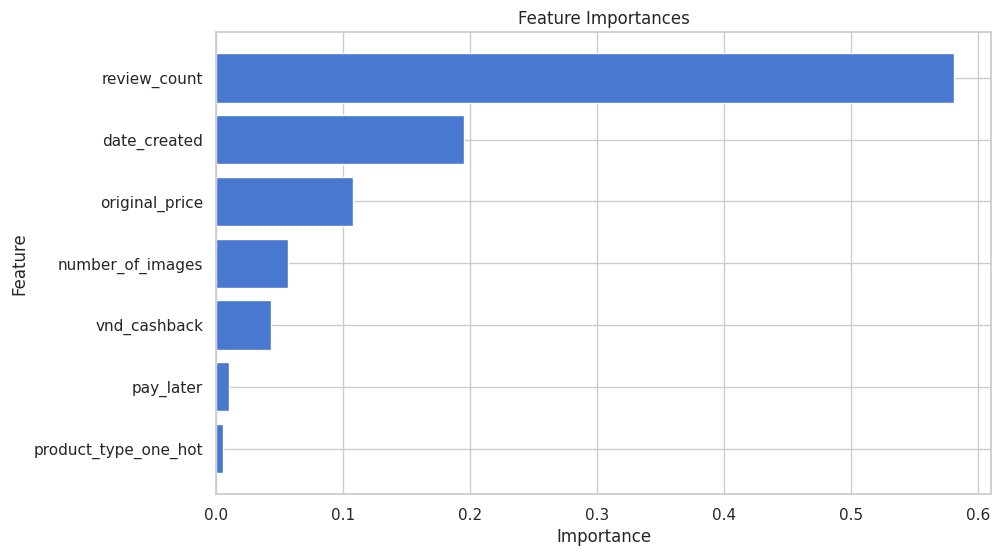

In [151]:
# findout feature importance 
importances = rf_model.featureImportances.toArray()

# Create a DataFrame for better readability
feature_importances = list(zip(feature_columns, importances))
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")


# Unzip sorted feature importances into separate lists
sorted_features, sorted_importances = zip(*sorted_feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.gca().invert_yaxis()  # Display the most important feature on top
plt.show()



## **5. Model Evaluation and Selection** <a id="5"></a>  
[Back to Top](#top)  

In [152]:

test_data_scaled.take(1)

[Row(features_sscaled=DenseVector([2.5031, 1.0718, 1.0, -1.1223, 0.1667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), quantity_sold=5)]

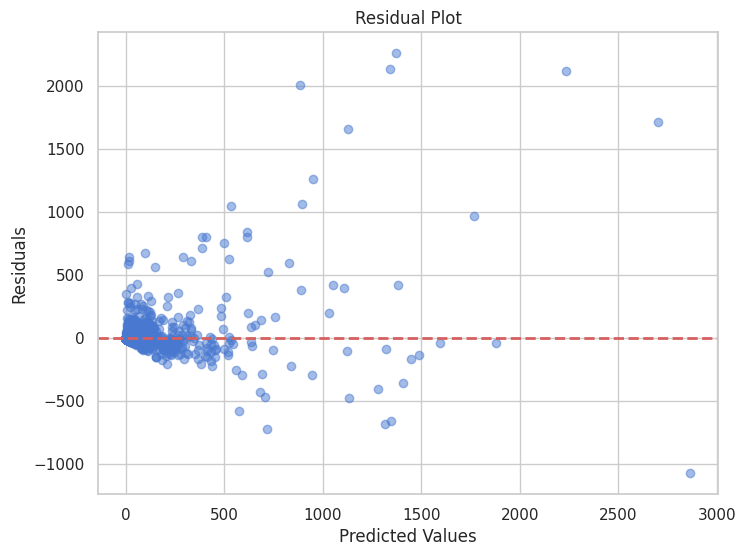

In [153]:
# Make predictions
predictions = rf_model.transform(test_data_scaled)

# Calculate residuals
predictions = predictions.withColumn("residuals", F.col("quantity_sold") - F.col("prediction"))

# Collect data for plotting
predicted_and_residuals = predictions.select("prediction", "residuals").collect()

# Separate the values for plotting
predicted_values = [row["prediction"] for row in predicted_and_residuals]
residuals = [row["residuals"] for row in predicted_and_residuals]

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--", linewidth=2)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [154]:
# Training model with basic cleaning conducted on the data (NULL imputation, cat data encoding)

# 1. Linear regression model 
#    1a. Linear regression model 
#  train RMSE: 151.8948
#  train MAE: 15.1631
#  train R2: 0.3246
#  test RMSE: 80.8492
#  test MAE: 15.3416
#  test R2: 0.5121

#    1b. Linear reg with Robust scaler                                                        
#  train RMSE: 151.6564
#  train MAE: 15.3742
#  train R2: 0.3176
#  test RMSE: 81.3174z
#  test MAE: 15.5228
#  test R2: 0.5430

#   1c. lasso L1 Regularisation 
#  train RMSE: 151.6580
#  train MAE: 15.2389
#  train R2: 0.3176
#  test RMSE: 81.2713
#  test MAE: 15.3855
#  test R2: 0.5435

# #   1d. ridge model                                                     
#  train RMSE: 151.6564
#  train MAE: 15.3683
#  train R2: 0.3176
#  test RMSE: 81.2939
#  test MAE: 15.5165
#  test R2: 0.5432

#   1e. Elastic net model 
#  train RMSE: 151.6564
#  train MAE: 15.3683
#  train R2: 0.3176
#  test RMSE: 81.2939
#  test MAE: 15.5165
#  test R2: 0.5432


# 2. GBTRegressor
#  train RMSE: 32.6742
#  train MAE: 7.1440
#  train R2: 0.9683
#  test RMSE: 99.9488
#  test MAE: 11.8934
#  test R2: 0.3096

# 3. decision tree regressor
# max depth = 5 
# train RMSE: 63.2839
#  train MAE: 10.4897
#  train R2: 0.8812
#  test RMSE: 97.6582
#  test MAE: 11.9305
#  test R2: 0.3409


# 4.Random forest regressor

# a. 
#  numTrees=70,      
#     maxDepth=10,    
#     maxBins=32      
# )
#  train RMSE: 69.1240
#  train MAE: 8.0089
#  train R2: 0.8582
#  test RMSE: 92.0529
#  test MAE: 11.2918
#  test R2: 0.4143

# b.
#     numTrees=20,    
#     maxDepth=5,    
#     maxBins=32      
# )
#  train RMSE: 108.8753
#  train MAE: 11.6895
#  train R2: 0.6483
#  test RMSE: 96.9198
#  test MAE: 12.7726
#  test R2: 0.3508

# c.
#     numTrees=100,    
#     maxDepth=10,    
#     maxBins=32      
# )
#  train RMSE: 77.6867
#  train MAE: 7.9485
#  train R2: 0.8209
#  test RMSE: 91.6488
#  test MAE: 11.3746
#  test R2: 0.4195

# d.  
#     numTrees=150,    
#     maxDepth=5,    
#     maxBins=64       
# )
#  train RMSE: 67.1731
#  train MAE: 10.7173
#  train R2: 0.8661
#  test RMSE: 79.0129
#  test MAE: 11.6421
#  test R2: 0.5685

# e.
#     numTrees=200,  
#     maxDepth=5,     
#     maxBins=120 

#  train RMSE: 70.2252
#  train MAE: 10.5400
#  train R2: 0.8537
#  test RMSE: 88.7679
#  test MAE: 11.8004
#  test R2: 0.4554( higher!!)

# f.
#     numTrees=200,   
#     maxDepth=7,    (increased depth)
#     maxBins=120 
#     seed=42   
# train RMSE: 57.3685
#  train MAE: 8.5608
#  train R2: 0.9023
#  test RMSE: 71.9604
#  test MAE: 9.9009
#  test R2: 0.6424


# after further transformations: 
#     numTrees=200,   
#     maxDepth=7,   
#     maxBins=120 
#     seed=42   
#  train RMSE: 67.5100
#  train MAE: 9.9036
#  train R2: 0.8632
#  test RMSE: 64.9749
#  test MAE: 11.9129
#  test R2: 0.7247

# added minInstancesPerNode=2,
#  train RMSE: 93.9592
#  train MAE: 9.9786
#  train R2: 0.7351
#  test RMSE: 64.9956
#  test MAE: 11.6113
#  test R2: 0.7245 

# with TFIDF done on names  and descriptions
#  train RMSE: 89.5069
#  train MAE: 10.3173
#  train R2: 0.7596
#  test RMSE: 67.4519
#  test MAE: 12.5121
#  test R2: 0.7033 (model is better on train but not test)



In [155]:
# conducting grid search to find out the best parameter to the random forest regressor 
# paramGrid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [100, 200]) \
#     .addGrid(rf.maxDepth, [5, 7, 10]) \
#     .addGrid(rf.maxBins, [80, 12]) \
#     .addGrid(rf.minInstancesPerNode, [1, 2, 4]) \
#     .build()

# cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator = RegressionEvaluator(metricName="r2", labelCol="quantity_sold")
# , numFolds=5)

# cvModel = cv.fit(train_data_scaled)

# bestModel = cvModel.bestModel
# best_params = cvModel.bestModel.extractParamMap()

# for param, value in best_params.items():
#     print(f"{param.name}: {value}")

## **6. Report** <a id="6"></a>  
[Back to Top](#top)  


## **Table of Contents** <a id="intro"></a>

#### [1. Problem Statement Formulation](#1-report)
#### [2. Exploratory Data Analysis and Data Cleaning](#2-report)
#### [3. Data Wrangling and Transformation](#3-report)
#### [4. Machine Learning Modelling](#4-report)
#### [5. Model Evaluation and Selection](#5-report)
#### [6. Summary and Further Improvements](#6-report)


### **1. Problem Statement Formulation** <a id="1-report"></a>  
[Top](#intro)  

The e-commerce sector is rapidly growing, influenced by numerous factors that affect sales and demand. With the rising popularity of various trends, it has become challenging to determine a product's popularity accurately. This creates a need for effective inventory management, ensuring that supply aligns with demand.

The goal of this project is to leverage the power of data analytics to build a predictive model that forecasts sales demand. This model will help optimize inventory management for online retail sellers by predicting the `quantity_sold` of a product. 

The data that we will be analysing on contains `18` variables and `44804` observations.

Information available: 
* Product related: `id`, `name`, `description`, `brand`, `product_type`
* Sales metrics: `quantity_sold`, `original_price`, `vnd_cashback`
* User interaction: `review_count`, `rating_average`, `favourite_count`
* Metadata: `date_created`, `number_of_images`, `has_video`

Using available information on current products, sales metrics, and user interactions, the project aims enable sellers to manage inventory efficiently and prioritize popular products. 


### **2. Exploratory Data Analysis and Data Cleaning** <a id="2-report"></a>  
[Top](#intro)  

#### **Data Examination** <br>

 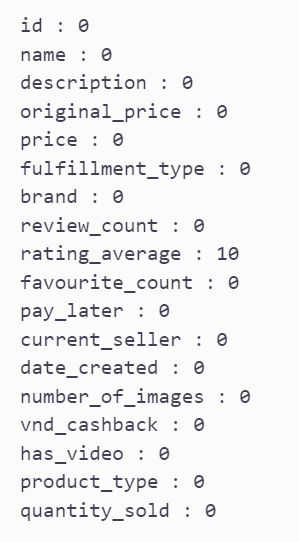<br>
> Only `rating_average`contains NULL.

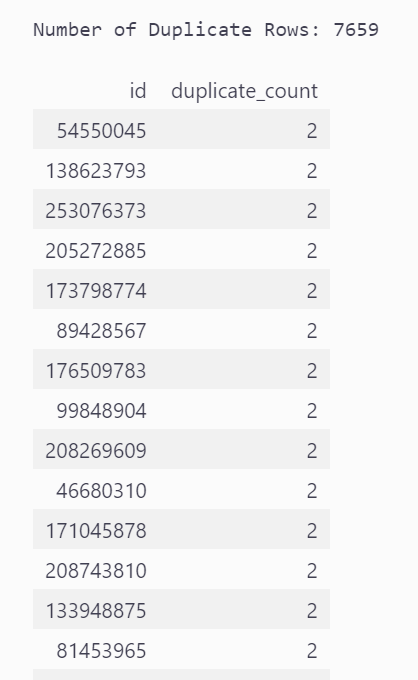<br>
> Since IDs are unique identifiers, duplicated IDs should be removed.

#### **Categorical Data Analysis** <br>
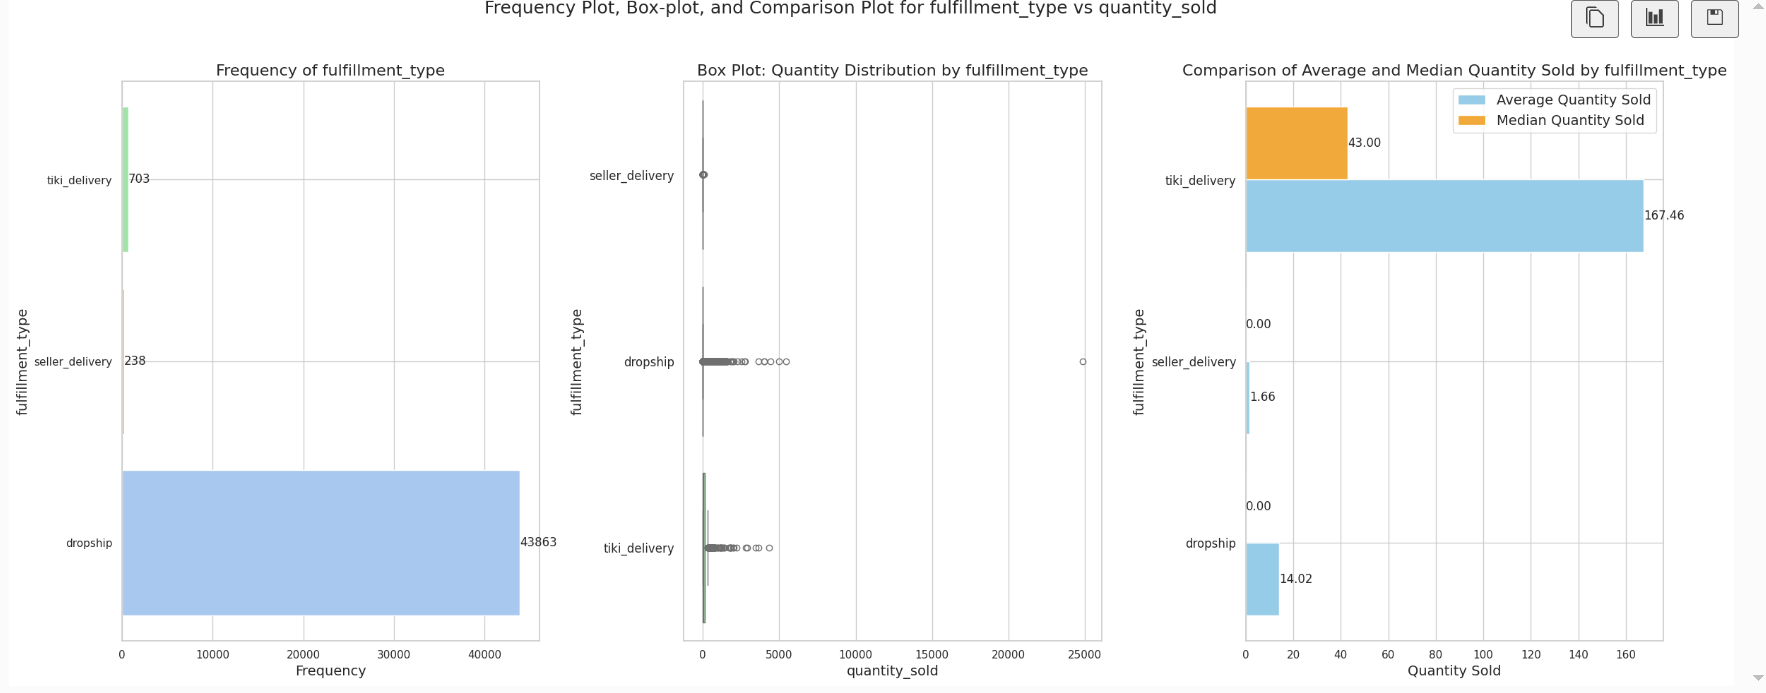<br>
> * Most common fulfillment type is through ` dropship` , but `tiki_delivery` products consistently have a higher `quantity_sold` through higher mean and median.
> * Some items in `dropship` have a high `quantity_sold`.

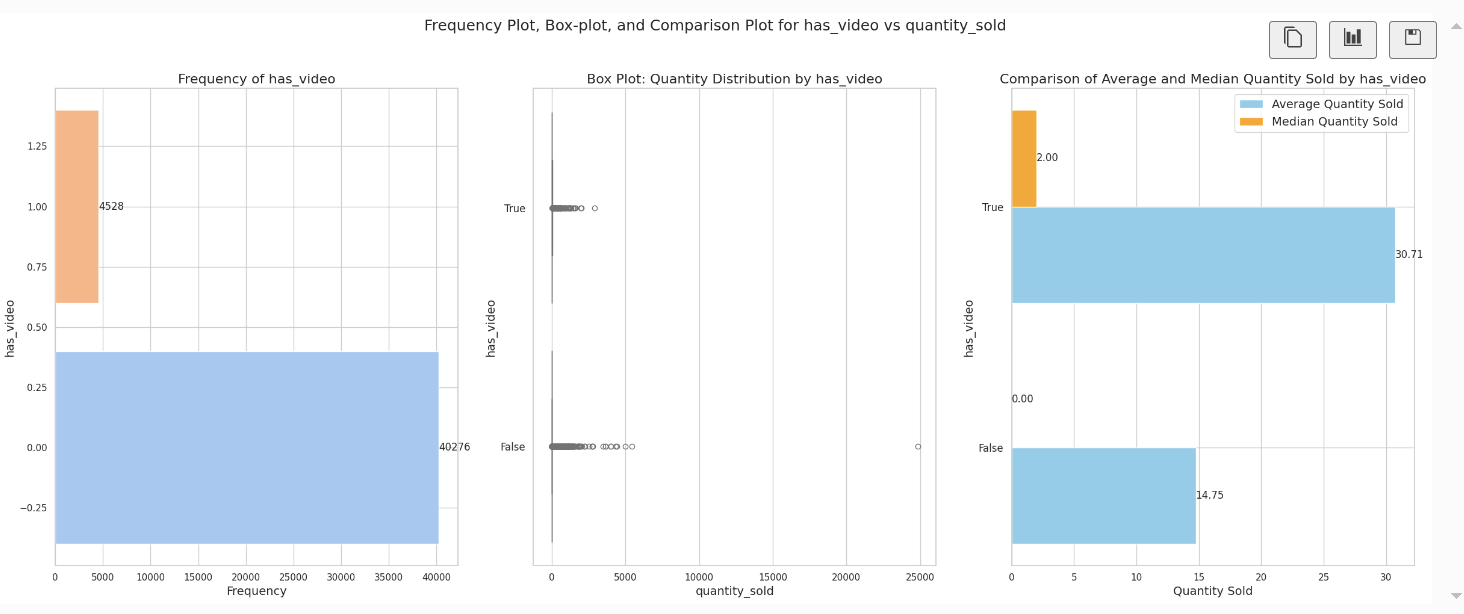 <br>
> * `has_videos` products have a higher `quantity_sold`.


 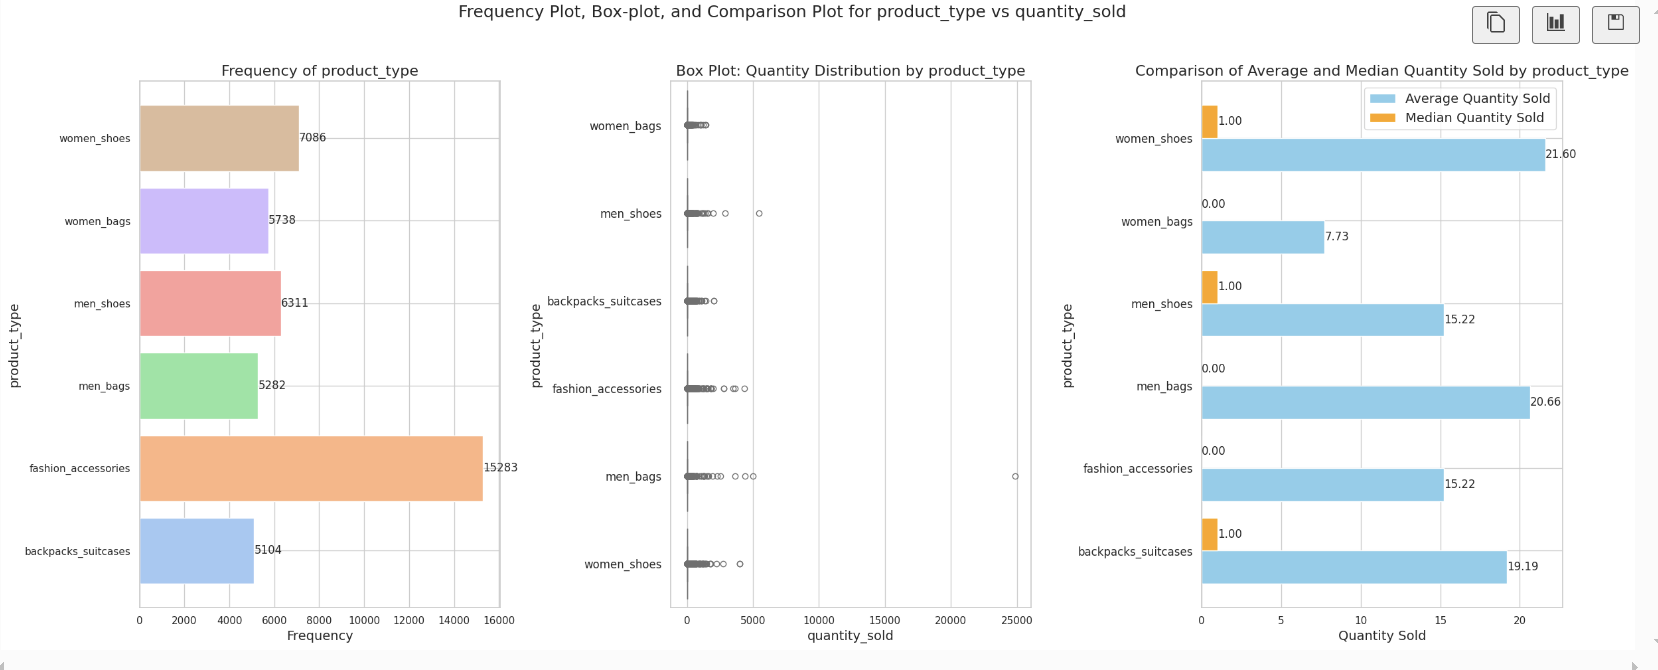<br>
> * `fashion_accesssories` has many products but moderate `quantity_sold`.
> * The median `quantity_sold` for `men_bags` is 0, hence the product with extremely high `quatity_sold` is an exception in `men_bags`. 


<br>
<br>

#### **Numerical Data Analysis**
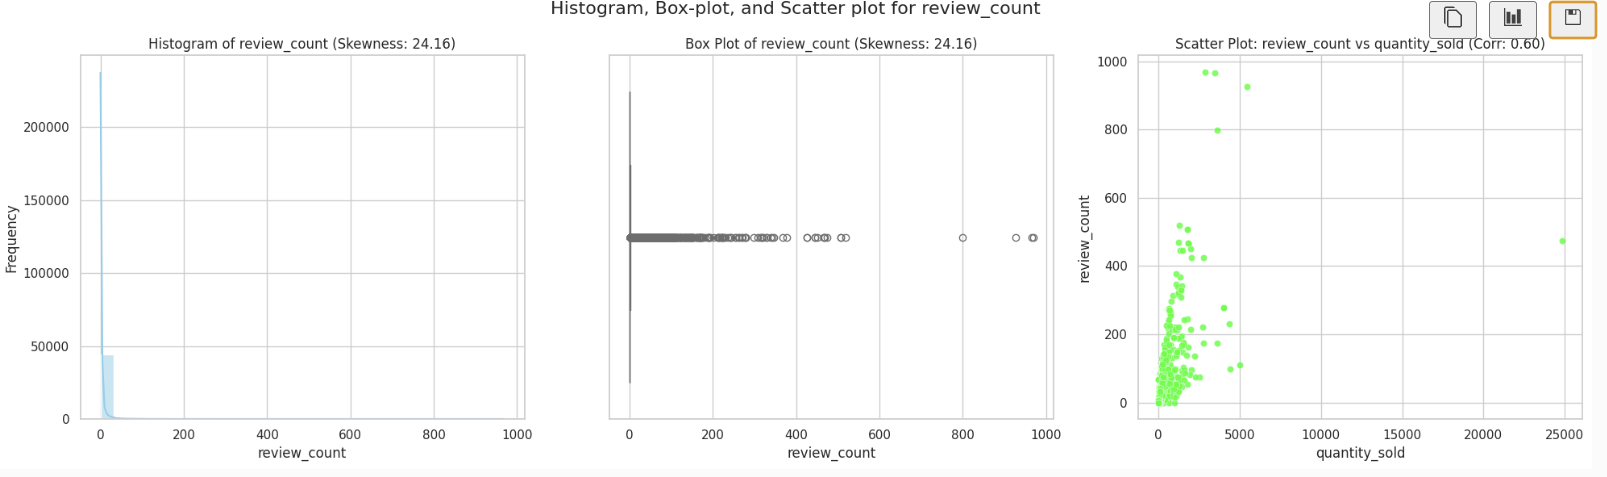 <br>
> * `quantity_sold` increases as `review_count` increases
<br>

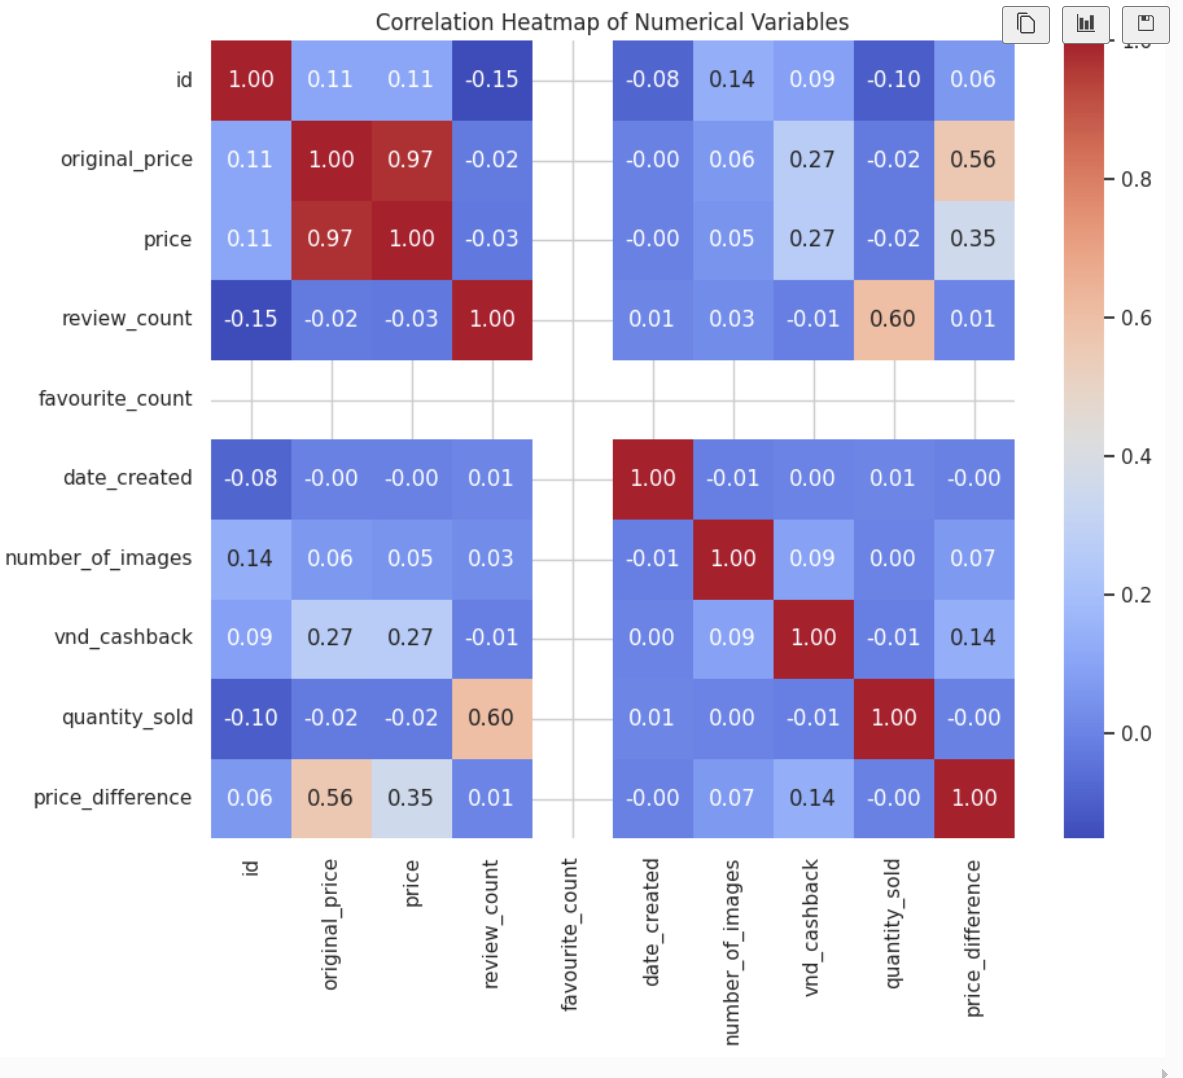
> * `Original_price` and `price` are highly correlated
> * `Review count` has the highest correlation with `quantity_sold`
> * Weakly correlated variables with `quantity_sold` may need further transformations to uncover patterns.

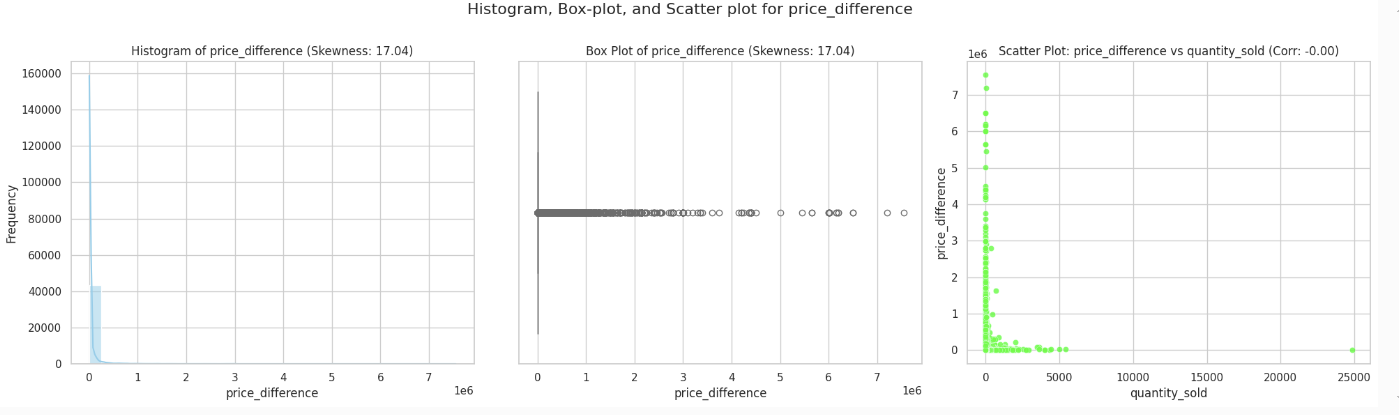
> Difference in `original_price` and `price` does not affect the quantity_sold
<br>
<br>

#### **Data Errors**
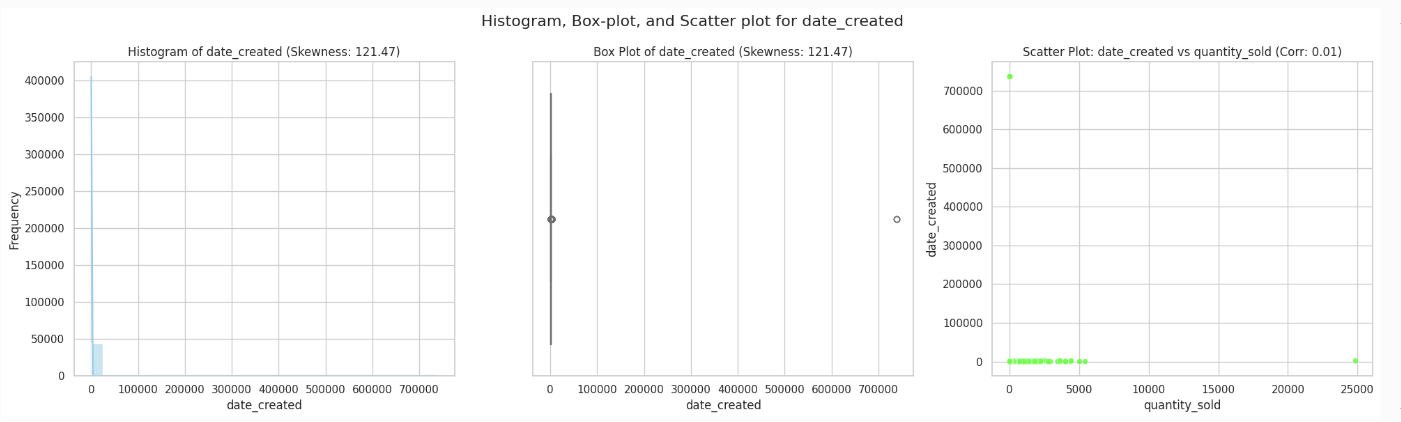
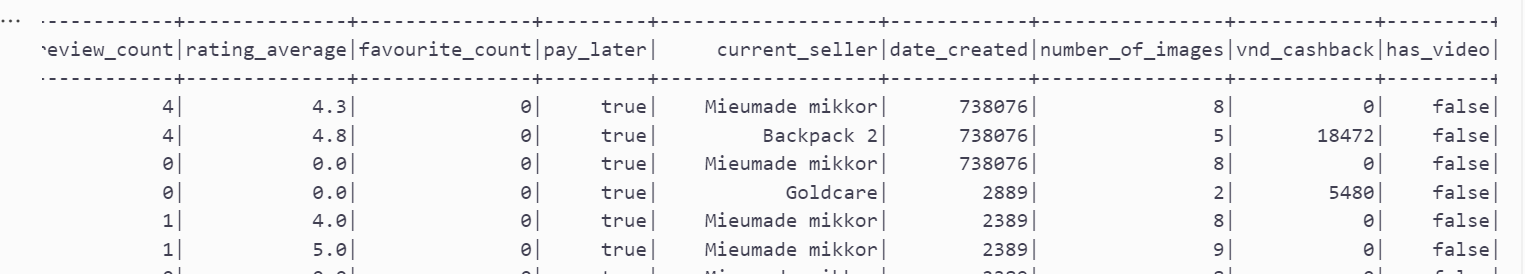
> `date_created` with `738076` is a potential error as it is unrealistic to have a difference of 2022 years between the last update date and the created date, hence outlier trimming should be conducted. 

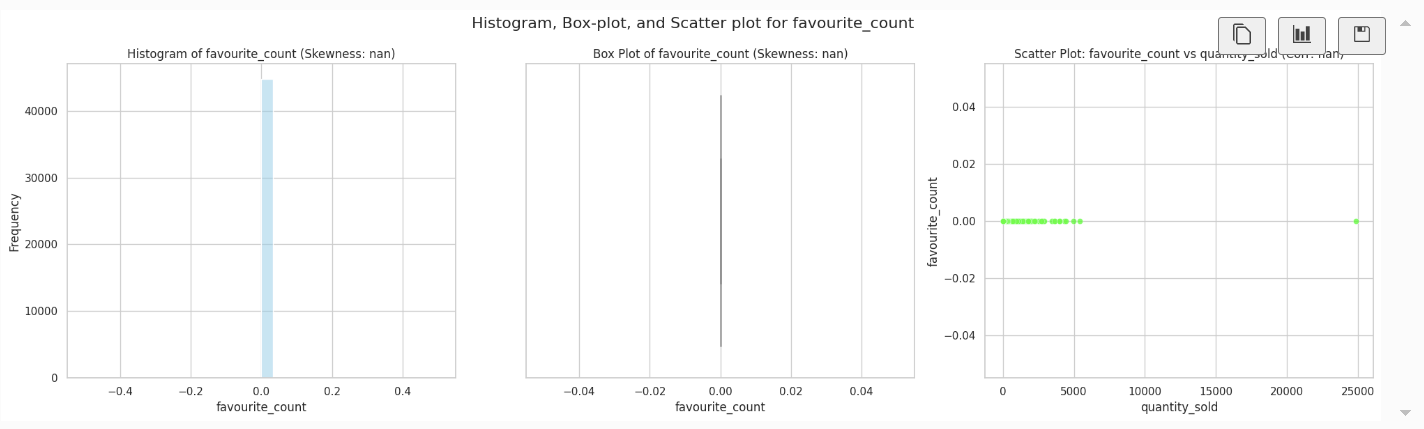
> `favourite_count` has only one category, it is not meaningful and can be removed.

<br>
<br>


#### **Examining `current_sellers` and `brands`**
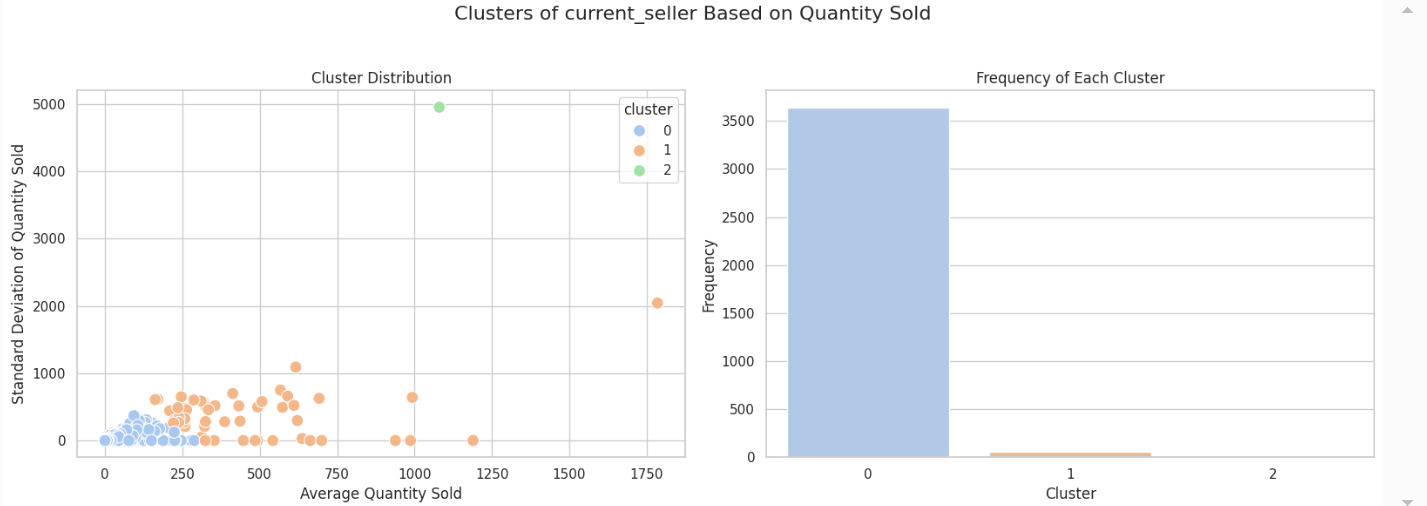
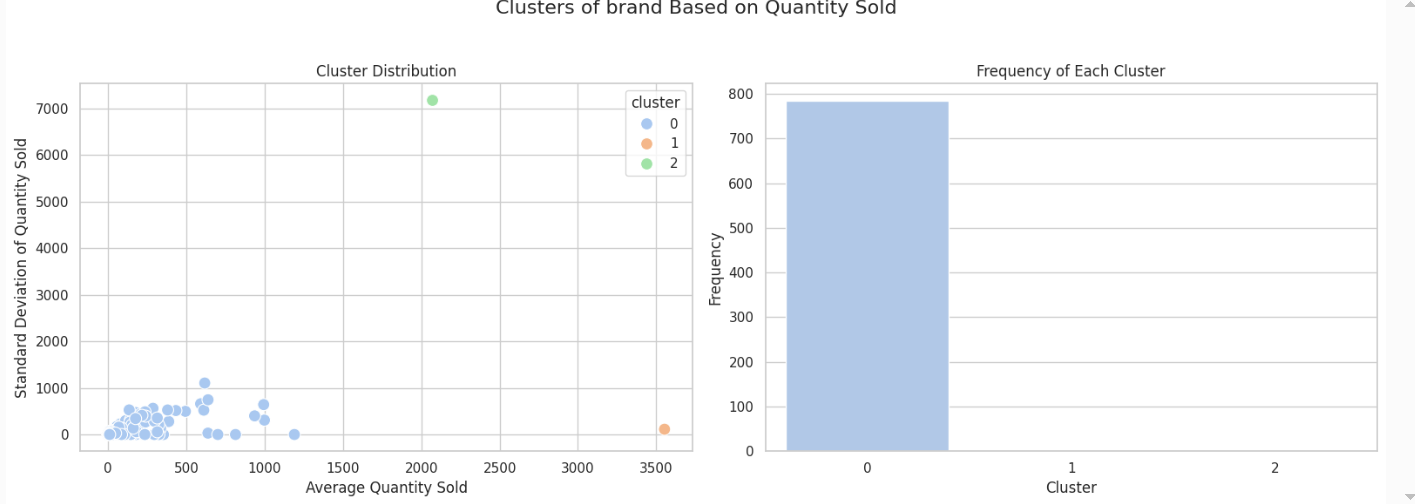
> * Most `sellers` and `brands` show consistent sales with low standard deviation.
> * Apply target-mean encoding to these variables to explore potential relationships with the target. 

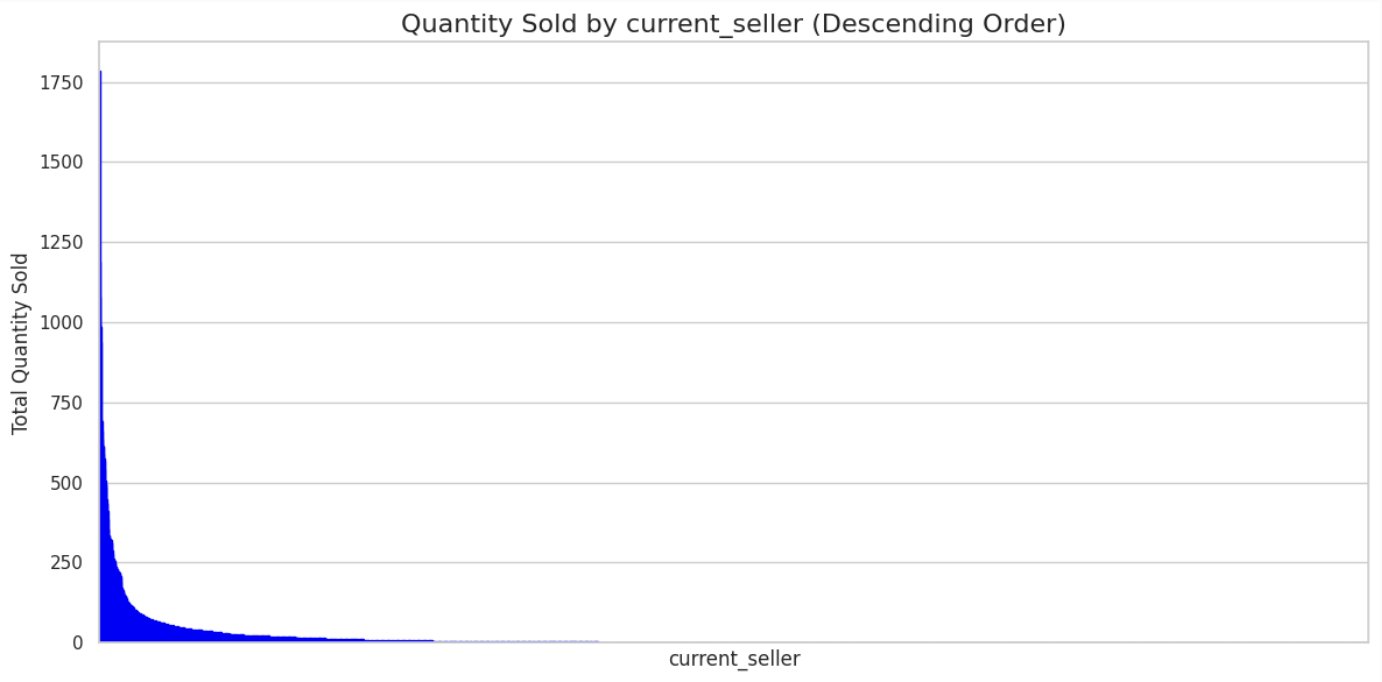
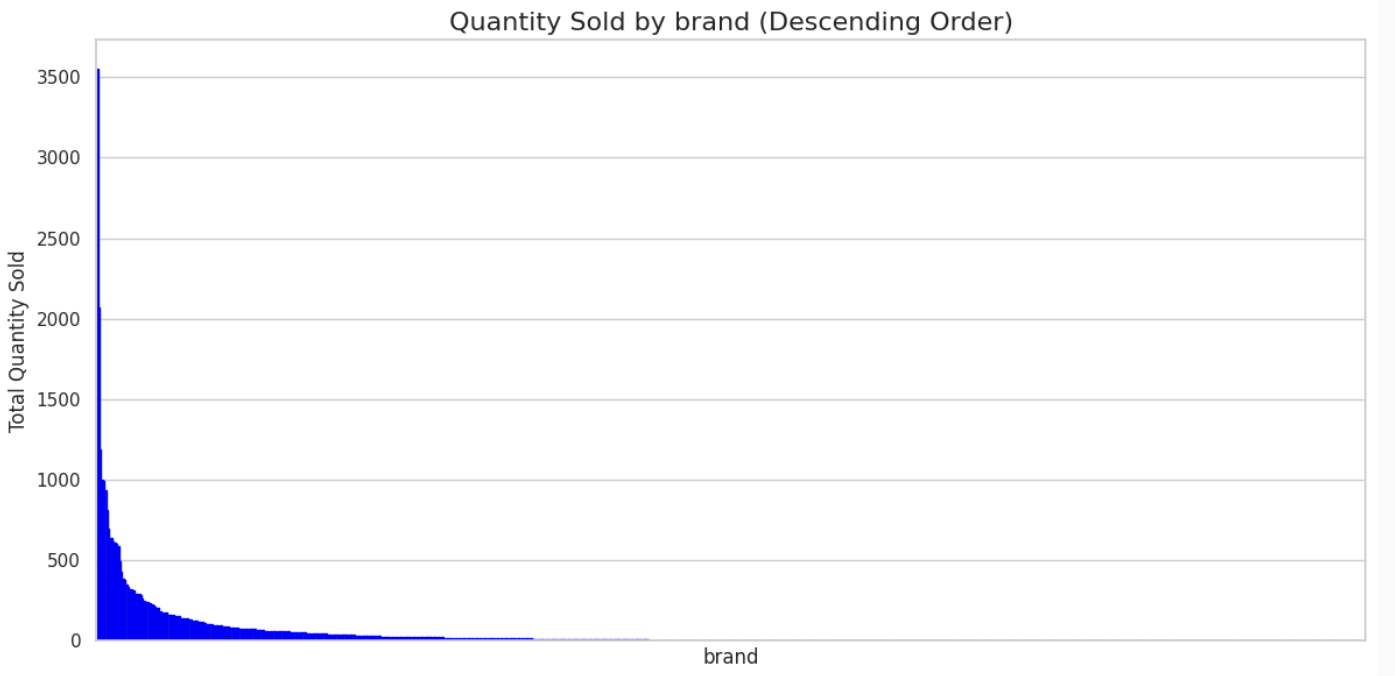
> * `quantity_sold` is unevenly distributed, with many sellers and brands having low sales.
> * Group low-performing sellers and brands to reduce noise and prevent overfitting.




### **3. Data Wrangling and Transformation** <a id="3-report"></a>  
[Top](#intro)  


During initial data cleaning, duplicate ID rows were removed,`favourite_count` was dropped, and outliers in `date_created` were trimmed.
 

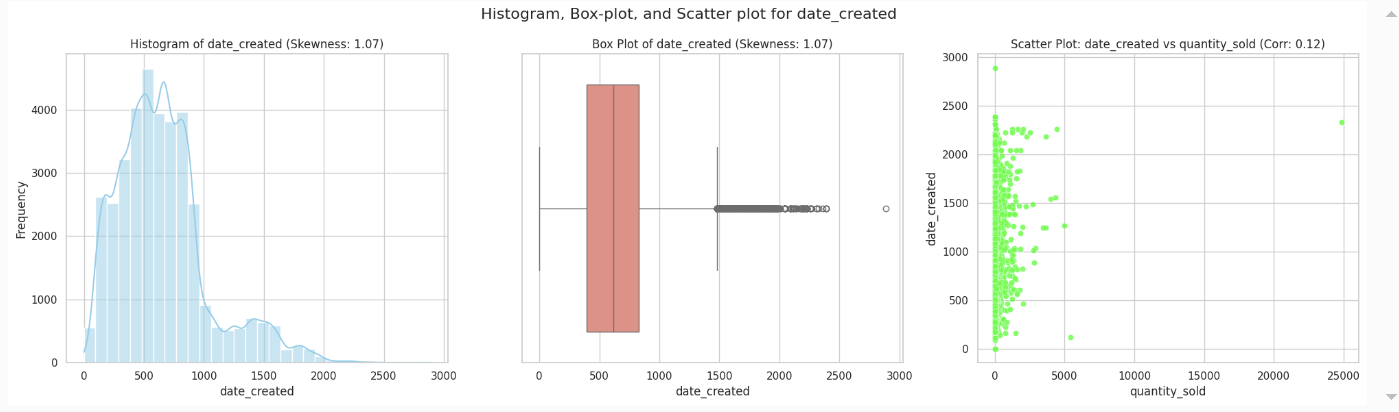
>The distribution and relation between `date_created` and `quantity_sold` is now clearer. 


#### **Missing Data Imputation**
> Missing `rating_average` values are imputed with the mean value from the training data. 


#### **Categorical Data Encoding**<br>
Categorical variables’ cardinality:<br>
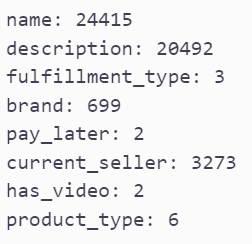
> * `id`,`name`, `description` are dropped as they have high cardinality and no direct relationship with the target variable
> *  `pay_later` and `has_video` are converted from Boolean to binary columns.
> * **One hot encoding** was applied to `product_type` and `fulfillment_type` to preserve their independence. 
> * After various testing on encoding `current_sellers` and `brand`, model performs better with dropping `current_sellers`, and conducting **target-mean encoding** to `brand` without grouping less popular categories.

#### **Numerical Data Transformation** <br>
> * Transformations are done to highly skewed features (`original_price`, `price`, `review_count`, `vnd_cashback`,` brand_mean_encoded`) as they can cause imbalanced splits for random forest regressor, affecting predictive accuracy 

After transformation: <br>
1. More normalized distribution: 
> 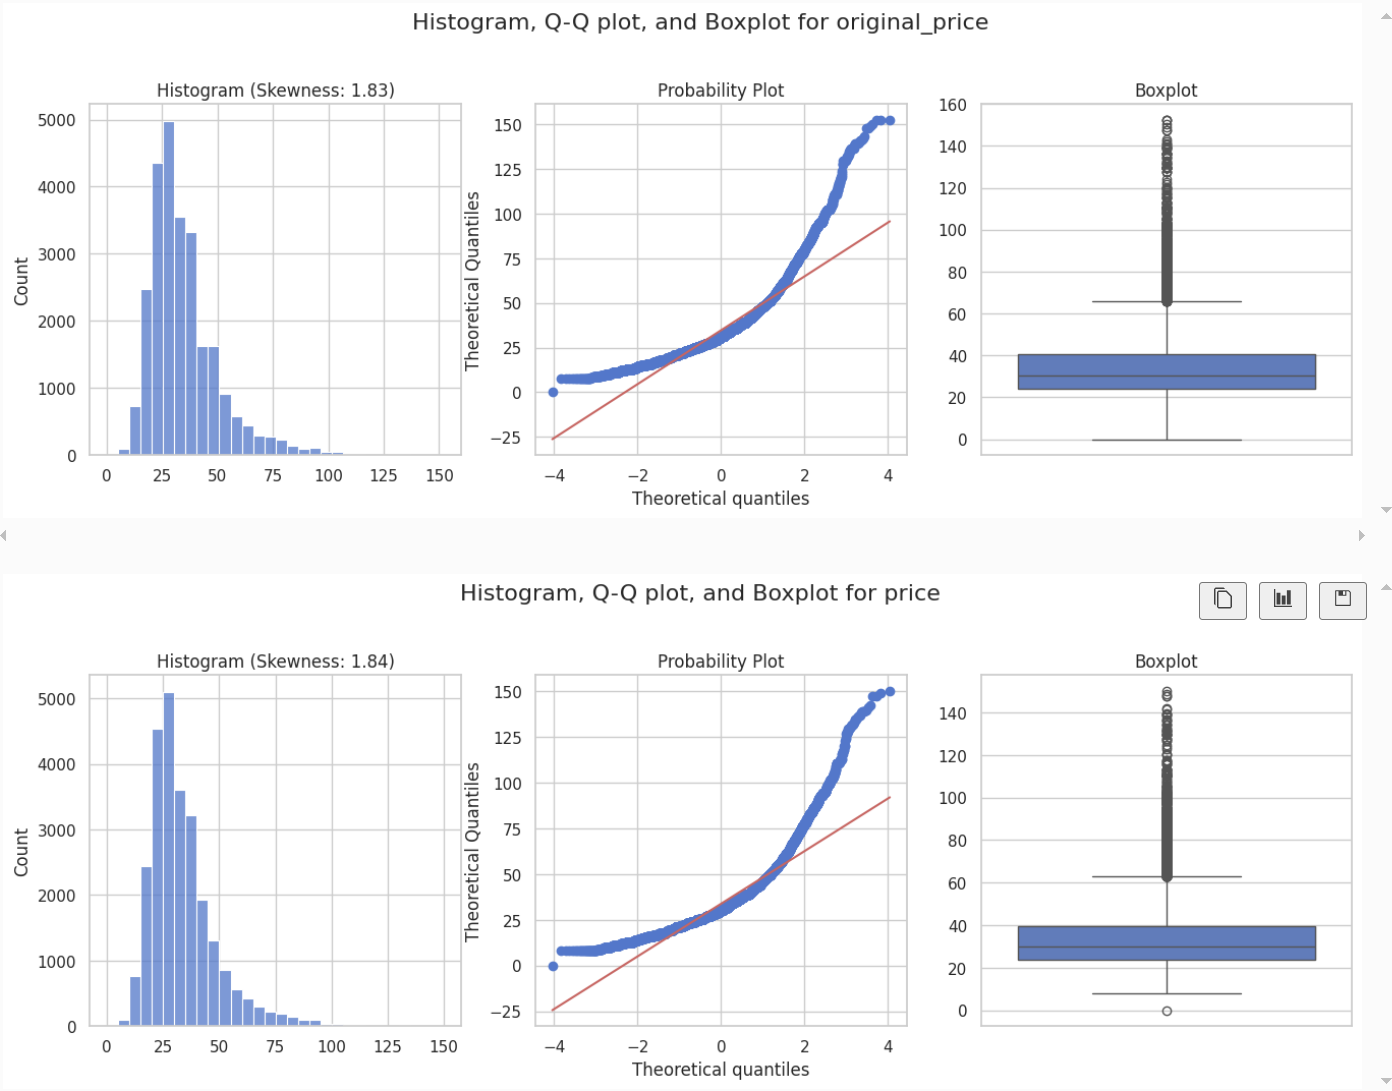
> 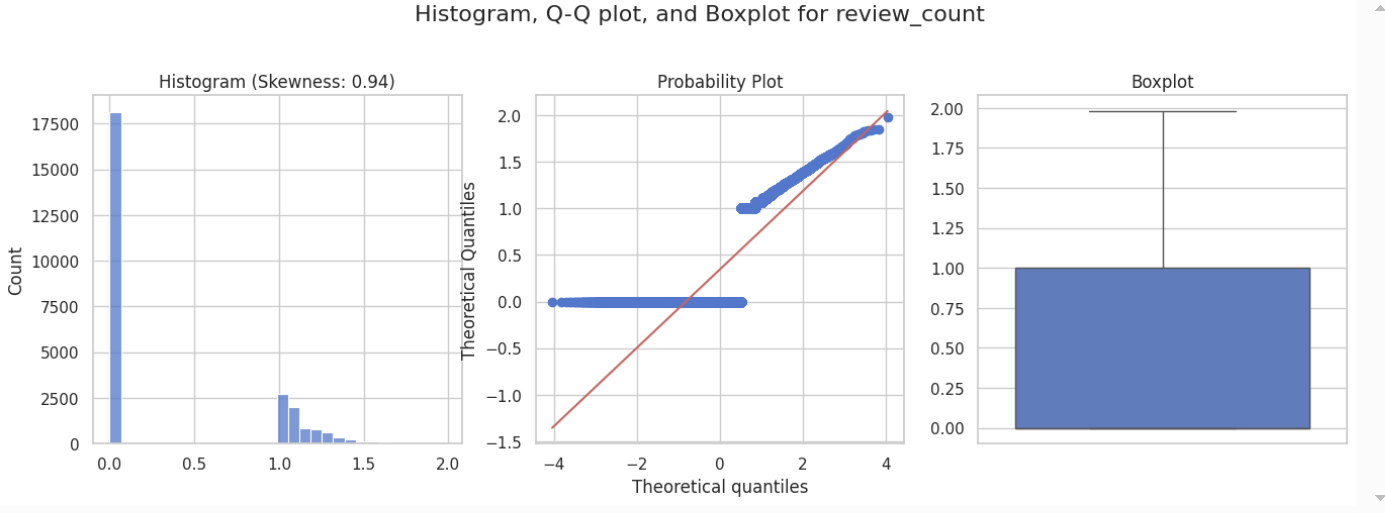
> 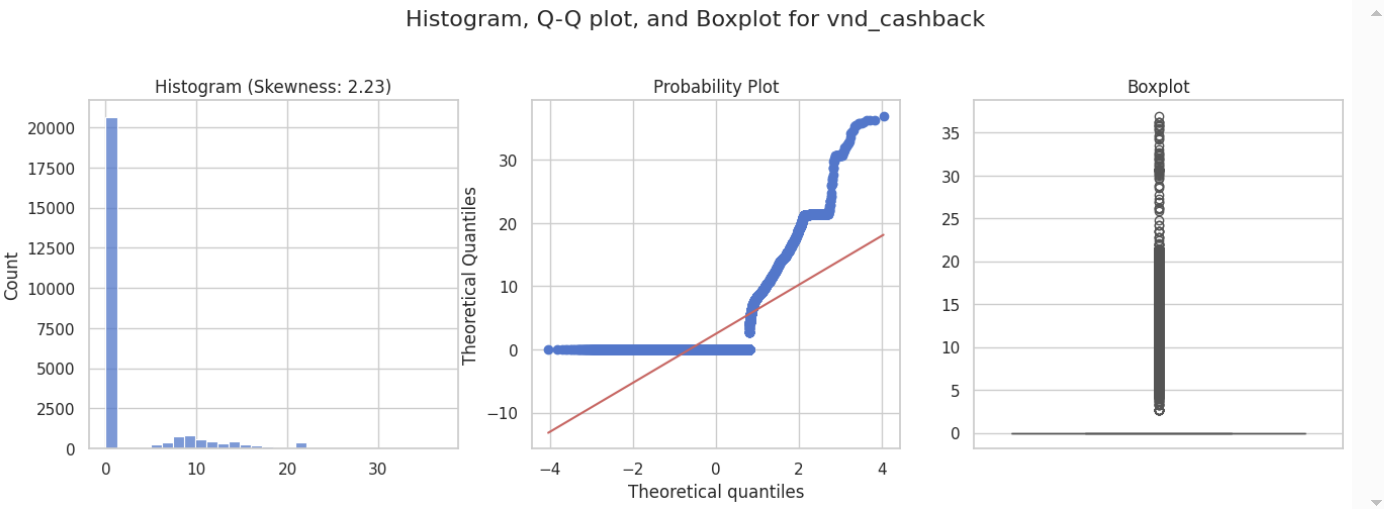
> 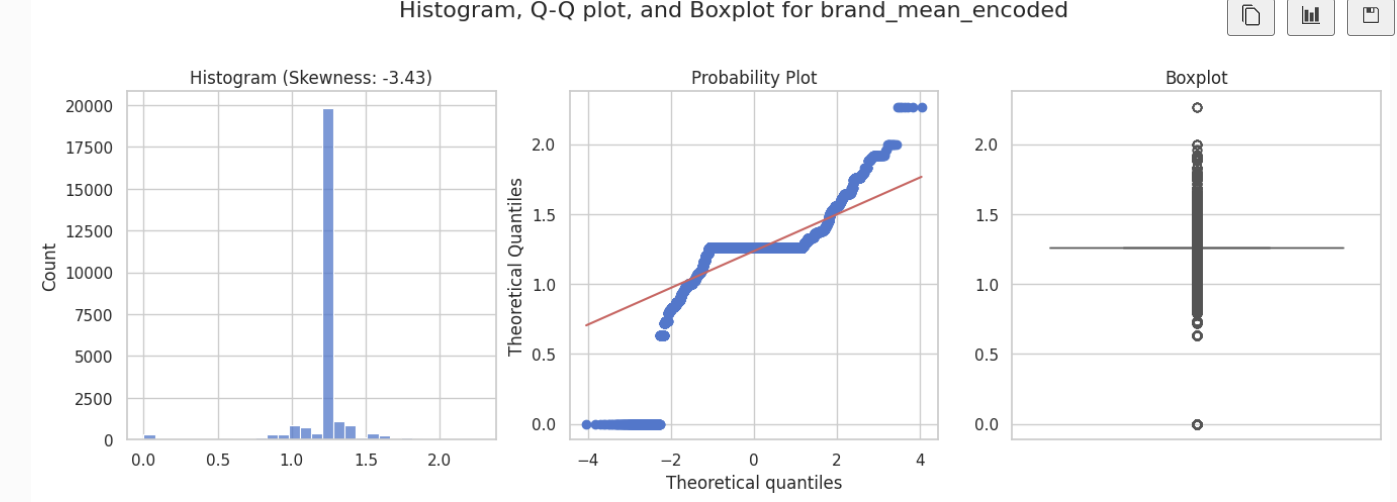
 
2. Better model performance: 
> 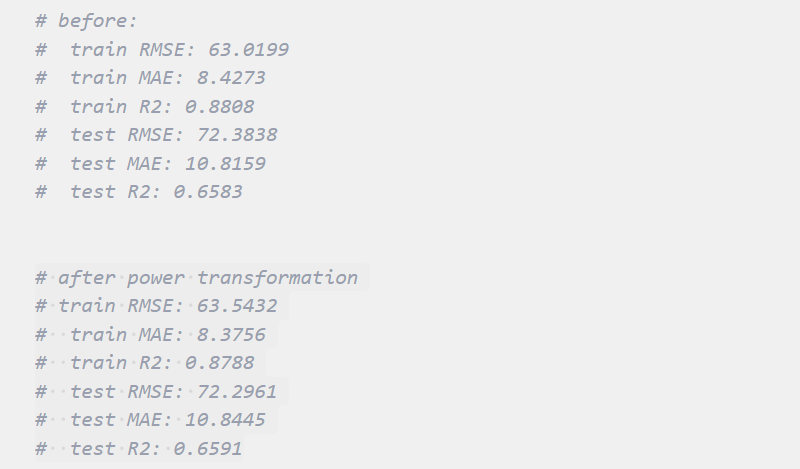
 
#### **Correlation  Analysis**
Correlations between the variables are reviewed again: 
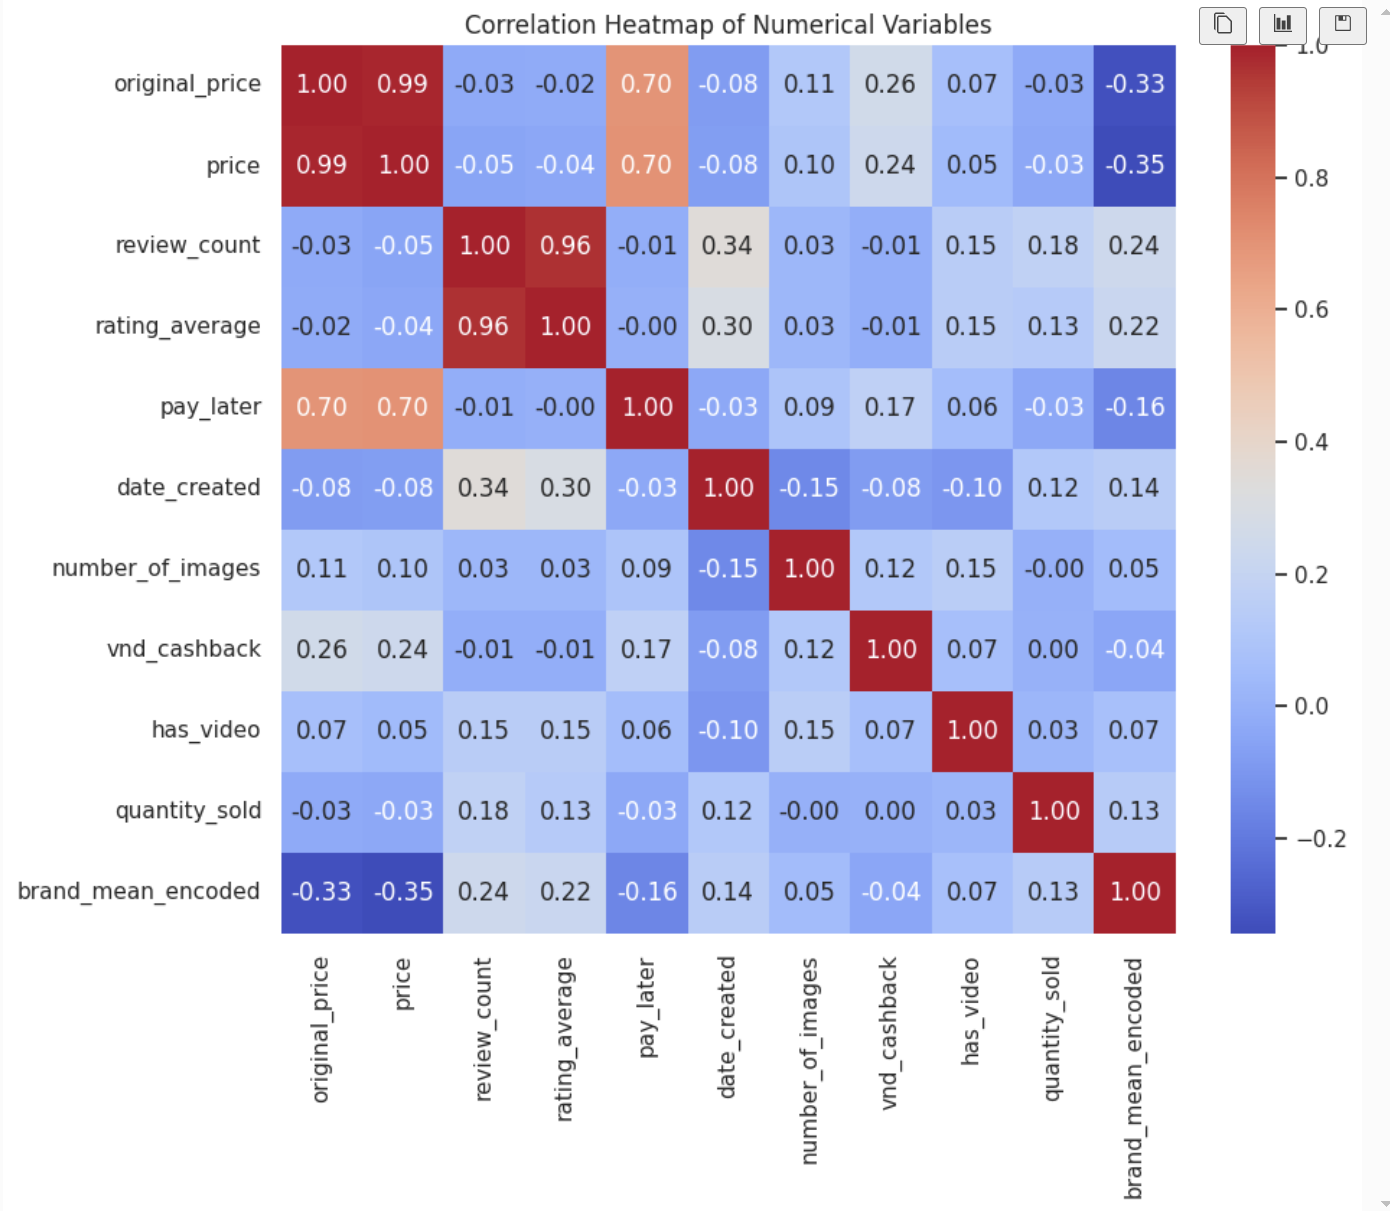
>**multicollinearity:**
>* `original_price` & `price`
>* `review_count` & `rating_average`
>
> **low correlations with the target:**
>* `vnd_cashback`
>* `number_of_images`

> Multicollinear variables affect model performance and are dropped. 

 

#### **Feature Scaling**
Scaling features ensures that features with larger scales don't dominate the decision-making process of regression models, allowing for accurate identification of important features. 

 * Both standard and robust scaling were tested. 
>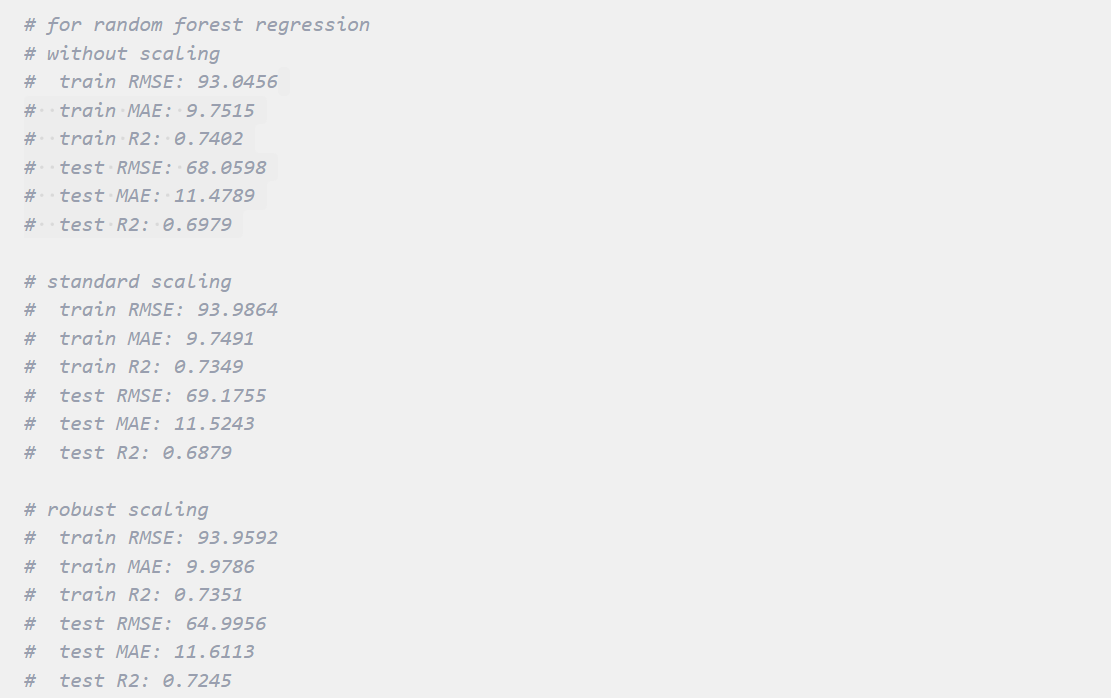
> From the results, the model performs better with robust scaling. 


### **4. Machine Learning Modelling** <a id="4-report"></a>  
[Top](#intro)  

Rows and column for final data: <br>
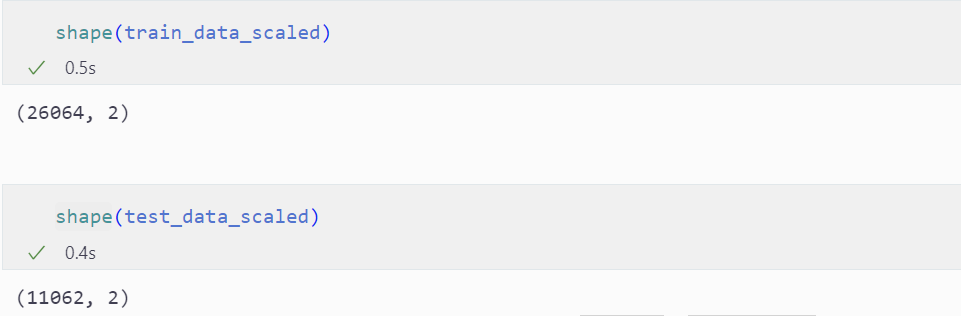 <br>
 > After transformations, the final training set contains 26064 observations and the test set includes 11062 observations. 


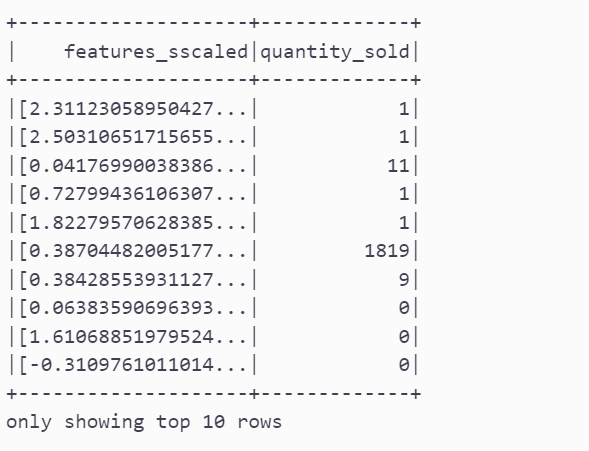<br>
 The variable used to train the model is `features_sscaled`, a vector containing all the features after scaling is applied. <br>


#### **Building and testing different models**
* Various regression models are built and trained on a dataset with minimal cleansing (only missing and categorical features handled) to determine the best model with the current data. 
* After various testing and evaluations (to be discussed in further details in the next section), I have chosen to work with the **Random Forest Regressor**, and conducted further data wrangling to fine-tune the model (outlier and numerical transformations on the data)

#### **Features Importances**
* After wrangling the data and training the model, the `.featureImportance` attribute in the model was used to find out the relative importance of each feature to the model's predictions.
 
 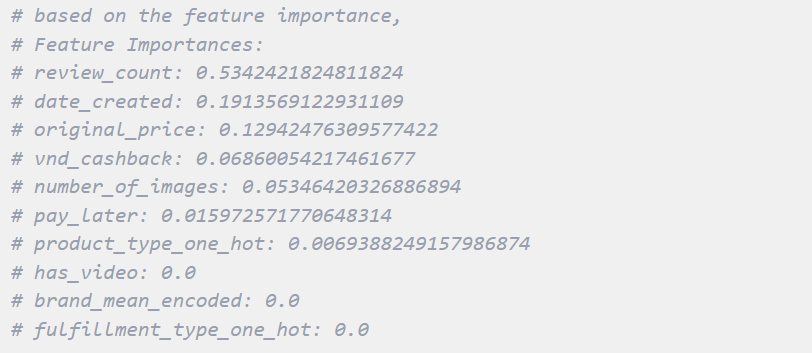
>Based on the results, variables `has_video`, `brand_mean_encoded` and `fulfillment_type_one_hot` have low importance to the model’s predictions. 
> * Hence, they should be removed to reduce complexity and improve model performance. 
 
 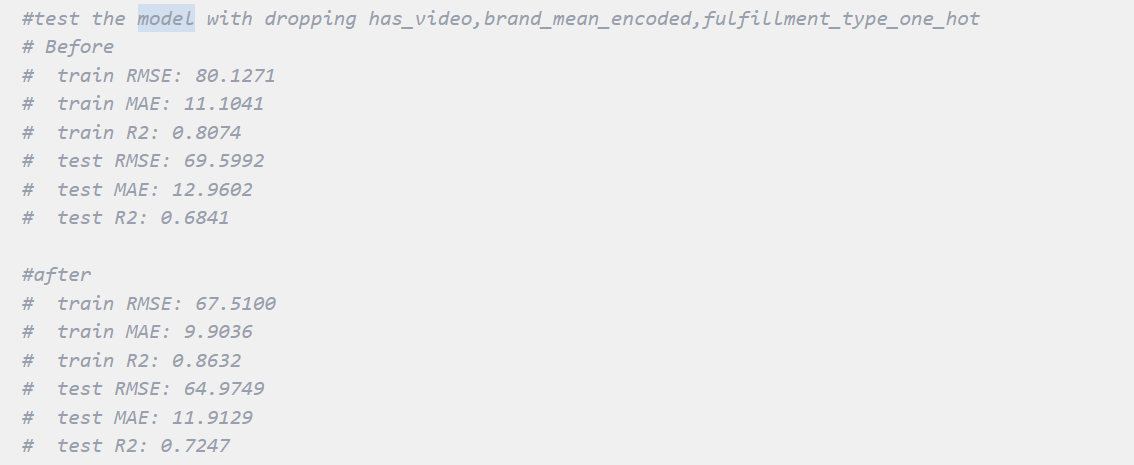
> Better model performance is observed after removing redundant features. 







### **5. Model Evaluation and Selection** <a id="5-report"></a>  
[Top](#intro)  

#### **Model Comparison**
1.	Linear Regression
> * The baseline linear regression models showed limited predictive capability, with moderate training R^2 (~0.32) and testing R^2 (~0.51).
> * Applying scaling and regularization (Lasso, Ridge, Elastic Net) did not significantly improve the performance, with Testing R^2 remaining around ~0.54.

2.	Gradient Boosted Trees (GBTRegressor)
> * While GBT performed well on the training data (R^2 of 0.97), its testing performance dropped significantly (R^2 of 0.31), indicating overfitting.
> * GBT’s higher training complexity and sensitivity to overfitting make it less reliable for this dataset. 

3.	Decision Tree Regressor
> * With a maximum depth of 5, Decision Trees provided decent training performance (R^2 of 0.88) but relatively lower generalization on the test set (R^2 of 0.34).

4.	Random Forest Regressor
> * Random Forest models showed the best balance between training and testing performance, especially after hyperparameter tuning.
> * The final configuration (numTrees=200, maxDepth=7, maxBins=120, seed=42) and further data transformation achieved a test R^2 of 0.7247, with an RMSE of 64.97 and MAE of 11.91. This indicates a significant improvement over other models.
> * Adding minInstancesPerNode=2 slightly reduced overfitting, maintaining test performance (R^2 of 0.7245) while controlling training complexity.

**Model Selection**
> * The Random Forest Regressor is chosen due to its strong generalization ability and relatively low error overall.

#### **Model Evaluation**
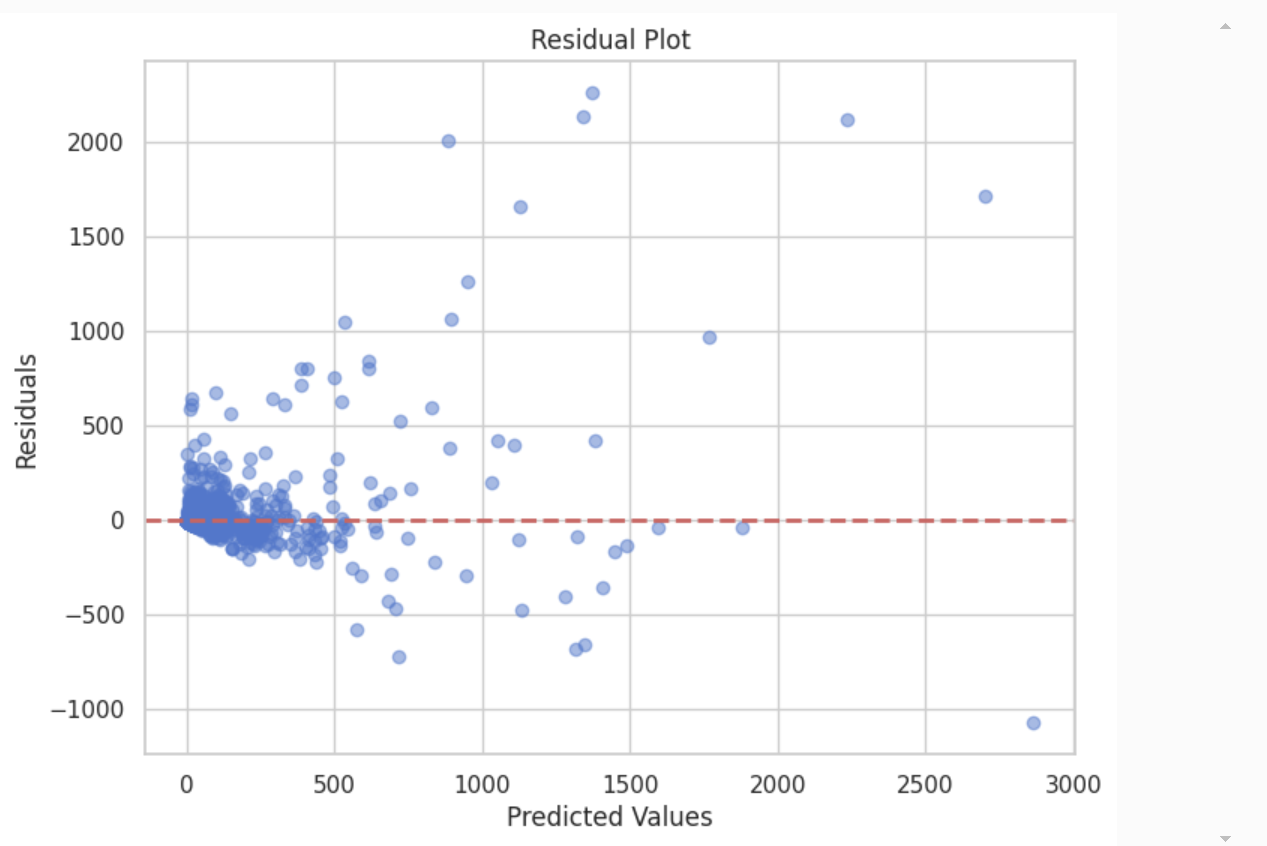
> This plot shows the model's prediction errors for quantity_sold on the test set. Most residuals are centered around zero, indicating unbiased predictions, but accuracy declines as quantity_sold increases.


### **6. Summary and Further Improvements** <a id="6-report"></a>  
[Top](#intro)  

**Key Insights**
1. Exploratory Data Analysis
> * The number of reviews shows a strong relationship with the `quantity_sold`.
> * For most sellers and brands, the `quantity_sold` is relatively consistent across different products. However, some brands and sellers achieve higher popularity and higher overall sales, while the majority have low overall quantities sold.
> * The `men_bags` product category includes a product with an exceptionally high quantity sold compared to others.
> * Errors are identified in the `date_created` field, and missing values are observed in `rating_average`.
2. Data Wrangling Process
> * Most variables were highly skewed, and their skewness was addressed using numerical transformations.
> * After transformations, variables exhibiting multicollinearity were identified and removed.
> * Based on the feature importance, the top 3 most importance variables in predicting the `quantity_sold` is `review_count`, `date_created` and `original_price`
> * Variables such as `has_video`, `fulfillment_type` has low importance in predicting the `quantity_sold`

**Further Improvements**
> Based on the residual plot, the model struggles to predict products with high quantities sold. To improve performance, I can 
> * focus on analyzing the subset of data with products with higher sold quantity, examining patterns among sellers or brands that consistently achieve high sales. This analysis could help the model capture hidden relationships, potentially enhancing its predictive accuracy.
> * Examine temporal features such as seasonality or locations as the popularity of products could vary in different times of the year or different regions in Vietnam. 







### **7. References** <a id="7"></a>  
[Top](#intro)  

Greeks for Greeks (2024, May 28) _Methods for Dealing with Outliers in Regression Analysis_ Retrieved on 10 December 2024, from : https://www.geeksforgeeks.org/methods-for-dealing-with-outliers-in-regression-analysis/